In [156]:
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import glob
import os
from pycorenlp import StanfordCoreNLP
import matplotlib.pyplot as plt
# The keywords used to extract this data were Trump, Biden and elections2020

In [ ]:
# Alternative and more accurate Sentiment Analyser. Will use this later

'''
nlp = StanfordCoreNLP('http://localhost:9000')
def get_sentiment(text):
    res = nlp.annotate(text,
                       properties={'annotators': 'sentiment',
                                   'outputFormat': 'json',
                                   'timeout': 1000,
                       })
    print(text)
    print('Sentiment:', res['sentences'][0]['sentiment'])
    print('Sentiment score:', res['sentences'][0]['sentimentValue'])
    print('Sentiment distribution (0-v. negative, 5-v. positive:', res['sentences'][0]['sentimentDistribution'])
    
    return [res['sentences'][0]['sentiment'],res['sentences'][0]['sentimentValue'],res['sentences'][0]['sentimentDistribution']]
'''

In [168]:
# Code to put all cleaned files in a single dataframe
data_dir = ['2020-09'] # you will have to specify the directories you created
dir_frames = dict()
for dir in data_dir:
    path = os.getcwd() + f'\\{dir}\\'
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col="created_at",low_memory=False)
        li.append(df)
    frame = pd.concat(li, axis=0)
    dir_frames[dir] = frame

frame = pd.concat(list(dir_frames.values()),axis=0)
len(frame)

150900

In [169]:
# Dropping same tweets
frame.drop_duplicates(subset=["full_text"],inplace=True)
frame.drop("Unnamed: 0",axis=1,inplace=True)
frame=frame[frame.lang == 'en']

In [170]:
# Number of Tweets

len(frame)


37027

In [ ]:
# Eyeball the variables and variable types

frame.info()

In [ ]:
# Checking how many unique users
len(frame.id.unique())

In [173]:
# Segmenting Data based on tweet text containing Trump and Biden 

temp_frame = frame.copy()
temp_frame['full_text'] = temp_frame['full_text'].str.lower() 
trump = temp_frame[temp_frame.full_text.str.contains('trump')]
trump.reset_index(inplace=True)
biden = temp_frame[temp_frame.full_text.str.contains('biden')]
biden.reset_index(inplace=True)
print(f"The number of tweets containing Trump are {len(trump)} while those containing Biden are {len(biden)}.")

The number of tweets containing Trump are 23835 while those containing Biden are 5387.


In [157]:
# Cleaning, StopWords, Lemmatizing tweets for topic modelling

import pandas as pd
import numpy as np
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

#Taking a look at the data
df = frame.copy()

#Remove '@ User from the 'text' col
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)

    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

df['tidy_tweet'] = df['full_text'].apply(lambda x: remove_users(x,"@ [\w]*", "@[\w]*"))

#Normalization
df['tidy_tweet'] = df['tidy_tweet'].str.lower()

# Remove all the hashtags from the text
def remove_hashtags(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)

    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: remove_hashtags(x,"# [\w]*", "#[\w]*"))

# Remove all links & URLs
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

df['tidy_tweet'] = df['tidy_tweet'].apply(remove_links)

# Removing Punctuations, Numbers, and Special Characters
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

#Removing words with less than 3 characters
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

# Preparing stopwords
from nltk.corpus import stopwords
stop = []
f = open("stop_words.txt",'r') # additional words from an external list
for line in f:
    wrd = line.strip()
    stop.append(wrd)
f.close()

additional  = ['from', 'https', 'twitter', 'religions', 'pic','twitt','','rt','rts','retweet','donald','joe']
swords = set().union(stopwords.words('english'),additional,stop)

#Doing sentiment analysis for tweets using Vader and Text Blob

def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score['compound']

def text_blob_sentiment(tweet):
    return TextBlob(tweet).polarity

def generate_word_cloud(col_dt):
    data = np.concatenate(col_dt)
    wordcloud = WordCloud(width=800, height=400,background_color='white',random_state=2016).generate(' '.join(data))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [174]:
sc_trump = trump['full_text'].map(text_blob_sentiment)
sc_biden = biden['full_text'].map(text_blob_sentiment)
print(f'\nAverage Trump Sentiment: {sc_trump.mean()}',f'\nAverage Biden Sentiment: {sc_biden.mean()}')


Average Trump Sentiment: 0.04484624802660072 
Average Biden Sentiment: 0.05521292715536024


In [158]:
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in swords and len(token) > 3:
            result.append((lemmatize_stemming(token)))
    return result

df['tokens_no_stop'] = df['tidy_tweet'].map(preprocess)
mod_dt = data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAV0AAAC1CAYAAAD86CzsAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOy9d4Be53Xe+bv9fr2X6X0GvXeSYO8SqW5JlmRLtpTYju0ktrNRyiab3STO7ibZ2Il7YlWrd4qk2BsANvReBoPpfb5eb9s/vsEUzAwwACnZ2eXzBzn4bm/nPe85z3mO4DgO7+E9vIf38B5+MRD/tk/gPbyH9/Ae/v+E94zue3gP7+E9/ALxntF9D+/hPbyHXyDeM7rv4T28h/fwC8R7Rvc9vIf38B5+gZBvsHzV1IayVUVEQJWUd3hKP1/YjsPJiyOMTmXZt6kNv1efWzadKTA0kWFzV/3f4hm+O7jKSjEck6pdwSN5EARh0XIHEICsUUEWRHRJZrpSIKZ75x68AHPrnU6NsTaUQERYtK/38B7+Z4Vl2YwNpygWKgSCbmLJwNy7XSkbDA9OY5k2dY0hvD7X4m1Ni8nxLOGYD1VdYkpX/EBuZHRXhYpV5aWJt5FFia3BNTg4ZI08AiJexYUuqliOTc4sUDQrSIKALumYjknZqhJQPCT16NzFlq0qw6UJqrZBvSuG4ziMlCYJqj5UUUETVURBoGiWiemhVZ+n4zjMZIq8cbqf/Vs70DWZcsWgalq4NIVcocLloSk2tCcxLBtNkSiWDQQBXJqyyNDYtkPVMDEsG1WRUGWJimFhmCYuTcWybK6u7gCSKFKqGIiCgEtXEG/BaFmORcWqIAkSsihj2Aa2Y6OKKjY2iqBgOia2Y3M6e5YObxsFs0hf4QpbgpvQJR1JkABIVUq8Nt5HszfIQD6NJAisDyV5YuAMj7WsZ7pcZLCQZlO4jguZSTr8Ec6kxilZBmuDCbyKtuz9rRgmhmnh0TVE8f8bhtlxHMyqiWla6G7tugOO4ziUCxUQwOXRV1zv/49wHIf+8RSqIlMf8a+4XBAEmuPBX8jAblk2F84M88pzZ0g2hPj8794/d9xSscLbBy/x2gtn+eSv72fPHT2Lts1mSnzjr1/lY5+5jYbmyKqP+a4YXVEQsRwLn+hGFWXemjmD7dh0+1q4kOsnogYpWxVOZC6iixolq0xYDTBanmJrsIfTmV4erNuHV66NJBkjzyuTR1jja2WoOM76QAcTlRmOps6xIdBJ2a6giSqSIN2U0bVthwsDEwyMphhqyNCUCHGyd4SB0RSxkJeWujCmZfP6qSt4XRp+j87hc4NYtsOeDS201IXn9pUplPju88cJeHRUReKOLR28euwyVdMkHvJhmhYOYFo2miLjc2tcHJwkHvZy++Z2dO3mZwRZI8vZ7HnKdolWdwsnMqdwS27qXXVkjRzbQls4kjpGQo9zJHUEw64S02L0FfoomkUa3Q2s8fUgCALjpRxT5QKKINLkCQIQd3mpdwfwKzrHp0cYKmQIqDpuWSWme8kaZcaLeTaE6lY8x6cOnuXAiT7++a/eT8jvvulr/LsIx4EXv/sGZ97s5Qv/9pdwe1c2pqZh8c3/9CSKKvOpf/rY6o9hO2RTeTwBN7IsvRun/XcOtuPw+tkBIj73CkYXnj9yCUUW+fT9238h56SqMnc/tIlq1eLi2ZFFy4JhLx/4+B76L09imfaSbf1BN5/+wl0EQ56bOua7YnQVUSak+olrYTyyG0mQaPPU0+xJMlyawMHBcEwEBJKuCAWzhIiAJip0+ZoZLU9RtipzRhcgogbo9DZxcPo4pzOX0SWFim2QcEU4OnMOB4fbY1tu6jxFUWBDRx29Q1Ps29SKJImUKyaWbXPuyjj1sQCnLo9iWjYfvHsjP3nlNKNTGSRRZHgiQ3MyNDcKWpYDDty9o4unD57lwsAEJy4O01IX5vLwFLGQl6lUAcu2iYd9RIMeTMvG79aRpJsPpTuOQ9mqYGMzWhojqIQIKAG6vJ30Fa6gigoX85cAaHI30uhqZEtwMzPVGZJ6kvX+dVzIX6Tb14WERMzlZVu0gZjuxSUrTJTySILI+lCCqm3SFYjR5ovQ4PEzUsxSNA0eaOxBFiXs6xTUpPMlhibSmPbSl/R/VgjUvNZA1Hdj791xmB5NodzkoJpLF/jaH/6Yj/3Dh4k1hG+8wd8yHMfBtGxsx0EUBGRJRBCE6/5uWTYP7exBXTCoXA1zXXVSbhTRLOTLvPTMKZpboxx9qw/TsHjoA9uoawhRLhu89dpFzp0awhdwc8d962hoqt3LsyeHeOvgRQq5Mk2tUe56YCO+gOu6x7oeLp0b5ZXnTmOZNh/65b1EYr5Vb/uuGF2AsOrnQm6AgOJFExUUsbbrkOrnUm6QglXCI7vQRBVbqn2QebPEG9MnkQQJn7zYKxopTXI4dZaEFiFj5KjaAooo45Pdc/v2yjfnSQmCMBtoqf03lS1ycWCStW0JsoUKAM2JEIoscmVkhpDfha7KdDRGqYsuHZm9LhVNlRFFAV1TaEwE2b62Cb9H59yVcSRJRJJERFEgGfGxoaOON0/301ofJh5e/UO6it7CZVySji7pgINLciHP3osGVwMHpw+xJ7IbERFBgJnqDJZjza23sPowqnuI6vMjdFir3cueYByAuGv+/ELaL9ZjdRyHQraEJItIskQhW0IUBbwBN9KCD7aYK+E44PJqFLIljIqJ5lJxe3WEWeNoW3ZtWXXpsqvHKuXLlItVBAF0t4bumQ8hVEpV8pkia3a0s35vF5quLjlX27LJZ4rYtoOm35yxtW2bUr7CxWP9nH3rMlMjKQRRQBJF/BEvkizV9p8u4vLVPOxCpogDuH06qqZgVE2K2RK+kGfu/hgVk0K2iDfowTItTMNClASqZQNvwI1RMSmXqrP3VKSUr+A4tfPPZ0vgOHgDbuSlsUocx+F47wjPHL5AsWwQ8bv52F2biQe9XBqe5scHT5EtVvC6ND5w2wY6GyIUKwbff/Ukp/pGeXDnGu7Z2gmAZTu8fLyX1071EfS4mMoW6GqIrni/KhWTV587Q1NrlO17OrBtB11XarORp09y6mg/9z6ymSuXxvnqn73Ib/zBwwSCbgq5Mp09dbjcKj/+1psIgsCjH95xyyGMusYQO/d18uU/fZFCvvy3Y3Q7vU1E1CBe2cXmYNecMej0NhHVgkiCiCzIs55SzehOVlKs9bcT0QKo4uKXtd4VY2uoh7Dqx7Qt8maJneF1VKwqlmOxxt+GQG0ETU3nkWUJX8B1w5uoqTJbexpQZImw382mrnoM02LfplaiQQ93bG0nGvQyOpVl94YWTl4aZSpToC7qX7Rvj66wubsBTZHZ0tNISzKEJImMz+TwuFTWtiVoqQsjCKDKMuWqSSpXZOe65luadguCQLe3i6HSED2+bqJaFNux8cleWj0t+GQvXtlLVI0iCRJr/WuZrEzR4Kqnxd2MR3LT7q3ds6swLYvn375IXcTP+EyOyVSeu7d3kcmXOHTqCt3NcXata0aRJSzLZmA8xcneUUanskiiQFtDhJ1rm/FdJ85pOw6nekd583Q/t21uZ21rova7bdM3OsPbZwdJ5UrURXzsXt9CIuzDNCy+98c/Q5IljKrBucN92JbNHY9t54FP3Y7ursWTf/a118hnijT31PP8Nw+SnsrRsaGJX/s3H8UbcFMpVnnxu6/z2k+OUMpX8Ic9PPKrd7L9nvWIkohl2Rx58TRPf+VV0pNZHAei9SF+6R89QsfGJgDOH+nj+//tWWbG0iRbo/zef/scmmve8FZLBk9+5WUO/uQooizStaWFXLpIOBFY1XOdHk3z3T/+GWfe7GXo4hh//s++haorBCJevvDvPk6sPkQ+XeRPv/hN7v7ILs6+2cvJQxcxKgbv+7W7ufdjezh/uI/v/Jen+M3/85dJttQM1uVTg3zl3/2Qv/+HH2e4d4LDz59CVmV6Twzw4KfvoPfEAOcP9/G+z93F/g/u4LlvHmTk8gSBiJcTBy5QLVfZfs96Hv/CvXgCi99Xw7L5yaEzdDXGuG19K6lcEdesZ+9xqdyzrYuIz82Tb57jyTfP8puP7cOlKrxvz1rGUzmmMoW5fQ1OpPnha6f41P3b8bpU/uj7r13X6F7FHfeuY9P21rl/l4pV3nztAtt2dxCOepEkkddeOMvI4AzBkIetu9tJzxQoFio0tccYHU6t6vmsBI9Xp6E5iqLdvAm96S0mh2bIzuTp2NS8eEeivGx8VRYlolpwye+O43BbdAtxLYwsLo5hBRUveyIbiWm16bwiKrhkvZYIq2ZY42+jwRVHEASMqslf/ZdnSTaE+OXP34kkXd/oqorMho75mOTuDS2LlkcCNe8vPGsY921qW3Y/Ll1lXXsSgPWz/9/UeX3WQ3Ny5fhztWoyOpSioSmMrCwf04vrMeJ6bMnvsiBzLH2cHl83LkmvJSLcTTS7mxYf/5qZgWnZvHK0l1yxgkdXuTA4ydvnBnFpCulciZ8eOMP/9vmHWd+eJFes8CffO0A6VyIS9FA1TH7y2ml2r2/hH378TtzXeIAw6xFdHOY/f+Nl1rUlSUZq3oBl27x8pJcv/fRNAh4dn0fnjVNXePLgWf7Rx++kvS5MeirL28+f5vEv3MNn/+WHuHxqkO/912cIRH3s/8BOBFEgO1PgtR8fZvMdPTz6ubtRdYVq2UB3qziOwys/fIsn/sdLfPA37qehI8HRl8/wpf/jBwRjPrq2tDIzlubr/+EnbL1rHR/9nYcwqiajlyfwBufv05rt7fzW//VJfvTnz3PmjUuLZguO43DwyaM89aVX+NBvPUDLmnqOvnSG84cvs/eRrSs+64XwR7w89uv30NiZ5Id/9hy/8s8/QKQ+hCSLBKOz98uyGb0ywQ/+9Dm27F/Dp//pYxRzZRLNEQRRoFKqMjE0g2mYc/utlGu/GRWLUr7M0ZfP8ukvPk61bPD1//BjPvLbD+LyaDz3rYNsv3c9uVSBF7/zOo989k4+88XHmRia5hv/8ae4/S4e+/V7EBeExGRJZPfaFl46dolCucpt61vxaLXnXzVMTl8ZI1Moc2UshdelYjsOiijgd+u4tcXvSf94ioBXZ3t3IwKwqX3lfMFVaLqyJDRgGha5TInDhy5x6fwojg2J+iAul0oxX+F7Xz/IzHSeYMhDf+8EjS2rT3y927iu0XUch0KmSD5TRFEV/BEv1YpBIOLFsWtTQLdPxzRMbMtBlESy0zncfhcur35dr1MQBOpdSw0IgCapxKWlcS1BEIhoQSILjLgki+y+o5tAyP0/dbZ8eGCar//ly/z2F99HIHhznrAqquwK7wS46emSA1QNi3/79+7jyUNn+csfHuKLv3If69uT/M5/+j69w1Osa0vg9+j89kfvIODV8bl1LNvmO88f45vPHmVkKkNn4/yzFAQBHDh1eYz/8q1X2NBRxxc+sJfAbDZ/fDrHl376JrdtauNTD+/ArSkMT2b4V3/5NH/zzBH+4BN3AZBojvDQZ/bjDbhpW9/ImTd7OfDEUfY+shX16jTecXj8C/fS2JVcdF2lfIUXvv06ex/Zyt0f2Y0gCjR0Jnj7udO8/vRxOje3YFs21bKB26dT3x7HF/KwYW/X4nurK0TrQ/gj3iX3rlo2eP2pY6zZ0c79n9iHKIkkW2K8/fypVd9/TVdp6EwwcHEURZOpa4vPeauLnpPtkGiO8KHffABZnR+UV/u8g1EfW+9ci6JInHurlx33bWDsyhRvP3+KatkAIBD18fCv7CfWEKZnRxuXTw1x8Imj3PuxvfgWJItEQeC+bV1sbEvy1vlB/uwnh/jcw7voaojylz99gw1tSR7bu55DZ/o5Pzhx3fMSRQHHqdkaQRCumy+4HnSXQlNblJ71jdz78CYEAcplA7dHo/f8GCeP9vN7/+sHCEW9fPlPXsBZPRv2Xcd1jW4hW+LF77xOtWKiqDL3fWIfZ9/sRXOr3Pa+bRx84ghb7lxL/9lhXD6dmbE0uVQR0zC57+P7lkxL3k04jsPEaIbUTJ5EfZBw1LfoBax5jjPEkwFy2TKZVAHdpZKoD6Io0ty6juNQyJeZHM9iGBYut0o05kd31Shitu2QTReZnswiiiLxugDu2ZhfJl2gXDKQJJFCvkxdQ4hctkw2U6SuIYSmKzf8KKoVk6nJLG8fusTwwDQXz47gnY3VNbdFkWUJ23bI50pMT+QwDBOPTyeWCMxdx9REjnyuRGNLBEWpxW6z6SJTEzkamsPorqVe6FUIQH3Uj9et0RAL4HGptDdE8Lo0PLpKoVStrSdAQzxArlBhYDxFpWqiKhJV06RQMhbtU5ZEeoen+Msfvc6aljhfeHwvQe+8Z3Kuf4KJmRx1UT99w9NAzftNhL2cvTJOtlAGINYQnpvKK5pCQ0eCN54+jlE154xuvDlKKBFYcp9zqTyTwzOcPHiB1ES29qxtm6mRGaZH01imTTgZ5NHP3smTX36FY6+cY9cDm9j7yBZiDatjxJSLFaZH0+x6YNNcLNXt038uiTBREmlb33hL01kAzaWiaDKKruDy6iiagiiLOLaDY9cMUDgRwO2bD9E199Tx2o8PUy5WFhndctXk8IUhvC6VlkQIRRJJ50vYtkO5auJSFWZyRc70j88Fs0oVg4l0nnS+hCjA8FSGWMBDWzJMrlThxWOXCHhcnOob47YNrSteh0DNUF/7vGVF4sHHtvHDb7zO+dNDCIKAz+/iY79yO6GIB5/fzXe+egDdpZKayRGN12YRk+MZDr18nuNv9zE9leO7XzvElh2tdK9r4NypIY691Ud/7wS2bTEzlWPvnWsIhDwcPnSJc6eGmBhN89QPjtC1to59d6257rc2d67XW2ibNrlUkWhDiHhTBJdXp2VNPUOXxmZH9Shn3rhIaiLHzvs38tzfHKCuLU61bFAuVq9rdJeVlBRqtJGBfAqXLBPXa4Y0Uy0hCgI+ZZ6qY9sOJ45c4fVXznPhzAj3PrKZX/3Ne+aWz0zm+KN//wRrNzRypXeCStkgn6+wZ383H/uV23G51No+Dvfx3a8eJDVTQJJEbNvm8V/azb2PbMZxbN46cIkffON1DMPEcSAU8fKJz95BR0+SI69f5uVnT+EPuLlwdoR9d61hYjRD7/lR7n54Ix/+5N5FiZ/lMDQwzY+//ebsA8zw3a8eRFYk4skAv/bb9yF7Jfp7J/jSnzxPLltGFAWKxQq7buvil371dlxujZHBaf7qj57lE5/bz579PZRLVb78py9QKhn85h88jH6DJO1VDrIkiciyhDob3hBnPQ8HyBcr/OClExw61Y8ggKbIZAtlKlVrybPM5Mv8xQ8PMTyZ4Tc/fBuBayhWI1MZcsUKX3nyLZQF98cwLcIBD9asEXAcZ1EyW2DpeyMr0rIznNp6AqG4n0TT/FTyfZ+7m5a19QiigCxJPPjpO9h4Wzdv/OwEr/7wLQ785DB//99/nPYNTUv2ufQgsx7awuMLIIrvfqGnACjLJLVWgmksfi7CAkMliMKyzP3lPsnlPEJRFMgWyxw8fQWA/Zs62NHdiEtT+PT923j5+GXG0zn2b2qf46YPTqV59vAFLNtmJlfiiUNneGzfeuqjfj7zwHZePdFH0Ovi0T1rCftWthten86nvnAXibrgot8FQaBnfQNf+McPMjZUi9dGE37cHg2PV+M3fv8hxkZSuNwaHn+aTL42G3G5VNq7EzS31eoBJEkkEHJj2yWCYQ9rNzXRs76OQuUAAW/NgRFFoRa6cKts3tGGIAq4PRqSvLrnft2nqHs1HMfBH/bS3FNPpVhlYmia6dE02Zk8LesaOPTkMZq6k0TqgjR219HYkSSU8C8aGZfDSOk8vfm3cKgl1SJqE2sD+5koFfnJ4Enure8hUy2TqZaRRZGSWaXZGyZbLVO0qmwI1nHvI5u44951/Js/+NaieBbUEjjTkznOnBjk8//wARJ1Qd587SLf+tJr7NjbyfrNzYwOzfDf//g5OtfU8Wu/fT8er0Y6XSQU9iAIMDQww9f+4iVuv3ctdz+0CcMw+e5XD/LVP3+R3/vXH8CybIYHZvjov7iNWCLAs08c4x/8L4+wZkMDLz97moce34b/Bt5+c1uUz//u/Tz9wyO89MwpfvefvQ9foBYqcblro2Y45uMDH99DXVMIRZF549ULfPOvX2XvnWvoWd/Auk1N7L6jh+997SCtHXFOHu3n/JkRfueL78PnvzEtZqHXsJDdcRWO7fDTA2f4zgvH+bXHdrN7XQtuXeX4xWH+8KvPL9lftlBm/9Z2FFnia0+/TXMyRCw4Pz2XRJGAV+effOoeGuPBRdtKkoh/Nj48OZyiUqqiaDJm1WT48gTxpsiqjI8v6CFSF6S5p54P/4MHFsUkF0JWJJp76mnqrmP/B3fy7z77Z7z5zAna1jfeOCnrVgnFA4z0jmNZNpIkUilUmR5L09CRuOE5LoQo1mZVzi1Q7RRVxjItjErtG3Ach/H+qbmwwWoxM56hmC3hDbhxHIehi2NEksG5xOVVqLLEw7vW8PCuNUv2saWzgS2dDUt+72yI0jmbIKsNBrVB0bGn2NqWZUf3/lVfa0f34lCS4zhYdhpJ9BEKywTDIQRkDHsCBwEBP8GIRSCsgSBg2SKqt4JDBd1TZv3m5kUz36rZR6rwCqHY7STqWrDsNIa1E11pxXYq2PYYjW0SAn4kMYRpT4JjId8gn3QV1317JwanUXWFcrHCy997g7s+shuP303L2nrKhQqR+iDrH6+jIdmE5lG566M7Gbw4hiiL2KKJ7YjkjDSapKOJ7nmOq2NyOvsSh2d+PP9QvLvo8e/DI6u0eMPUufy8OdnP5dwUa4NJTqVGiWgeXh3vxadotHjCxFxeNF1ZkfcqCAK337uOnvWNiKLAlp1t/PCbrzM5lsXZ5HDyaD+VssGHP7WPxtmKkvjsCOo4DifevgIC3PfoZiIxP47j8MgHt/OH/+J79F2qxarCES8t7XEyqSJvHfTQ0ZNE0xUqZQPDsG78AGQJySOiagqiKOL2aHh9iz1Df8DF5p1tWKaFbTus39KEJItk08XaPhSJRz64jd7zo/zVHz/L5FiGRz+0g841N05KrAZV0+L05THqon4e3L0Gt15LVKXzJQxz6TXGw14+9dAOUtkS//ZLz/LXT7zBb3zodrwuFUEQaKkLYdkO2WJlESvkqmdmVmvGY6R3nGe/cYAt+9fSd3qIs29e4hO//75laUzXwu13cdeHd/GT//4i4USA9g2NmIbF6JVJera10dCRYKx/krNvXaahI4HmUpkYnMaomoTiNeaBYzuUCjU6WSFTo53NjGXwBt24fS40l8rO+zfyvf/6DK/+8G2a19Rz6sB5hnvHb9rohpNBzKrJW8+dYtPttQKW+rbYqvi+8aYIsiLz4nffqD2XySyv/uhtrGWezfUwM5bmZ197jX3v28bU8Axv/OwE93xsD+4bDNy151alZkhVwAasBf8GqFAzNzKONYJtDSOpm3DsSazqKUS5fXZdcdFgZ5oWo8MpqhUTt0ejbtnQj0Ou/AJudTMVsx9R0DCsERwcbDtH0P0hZgpfQ5HqUeUWJNGH7RTJFp9GVdpxicFF+zKtCcrGWTSlC0VuxLKzZEtPosotFCqHKFVPABai4MWj7aZQfRtwcKtbcKu7bjhYXz+8YNloLhXLtPH4XfhCXrbcuXZ+uWMTXKsybfUhl0xm9HHEDeDWXZzOH6Ldu4GLuWMElAhdvi0I1KaSZSvPWOnissfUJZkufwxdktFlhe5AnEZPkKjuRRAEdkSbMGwbn7q0DPVaKIpELBGYK8eVZBFRFLEsCxyYHMvg9btW5NhNjGVwezR8s0wGQRAIhDxomsLkaBoEAUWTkWURSRZrA4AsIYjCkqnxO0E2XeTQy+e5cHaEYqFCIV+LUV9NOgiCQCji5bGP7eLffvE7rN3YyB33rXvXEouSKBDyuzjXP87l4WnqYwH6x2Z46tBZzGUqdcTZUMWa1jiff3wP//mbL5MM+/n4/VtRFZm1rUnWtSX5m58dxq0ptNVHMCyL4ckMHl2lZzYp17W1leHeCQ49eQyzanL/J29j7yNb5p6nx+8iEPEunt4vwN0f2Y3jOLz8/Tf56V+/hCAIJJojdG6uMVaMqsWBJ44wPZquhVdkkX2PbGHf+7YiCALFfIlv/Mef0nd6iNRElnKhzB//3tdweTU+8fvvo2tzC3c8vp3p0RQ/+vPnUXWFri0t7P/gTtRVFkc4jkOlVKWxM8lDn7mDF779Os998xCJ5gi/+R8+SSiuIEoCgVhtcEpNZPCFvIsYLvGmCB/57Qf5wZ8+y8kDFwjG/ex5eDOSLCErEppLJRCphepUTSEY9SFKIooqE4z752YBresaKOZK/OW/+BblYpXt967ngV++bRUFISXMygvY1iiyuhvbnsA2LwMga3fj2DNYxikEwY2s34tZeRHLOAlOEUEMYRkncQo5RLkDWbtr0a6zmRL/z797gsEr0+zY28E/+dcfWHJ4QRDRlTUUKm9g2Xl8rrsoVo8S8f4qmeITGNYIIODVb0cWE1TMSxSrx3Crm/ErD19jJAVUpR1VbsOt7UBARZVbEAQNcHAcE13pwXLy2HaeQvUtTHMMWYph26VVPfPrGt3GziS+oAejahKI+paNWYiI6JKbTHWaTHWKgBJFERRsx8KwK4TUOB7ZP8cPdRyHjDFOqjq67DFVSWZtsDZ9uDPZuaqLWAmCICwbdK8tZI54blvLT+kUtZbEshZM+WzbxrJsFFXGMKzaVQnLx8jeDVSrJt/5ygFOHRvg0Q/voLE5QrFQob93ctF6pmlx9uQQbrfG9GSO0aEZuta+A+EegbkogyxLPLRnLacvj/Gv/+ppgj4XkiiyY20TqVxpqbTH1dihILB3UxtDkxm++8IxGuNB7treSdCr81sfvo3//pM3+L//5sW5zRRZ4mP3bqGnsTYNDUR8fPZffpBirowoiQSiPmRFolSocPnUIPd9Yt+cY3AVjuNQLlaRFQndo3HfJ/ax494NOI6DKIp4Am5c3tqA3diR4B/90a9QyJaxLRtVV/CH5w2a7tZ4/O/dOzdtX3hrgrPesMur87HffZgHP3U7tu3gj3gxKuYiL/N6LbEc26H3xABNPXV86Dfv556P7eHCkSuUi1UCs4wJb9DDb/z7j/Pmsyc58dp5tt+7Ac8C71MUBfY+soXp0TR7Ht5CMOrD5dO57f3b8Ye9xBpCrNnRjqoprNneTmNXEk/ATdu6Rn7nP316jpmhe3Q+/o8fxaiaOI5DMOpbZWWdSS3AXcYyTgAKktwNCNjmeWzzCor7I5iVV7GtISRlCwg6krYf2zyHKDeh6A9ilJ8EbT8wP6BUygYzU3nSqQKFXHnFM9DkdjLFJ5CkEIrUgCi4yZcPYNkpZDGKgIzAfGLbpWxCEoMUK4fxaHvn492CgICC7RQpV8+gK2swrDFMa4Kq2U/Ni5dmHUgRVWpGQEJX1qDK7atik1zX6IqSSOg6JG8BgUZ3F0UzR0CJUG+34zgOLslDk7sbvxLBIwcoW8U5pSqA8XIvJSt7w5P7eaOlPcZzPz1O7/kxNmxtmY+rOQ6iKNDRneS152sE6/auBDhw5dIEtu3Q2Bql7+L4u3YusiJhVE2sawaAYr7MqWMD7L69m/se3QzAqaMDVKvzhsC2HY6+cZlXnjvN5//h/Rx9s49vfek1fvuL7yMY8tRiXqZd88BtB8u0EEQBo2xw37o2GlujVMoG7YkwX/yV+4j43UiSyMf2rKelOYZt2rQnQvybX3+IwYk0juMQD3qJ+N1s72qgIeSjUjZQNZn7dvawpathjh6myhIfvHMja1ri+Dw6OLVETkdjlH/+2fsZHE+TzpWQJZFo0ENd1I+4wEapLnVJQrZSqnLi4EUcoKE9TqVkMHRpDJdXJxDx8sJ33iScCLBxXxcXj/Uz3DfBjrvXE2vwM3hxDM2lkmiKMD44TblUJVoXJBj1YTo2RdNAsxxUUaKKhRZ1E5IUTMfGtGsiRrIgIYsC+Vl1Nk2R8Sf8lC0TQZJwaTJVyyJnVNAlmUuHr3DxWD+KKrPnoc30nRli+PIE63d34va7OHXoIvXtCfLpIm8+fYLUZJaWtQ1zHqgkiUwOz3Dq4AW27F9LpVjlzWdOUClW2XrnWvrPjTDWP0UxX8YyLQ7+9Agur86Gvd28+J3XEUSB9bu7IF6LQ2uzuQJJEonWh7CvOhWOg6zKBKI3Vy1pm33Y1iii1IzjZEBQEMQQjlMGJweCimNNglNCEFyABHYenJoNEMQwCMvnPoyqdcMwXY1upqBISXR1DaLgIej+AFWzH5e6DlmK43c/gijWrkuR6gm434ckBjDtaVhknUAS/QTdj1MyC5waG2Zt2EBX76NoGLiVzdiI2I6JgoUsRhDFQQShgiSuToNhVenQmVwRx3GI+BfvVBAE/EoYv1KjyLiYT5a45fkH55HnS2gtx2CoeGYugXarqFYMRoZSFPJlspkSk+NZzp4cxOvTqVsFZUcQBDZta6V7XT1/9UfPsv/+9QSCbmam8jS3Rdl9RzebtrXS0ZPky3/6AvvvW0+1YvDsE8fZs7+bpnfZ6DY2R8jlSvzku2/R0Z1EVWW27mpH01USdUGOv91Hc3uMcsng9VfPL0o1j4+m+fZXDrB3fw977uihvSvJf/w3P+KpHxzmo5+5DVEQuHC8H1mRKeXL5LMlREnEH/KQOj/OmpY4r/zkCKIkcvvDm9E0hWrFoDqUoaRqXCmbjA1M09SVwFeya9Vk5/s4U6hVeR07NYru0di+fw1NiSDJsG8uspIvVlBkie1rFrMBBEHA69LmKtQWwqjcOAGUncmTnclz5cwwnoCbzFSO7Eye29+/jUq5iuZSkBWpNsAgoLlUjr5ylpG+SQqZEjvv28DBp46x874NAFiOw88Gz5OqlugJxOjwR3lq8CyGbdHpjzJVLjBQSKGIEu2+CHGXl1MzYwgC3NfQzZGpYSbLeQKKzoZwkicHz+FXNOrcfnwTRaL1IRRV5sKxK7i8Oo7tcO6tyzzw6dtr3nHVYLRvkmDcT6Q+SPUa77p7aytrd3Ww731bGbgwSu/JQQIRL0dfPksxV2bvI1t44Tuv8/rTx1E1hbH+KcLJIFMjaR77wj035M2/EwhyM6LZB4KCJG8GJAQpguAYOGIASdmIWX0bUWpBlDvAMbGlGJZxDlFqRpJ7EAS95gFfM20yqiZG1VzusAtgU6i8CYKAS9mIIAjIUgRZmmetaPJ8EZQkeuYMpCQu5V8LgoSmdGBhcHb6FJYTwbRbGC/kafBZjBUyGJaFR1GpWAOEdRf7GnuQxNUJFa3K6I6n85wZGKM9GSHoddE/nqIu4mdkOkPA48K0LEoVk7ZkmIHJFLqiYDsO+VKFja1JYoH5CytZWcbLl1d1ctfCcRyqloUmy4xPZPny/3gJu2ShajLpVIFvfek1IjE/n/7CXaiqTEdPchF7QFFk2ruTBGaZFV6/zq/99v289LOTnD42QKViEgi6WbOhAUEQcHs1fvU37+G5J45z4MWzSJLI3Q9t5K4HNqAoEoGQm8aWKPlCBY9Pp7UjjixLeDw67V3JFSvLroUgCHSvq+eXf+1O3njtApcvjNO5po5N21vRXQof/+wdPPHdt3jmx8eIxHzc9+hmknVBfH4Xtu1w8kg/DU0RHv3wDmRFor4xzOOf3MKBFy8wMZqhrjGEx+/m6KvnWbejjUKujFExCYQ9RJNBBAFyqQLxxvnBSlFl6pqj+MMeTMOisTNBKOan7+wIlVnurj/soVSozE3NrzJIptJ5zvVP0NEY5e0zA9y1vQvtJuhOkixx38f3YdvOiknSSCLA2u3tvPDdN0hP5YjWBYk3NhOM+ggnAtS3x/H4XYQSAWzHIVof5OBTx9B0lWRzFLdPJxD2sW5nB5IkYtk2Ng4CENJc9OWm8SkaexItfPPSMUKai2ZPCBuHmUqRo1PDeBSVnFHhQmaSoUKaj7Zt5kf9pxjMZ3BJCg83reHH/WfotmUEw0YQBPLpAkMXx4k1hslM57AtG8u0sQwLQRBqMxLhOmKszHuoW/evQVIk3vzZybl7r+kK9R0J6lo34PJo9PpduH06oiguppAtZKwIAnse2kzP9rab1o4AEMUQovsD111HXWD0EFQU16MLltbCYLK2e8l2VcNcRUJaxKWux6VuRhTf3dqAimlSMAxkQaTFF2SqXGQinyfm9mDZNqO5HLokIzi1ysEVw5kLINygBbsDcG5ogmyxTDpfRpFF+sZT1IV8aIpMsVKlalrEAl6yxTJjqRzxoBdJFEkEvWiKzIaWeYpHf+EE3x38N1Tt4qIDdXp38YHGf4oi1qalU8UCQ7ksUXfNQGbKZRIeDy/297G/uZWqaZEqFGnyBejLpAhoOgWjimnb9MRjuBUFo2rVRFNmP1zHcTAMa06I5upvjl1TRroaVpAlCYQaoTudKVKumIgC5AsVYlEfVaM25Qn6XFwZmmY6U2D/zi5EoRYmcBwH07QXFWHcCI7jzG3nOA6SWEvO1RSabKaK/ViWjUcNUXKmkGwXBgUEETSCFM0Ubs1P1S7gODZFI0XVMKnz9uBTY5iGxcxElnDcz8x4BkmWCES8TI2kCUS9FLI1cnusPjRbJeSQSxcpFyp4Ai4kSULVZCaGU9i2XeMrSiL5TJHe08Os2dZKNBkgXzaoGiaHzw5y5NwQj9y2lg0dde+qXGF2Js/3/+x5GtrjyIpEOBFgbGCaWEOIdTvbOfX6JVITWXbdv4FSocKbz5xk423dlPIVBi6MEqsP0bq2njeeOclDn7oNURQxbZuBfIqLmSkGC2l2xpo4Pj3CulCCY9MjeGSVoKbjOJCplimYVZo8AerdAcK6mycGzrA73sJbEwNsCCcZyKd5oLGH7/Ydp+uizNCZEZItUbbsX8vJAxcwTYtYQxhv0M3h50+RbI2xdmc7x185h+M4tG1oomvzvKEyTYsTr55j7a4OcODt509RLlbZcscaBi+NMTk0g9un076xiTNvXMLtc7FuVweXTw+x7a51CIJArlTh9MA4OzobkcT5GCZAxTA5MzhOOl+mLRmmORr8O1HheeJIP//8d79OpWKy945u/rf/+PFf2LEt2yZVLiMIMJXKc/z0EM0NYfrHZhhP5dne08jAeJp1bUnSUwUqVZN929rx1ih270zEPBbwEvK4iPqrFMpGrc5aEBhL5eioi3BpZApJFNjZ3cTYTBaXpqJIEm5NWXRoB4eR0jkMe+WA+FX0ZdKkyyVG83l0Web89BT3t3VQMk3cikLZNJk2SlASyNsGg6ksBcMg7vYwms/RGY6gXlO9IwjCEoV3QRAQJAF1GY+qVDJ460Q/mVwZn1ejIR7k/OVxiqUq67rqGJvKUqoYmGZthFNmPdvacW6OIC8IworbOdjMmJeoc28kXe1jonweXQpgOxYOFgISVbuAbvlxHKv2u+DgU+NMVS/iVWvc1sSsJ7uwWKCutZa0WqgRmy2WGU3nqAv6iIcWh2qS14g1+0IeIskgLo9GpWpy4Nhl0rkStuMQ9ru50D9JS134XdXW9QTcfPDv3UOlVCUQqSXX6tvjNXEhTWHTvm5SE1l0t4Yv5OG2921FkiVauj3EG0M4DvjDXu54bNuCQbHmwZqOzR3JNlp9YUqmwUQpz0NNa8hUS2iSDA5ULJOI7uH49AhTlQKtvhB313dyMTPJ3kQLdW4/AdWFS5LZEW1CmMrR8OAmura0AnD3Rxd7dJ0LdEzu/+Rty16zLEtsu3v93L/veHzH3N+xxsXPqKF9PmSzPT6fk0nlS3zp+be5Mj5DKl+iJR5i//o23LrK88cv8Rc/ex1NkXGpCr//wTtZ35z4W+8QUi4bNRnVFeA4DqlciTOXx7gyOkO5apII++hujqHIC/UiJOqi/kXFOFAzrGPTOU71jjI8kcF2bBLhmiJgUyJE1F3jLI8VMlRLFpW8gWqKbGmuJ6S7Cbe6aU6G+OGpYUIB93x8/DpYldGNLFMhki9VWNMYw6trxAIewl43siQSDyyNkVyFaVcZLp1bVTw3pLsI6TqpUomJYoGoy4Vf06jzeJksFshWKsyUSjT5AowYOeIeL5IgENR1NHn1U1nLsREQZquv7FqXB6H2sPw+naDfTTjgIRR0MzWTJxr2EvS5iEd86KrC6GSWgN+1Im3p3YGAX6nDI0drXqw5g1eJz2qRmoiCTN6YwqvUDKjtmBh2GdOp4FfqEGZb4dm2g3kD7qYsS5weHMe0bCbSefataUG6ToWVJIm4PDU2gKpI3Le7e1FlU7FcvanQwmogSSKByOJkT6x+nr+pSiKJBYNDJBmc+ztaN7/ewiILWZTYEVscd96TmPc0Gz1LE8pJ93wnAZ+q0x2Y15+IzMpmbo02YOwy/9aN11X0T6T4/qFTJEM+Dpy9wtB0mk/fvZ1XTl/mwW09fGjvBr7ywhF+duQ8PQ2xOSOVy5b42l+9zMx04QZHeHcxPZGtUTyXgeM4HD0/zF/84CAXBibnqwOdq6XCtfVEQaAxHuT/+I1HF0m0FstVnnjtNN974TijU1ksq/b9i6JANOjh/Xds4KP3bsHn1qiL+ZGlZjRNJpMrkc4WaW+KEPC5cOkqd+/ppmqYuN9pGfD14HXN82SvZ2gXIm/OMFUZWNW6HcHZjyM4T3cVgHvbOub6dm2KJxGA9lB4RV++YhkUrQoeWadkVlBEucYjFUQsx2GynCGkeZEFkf7CJKoo0+ateQqyJLJ/1zxtzXHm2FAAxCJe7t7TDcvE4BzHwXSqGHYZyzGwZwcaERFJUJBFFUXQZulmi/Vd+ydS6KpCMuSbvW6RpKvm5fiVOvxKkiVHdC28S3N7gwX9zMbGM3z7e29SnaW6GYaFINRYKqZp4XFrfOzDu5BEgd7xFAIC7ekwDeHVyRTatsPIZIbKgsRH38gMXc0xOhpvLNe3HBzHwXIMKnYByzEBAUXU0EQ3orC6kEXtWVSoWEUsTEREZFFDFV1Iwrs7ICyH5SroatdlYtglTMeYc0REpNq7IeqI3Dg8ZVk2/b0TROL+VQklxQMe/smH72ZNQ4zzI5P8+dOvkymUKVYMmqJB4gEvt69r5duvncCwrDmjWykbvPHaRUaG3pkk4ruJ4ckM//kbL9E7NMXd2zt59Pb1tZDfyAzffOYI5/onqIv4uW9XN51N0UXl6IZp8b0XjvPff/w6AgL7NrWxoaMOSRK5NDjJgeN9/PVP3iBXrPCFD+wlHPQQDnqwLLsmYynUDPPVMGV9fHXfCLyLeroLMR8ndjCcKiUzQ86c4XL+bXLG9LLbVOwCY+VeZOHGI8VKcEk+Asr8lMhxHI6m+tAlBY+sM1KaQaRmcD2yjk9xMVycRhYlruQnSFXzNHmi5M0Z8sbMorpzAYGgWocuXsvgmL9mx7EpWTnGyr0MF88wVR0kb0xTtvKYTi35JAkKuuTFIwcJKAliWisJvZ2gmkSb3XepapAu1GJJF4anaI4FmcrWtCGSQR8XR6ZojAZojYcwnDKp6ii2s9QbUESdkFqHNPuYPR6NrZtbMC2bgcFpLlwaY/fOdjwujYGhacbGs+i6AnkBj6bSmYyQDC72KA27Qqo6MmsAF6NUsnnujQnqo/PT3bGp7BKDmzdmyJmL3wOfEsEjhRY9O8Op0F84xvnsQaYq/ZStPKIg41XC1Old9PhvI6F3rGicHMehaGXozb9Fb/4tZirDVO0SkqDgkYPEtFY6fDtpcq1HEW8uu+84DllzkqKZWfS7KEiE1fq53MS12xhOhanKAEPF04yXe8kYk5StLKZdrRXbCBpuOUhQSZB0ddHoWktYbUAU5EX3ZmI0w+CVSTp66shlaoLvxXyZgcuTtHTESU3nqVZNwlEf4yNpOnqSSKJAwOMiFvAgigIRnxvDtMmXKnNcdEEQ8OgqplWrfvy7CsdxOHiij96hKbqbY/zWR++Yq25c21pTxftXf/EUsiTy+J0bF8mqOo7D2b5xvv3cMWzb4dce382H79mMZ7b8vGpavHykl//09Rf58Sun2NCe5N6d3XP6JIllGhrcDN6x0XVwZkftKoZdoWCmyJpTzFSGmaxcYaY6TN6coWhmMOwKNsvTP4aKZ/n2wP/6js5ljf8OHkz+FrJQy8CajkXeLBNQXLUk2awX6FfcXMqNck9yI5fzY0yUM+TMEpqkIAsSpzMvcXDym9jMGzIRiYfqfpu1gTuW3gPHIWdOcS77GmezrzBVGcSwS6uSj5MEGU30EFYbaPNuY0vwoZpOsGXRP5FGlSX6J1OIokA+WyVTKHNhZBJZEmmJhZgs9/PD4T+kbOWW7LtO7+IDjV/ELddG4YDfxZ2zzfX+x1de5cOP72D71tnqLNPiz//qJVKpArlyBct2kCVxSWghY4zzg6F/R96cWXI8n5jk3tv+gLbY/LR8fDo3J6BzFaczL3Jg6huL7s/28PvZH/s0AtKcQTs4+U3OZl+lYi+e0k5XBxkonOB05kW2hh5hW/h96KJ3kdF0HJvh0jlenfwaQ8Uzc4Peon0UT3Eq8wKdvl3cFv0EYbVh1YbXxuTt6R9xLP30ot810cP7G36PFs/mBefiYDhlruSPcSL9LMOls5St/KL3axFqTUyQMs/hloK0eDazKXg/9a4eFLE2wxy8MkUo4sXt0UCoqdX1XRhnYjSNosqkpvNMjGVYu6mJQMiNP+hGqRq4VIUvP/82W9rrOdo7wng6x58+9Tp94ymGpzPkyxWGpjLoirJiWEkQaiyJn4ewz7WwTItKZanNMC2bS4NTmJbNmtYEifC8yqAgCHS3xImHfQxPpLk0NLXI6JqWzXNvXWAilWPH2mY+cOfGRTN3TZG5e3snR84N8oMXT/DEa2fYs7F10TrvBO/c6DoOF3KHOJt9hVR1mIKZpmTlsJybE9twsKmusoxuJZj24g8rVS1gOxY+xY0iSsiiSEDxULaq7Ih0UrEMmt0xREHAsA3WhdqJan6OpEwqdnFR7FlAIGtOXntILMekL3+EQ1PfZqR0fuUPaQVYjknRylAsZciaU3R5b6NiKNi2Q1MsSP9EirZEmGyxgq4oNEUDuFSZpmiN6uVgUbVLy967ql1e0fAbhsXwSIq1PXUoisTUdJ7pmTy24xB060xk8lSWoeo4jrPi8RzZIBaqTcHOXRknlS2hyCKbuxcLoJiOScUusbBOeqJ8GduxEBApmCmeH/tLLuQOrRj/d3DImdMcmPomZSvPHbFPoUquuXMcKp7h6bH/eoNwlkPFLnA68xI5Y5qH6v7BTRle06kuuQ+mXWWmOkyzexNXe4OlqiO8Pv1dzmZfXcLauR4sxyRnTnEq8zyX82+zIXAvOyOP45OjNLfHGB6YJjfLOjGqFms2NhIMe0g21GYM0bh/Tg1LkkQ8uspn7tnOl59/m7965i1aYkH+2UfvYXg6y541zRw6188/+8rTjKVyfHjfxiWD5VUEQx6+8Lv331SLmlvFmRNDfPUvX15SNGTbtc7TUMslXMu0kEQBRRaxHYdydbEtKpSqHL84jIDAtp5G/Mt0bVZkib0bW/nJq6e5MDDB+HQOb+PfFaOLzZXCMc5lX303zuddhUfWcMsaqihzYPIMqiiT0INcyo+xPtBM0SwzWk5xT2ITo6UZYpofTVqep+jgkL8mNGLYFU6kn+XA1DcpLOP53SziWhtBNUaibT42Vx9eOpVJBN/5y77/tm6+/DcHefPty6iqTC5XprsrSUN9CE+pTNW0yJUrt7TvofE0b5zsR5zt9dXeEF22s8RCZI0pSlYOt+zn7ZkfczH3+qoSrpZjcCz9NHG9nQ2BmrRnqjrMixN/ver8ATgMFk9xaOrb3J/8+2jSrTMtbCxmKsPYWIiOxGj5Ai+M/xVDxbPvqCCoaGV4e+bHTFaucG/i14klWognazOYaHz+HUnOCsIklxGGEQSBdU1x/vUn76dcNdEUGbemsK2jEQeHza11vHFhgJi/FtddydP1+nQ2b29ddNyfF2y7RuO8Npcmy+KsdwvDExkKpSqeWUElx3GYSheYyRTRVJnkNf0IM/kSM5kioigsajZ7LeJhHx5dJZMvM50p3HJe4lr8/LMIf0twHIesUWK6kqPoKgMCIdWL6dhoooIoCExUMlRtk5xRYrqaI2+WUcWVb0nenMFxbARBxLArHEn9lAOT31gy/b0ViEg0udejirfeofRm0NNdx+/9zoMMDE5TKhvEIj6am8PomsJwOkuuVJlL5N0sHMehtT5MvljBtOwlnsZyKJgpCmaKmeowJ9LP3tSMoWqXODzzE1o9W9AlD2/N/IiR0rmbO2dsLuQOsjawnw5vjY5lVAwK2RKBqI9KsYppWnhXIcw/VRnAtKukqiM8M/qnjJYv3NS5rAQbk77CEZ4e/a88VPfbRLXmm4pDQ83wulQFVZbnOvdeRUddhM76aE124zr79Xj1RYU/V3M4127jOA59kykms3m2tzUiCHBycAxFkljbEEdcxblrmlwrkb9m1iUKArdvbuenB85w9MIwP3z5JPfu7EZXZaazRb7+9GGmMwV2b2ils2lxh5py1aRq1opRvO6VvVdNkVEViUzBpliurrjezeL/s0YXIKi42Rtdg19xca/mw7QtevNjsxU/ArfF1s22gpfZF12LR77+9KFk5TCdKhIKZzIvcXDqW9c1uAICkqAgChKOYy/KUl8LVXLT6F73C6MWFQoVBAFaFlCrioUqsiQhCgL71rTM9b26WTTEg4QDHoYn0sxkiyQiNzbeVbvEZKWfK4WjFKxahlxEwiOH0CUvlmOQM6YwnOW978nKFa4UjuJXYpzNvroorKKLXtxyEEmQKVlZCmZq2bBLxS5yNvMqrZ4tiEhMDs9w/s1edj28hf6zw1RKFbbeveGG15IxJpiuDvHKxFcYLS+vpqeJHnTJiyJqiEjYWFStEkUrsyT+fC2GSmd5aeKveajuH+BTbs77msjkefboBa5MpBYZXIA7N7Rz18aOG+7D7dXmil0cx+H08Dgd8Qgudeks0aOp/KR3kE3NdWhKzdy83TdET10McRX6s4oqo6gypeLieyIIAuvaEnz64R389U/e4M+/f5Afv3IKt64yk615ues76vj8B/bgu8awLqz4ux6v9mrBUq1bxbsXv37HRldEZEPgbpL60oflAFXbQJvt9DtWvsSJ9DPLZr7jWhtbQg8vS+GxHYOqlUaXY1StFEVzBL/aDThkqxdxy42oUoCAEqNqTSGLydqILmu4Zg2pLtU0YLeE2lgfaEaTlDk+LjC33vVQtnJU7TKTlXO8NvU3S5JXsqASUBIk9A6Srk6CShJNciMhY8/GrLPGJBPlPiYrfaSqo3MJlZBaT0RtvOE5vFv4yZPHOH5yEKhN4QrFCn6fzm/9vXuZKhUYS+dojYdWTRdbiEyhjGM7rO+oY2QyQ7lioi/zQS6E5RgcST0xpz4XVhvZGX6MFs8W3JIf0zEYLp3l0NS3GStfWrK96VQ5nz2IIIhzYkqa6GZd4G7WB+4ipNQhCTI5c4aT6Wc5mn5q2SKd4dJZ8sY0HiKcff0ibz1znJG+cURR5LYP7FzV9efMKV4Y/yuGi2fhGuPf4F5Lp3cXcb0Njxya1ZkWcRybspUnbYzRlz/KxfzrpKtjKwzSDpfzh3l75sfcHvvlueTajVCqGvzZk4c4OTBGT0McTZEWEQxXO+B7vTrybOHBxbEp/vqVw2xtqefe9Z3kyhUO9w0TcGncta6DoEfHNWtsRUEg4nXXKj5XCVWVV4wty7LEbZvbefHwRQbGUjTEA0iiSFdTlI2d9exa30w87FtyXV6XhktXyBbKTGdWjrEXSlVKFQNNlZcY7neCGxrdnFHkSmGUOleUvFnEsE1iWpCh0iQJPUSmWsDGR0LfgSaqFKwyGSOPiEBQ9XEkdZ590Y2EFB9azsOp9PNYyzAY/EqMTcH7kAUN0ylg2eWacIXgpWyNUzSGibr2ULVm6M99lxb/bciil6GciVdtIaxto2SOkjd6cStJbKdKxUqhiF4EJEynVh6rSWGUVRjY5VCy8kxXBnl18utkjfmkmiQoNLjWsil4Hy2ezXjl8FxBwuKM+vwHWLGLpKrDXCkc53L+MA2uNejSzz8xcRUPPbBxjslg2w79A1O88XYfHo9Gq0+lXDVQbuLjuIpK1eTo2UGKZYP2xggX+ifYtaGFoO8GQtg4jJTOAxBS63mk/ndpdK1lIc+4R74NnxzhR8P/JxljqdjQ5cLbc3/Lgsq+6MfZEX4MSZiX9NMlH3fEP0XVLnE8/bMlHm/enGaqOojfE2fv+7fTtbWNhu662lR4lZOQql1isDjfnFJAoN7Vw97oL9Hi2VzjZ7PUyLnlACG1nlbPVjYF7+eN6e9xNvvKsp6vjcXx9DO0eLbQ7t3Kak4ulS9xcXSaP/jgXezoarwpOVJZkejoTuIPumnvTsyFFzoSEbqTUR7Z3IPfpfPtN04Q8rg4OThGd12MpsjND9oLcdXTXQ5Vw+JrT73FhYFJ/vEn7+bhvWuWaHUsN5AEvC6aEiFGJjOc75/Asu0l8WvHcbg8PEWpYlAfCxAPv3vf5g27AU9XM1zIDZAzi5StKltD3YyUpmaXw2h5GkkQGS5NEtOCTJRTmI6FR9ZxSRqyIOGW9FW/sA4mo4XnKBpDyKKboLYRsCmaQ7PqQT4UsRbAlwQVXY7OGjiHsjVOwRjAcW5joniAqpUGHFQpTLZ6Hln0EnXtwq92XecMVkbRSvPa5NcZKc7HC12Snx3hx9kcfKBmbK/jLSxcpkse6lzdJPVONgcfWLL8541wyAMLWirV1wU5fLSfodEUY0aRqM+DadmrLny5CtupZZWzhTITMzmakyGSkdUnXEQktofeR6NrLYKw9ANKurpYH7iLg1Pf5lqV+IUzqA7vTjaHHlxkcK/uQxVcbAzex4XcIYrWYp6tYVeYqvTT7tk+J3gvwDuoOBRo9WzjnsSvE9Wa5gphVuIVA4iCSFRr5t7k59ElL4dnnliWalmyshxLPUmDa82qkn8C4NYUon73quKpC+EPuPjdL74P27ZRNXnOuImz5eslw8Sr28iSSHMkyNaWepIBX02P2qlpUtfa6jjYtl2r/nRuLA6jqjXND0EQljyDXLHMqd4xZEkk5HPVwiULVhEQEMWl99qlKezb2MrhswMcPjfI4HialuRijni2UOalI5ewbYfNXQ1EA6uTbVwNbujpWo5NQPES10LkzRKDxXFiWpC+wghBxYtH1rEcm4QeZrA4TlD14pF0VFHBr3gIql4yRp7EMi3VV4KAgFtuQBQ1DDtLUFtH3ui//jaCiEduIlM5i4NF3uinxf9hRvI/o2yN41fXoEo+SsboLRvdql2iv3hi7t8eKchdic+xzn8nkihzrZS54zizXXPlFcVDBEGc49Fei3LFuO627wQTk1nyhdn4qAOpdIGx8QyyLKJT42g2RYM3vV+rbNDgiPQ0x7FKBt1rmlattgYQVJN0+nYvMbhXISLR6d3F0dRTK2oya6KHTcH7l3B3FyKqNRNS6ymWFhtdB5t0dQwbi3KxQu/xAZKtcWS1ZmhW6rW2EqJqEzuCn+SN/hLrYmm8qlrrEadpVCwLVZIwZw2Sg8NILkdbMIQsiuiil73Rj5E1JjifO8RyrUj6CycYKp2h3bP9hgYs5HPTURfhpZO9+N16TRtlwTurSOISbYKrEEURf2D52cqmpiSvXxpgf08rD27s5nDfMKWqQWM4wOG+UaqmxRu9g2xuruNo/wiZUpkTg2Nsb13aS+1aeH0uPvjx3aRnCnMtta7C41LpaIxweXiK//CV56mP+udizbVuJ242d9Vz++Z2YqH5d0EUBe7e0cXLRy5x7MIIf/q9A3zu/btpiNW6SqeyRb77wjEOnxsiGfXz2P4NK4Y4bgXXNbqCINDhbaDDu/Tm1LlqAfxGd3zut+XWi2i3Mr0QEQQREQnHsSibk1SsaSpWCtupULGmKZsTiIJK2ZzEFEsYdp6yNUnFmsGw0iiij1T5JJZTRpPCSIJWI96/Qx3fq1BFF/tiH2d94K4VS0ln0gVeOniBzesbiUd8yLJEpWri0pS5UTmbLREKetA1mXS2RKViEAl7KZWqPPfqWTb0NNDUEMZ1C5J718Mzz5/m2Il5SpUgCGzf0kJHS4weRZrzYG4W5XyZ/hMDNSMlS7RtuDmjW+fqxiuvPEALgkBIrSek1lEqLW90I1oTda7u656/KrqIaI0Ml84uWZY3Z7BsA1VXGOsb5wd//DS6R2PrPRtoW02X4FlIgszW8KM4VoyRXB+7Ghq5nJoh5HIxUcgzkMmwKZ7g7dERIi43cY+bF/v6CK9zE3HVWqG7pQC7Ix9htHyJrDGx5BhlO8+57Gu0uDfdsJqzUjWoGhZffuEwzx67NKsGOH+PHtzazYPbeq6zh3k4s12iRUFgT+e8YE/M78XCJuh2EfK4uHNtO3eubZ9b/v5tPfTmB4loy3uORbOMQ00DYag4Rqe3mbvfvw7LsfHK89684ziUKyYtyTCqIjOVzpPJz3OmTcvGtGyeef08Lx2+xD/5zL1zRhUgHvLyGx+5nf/rqy/w8uFLnLk8RktdGFkSGJrIMDyRJuR38/kP7GVDR927Ogv9O8deEJCI6Ntqfws1hfaqlSaobcC0CziOSUjfjIOFZZdxKw0IiNhOBQeHkL4Z0ymS9NxNvnqZuPsOZMENCIiChEt+N5o1CnT79rIxcO91a/ezuTIX+yaoTwQolw0mpnP09U+xpitJuWKSzhSRpFqd3LZNzbz6xiVURSIR89PZGufC5QliER+JuP9dN7offP82Hn1o8+zV1EZ/9yyJ/p28YL6wl86trZTyFXS3tqomkvMQiGttNzQeiqgTVhvmYsDXIqG347pBfFxAIKgkl11WtLJYGGhuLw9/7h6KuRKyKs81rFwtImoTXd5dOLaXNdEoIZcLa8ZholAgoOm0h0LEvV6ibjcThQLdkQgJrxdNmi9rroVUOuny7ebIzBPLsi4Gi6fImVMElTBcZdMILoRrtGUdoDEa4KO3b16yD4CQt+bJ2o4zWwJcExupdWaoVUnKYq1KcSiVYaZYYm0yhipJWLaDYVsoosj58SkaQwECuo4mS4um7SPlSY6kTrM/vpMz2UsUzBKKKJM2stTpMSzHxqd4iGsRUtUsVdtkoDiMLulzRtdxHMZncvw/33iZo+eHuHdnN3s3ti6if1UNk8HxNN9/8QRvnh7gyQNn+LXH9yAtuK8b2uv4V59/iO+9cJy3zwxwpm+s1v3co7N/Wycfumsj29Y0Id/k7OZGWNUXkTcqjBazNHtD9GanafWFOJeeIFetsCGcRJcUTs6MIgoCG8JJ3PKt6ycIgohbWewxe5TF3oVXbZ37W5fnKTOatHj6oblWH9K4GXjkINtCj6LeQDC5PhmkIRlk8/omCsUKbx/vR1Vl+gamiYa9nO8dp6utphbWPzTD4MgMrY0RSmWDRMxPQyLI5vWNtTY37zJcLhXTLFGuGHOqYKVylVDQg41TC2vciqdbqDA9miYQ8dG9ve2mvFxF0AiqyxvChZAFZUWqlIhETGtFXCE8MQ8BtxxcdknVKmI7tQ4ZZ964yOD5EXSPxh0f3IXuWW0SVqDVuxWvEsFxRLYk65AEgdZg7ZgBTUcWRURBoCUQpD0UIuRysbN+aUWcJEis8d3O6cyLlK38kiNljQnGSr0ERRun8jyIXhCTCNpimciAW+czd29f+YxnD5stlTk6NEq+UsWva1Qti6Tfy8mRcVRJ4v41nTx/oZf+6TQlo4sNdQmeO99LoVJlU0OSqmXx6qUrHBsa5c6uNjoWaHEEFR8d3mZ8soeLuX7Gy1Mk9CggkDZy+BUfGSNPWA1StQ1Mx0QUJDJGDtuxEYValdnTB8/y0pFL3LOji9/75btx64tj947jzDVu/aNvvcKJSyOYpo20QDpVFAU6GiL840/exVS6QDpXK933uTVioZoW+M8jz7K6dj2VEm+MDxDTvbw22ocmybwwfInt0UZEQeDVscv0ZqYpmgZVy+K2ZOu7fLLOnGFYjoA9VblE3pigxbtn1cpT7wTN7g3E9Rs3oRNnvYRzl8Zoa4pQLFXZuLaBIycH2L6pmYmpLE31IUIBN5IsUhcP0N4SIxnzIwg1CcNzF8dY31OP512krACcOz/Cl//mIMVihUrFrMXs/Dq/8xv3MW2UaYoG8bv0mx7lbdumWjYQZhX0b+Y9kEX1hslIqA3MLsmPgLgkXCQKEiG1jmszt6VilaHBaUJhD5HZHmDaCoOm6VSxHYt8qkB6IsP7v3AfF49dof/MELHGyLLbXAtF0Ghyra/NhAQI6LWBs9G/1Ftu8PuX/XvBFRPTWgirjcsWfViOyUjpHD3+20DuBjuFsMxsofY8lu7dcRwmMgVKlSqtiTCKLDGeyzORy+NWFRI+L6Zlo8syJ0bGuKurnc0NdSR8Xva0NnFpcppMqcwvbd+ILIpcmJhiW1M9ggCXp2bmjK4gCOiSRrOnHlVUSOgREnoEn+yZW14wS4gIVKwqPsWNYRuIgogqKlizRteybE72jmLbDlu6G5YY3Kv7EoHQLGvGMK05I3zteoosEQq5CIfcNc3kZTBQmMFybNq877wqbVVGV6DWQ6pqW5Qtg7Dm4s66do5OjRDW3YwWcngUle5gjCZv8B2f1LVwHBgrnUKX/IS0liXLDbtE2f7FNLoUkejw7lqVGposizxw5zrS2RKapvD++zcRDLhpqg9RnwgSCXmZmMri8+rEoz5URSaXL+PxaAiCwH371zKdWurZvBt49eBFtm5upqUpwvGTg+zb08lrBy/i8WhMpcscOt9PV12U7vrYjXe2AG6fi0DUVzO8NznwyoJyw7DAVaiiPsdvXQhF1HFLSw3b0MA0M1M5hvqnue3ONbUMvKAsa7htx8bGQvd4cBw48OO3yc3k2X7fxlVfi0v2EdWab7ziKqFKbupdPStW2o2XL2M6FRQpjuOkQVzd4HAVb18cZGQmy+cf3I1LqeUcgi4XqWIJNSTz+pVBtjXVc3FiGgcHRRLJlSvkKhVkSaJqWUwXinhVFVWSCLp1yoZJ4ZpqRFVUSOo1w7XWf/1CjIgWnP3/0pLmq7OwfKm6RHL1KkoVgyPnhwBoiAVRVnAgypbBU8OnkASRvbF2JEFkoDBD0uUnqLrpzU1yMTtBRPMgAFmjTLMnTLZaptETZLyUI6C6Vj3DX5XRDWouLMfm2aELgEDBqDJSzKJKErbjsCvexFuTgxSMKqq0+hY1q4HtmOTNKc5lf0adayOiIKNJXjTRDzgUrRk8coSQ2jzHjbUck6qVx8FBFCREJKp2EbccQhRq5Y8VO0fVLqCKHjRxKYF6JbjlAAm9bVXrC4JAMh4gORsLdM82zPTN6nrGoz7iCzqvNl/TUPPa5e8mSmWDfXs68fl0Tp0dZsO6Bg68fonxiSyBoE62WMF9CxVphUwR27RxcChki3OdZ1cDRdSRV0n0F1nKFoGaMV5OVlFWJIaHZrBth6HBado7EwiCuKzRZVY5T/do3P6BnZx/q5f2jc20rFt98YpPjsyxUkrlKoMjKTpaY3N80NHxDKIokIgt9Wxtx6FcNnAt8OBEJBJ6+wrnWyvIKJlZZPsyCCEQ5uOzmUIJVZbRVZlMobzE43McGE3l5irUREFgc0MSWRRJl8rUB/1E3G7Gsjl2tjbgUhRawiEujU1zcXyaDQ0J1saiHOodYFNjks5YhLDHhWHZBFzvfmhMkkQ2dNbx6vHL/OzQWda0xFnblkBXFBxqjKGxmRxPHzrL829dwO/RuHt754r99mqetUlQdSEg8MzIGRrcQU6mhmn0hJgu58kYJYKqi+lKgdPpUUaKafJGBUFo49DkZe6vX4ebd9HoemWVj3VspmKZaJKMJsncnmzDsh10UcaraTR4ApiOjVdWKVSqt1xCei2K5gxn0z9lpHiMojnNeOk0zZ5dtHpvw3JMBgtv0Zc/SFBtYnf0cwjIFMxJ3pz6axTBRdUu4FXizFT62BL+JepdmxkrneRM5klsx0QQRNYH3k/StWFVhtQrh/HIYYYLad6YukLFMklXi9yV7GZNIEHBrPLcyDkGCyk6/DHuTnajiCI/Gz6LT9E5mxmj3uXnkcYNzFQLPDtyjplKgXp3kIcb1iOJIq9PXOZkaoSw5uH++jW4ZIWfDZ+tjcD5GTr9Me6t60FdYSq0GjTUBxkbz9DUGGZyMs/Tz55iZDSNokiMpXKcG55AlSUab5Lc7gm48QQMREnEuwpR7YVQRG1O+/cqKoZJqlBCkSXCHteiBNNykAUVWVz67jm2jaYpJOuDNM+2KBK4Hn3coVKscOBHb1EpVek7PYiiybRtWJ336paDqKKLiakcI+NpLvVNUBcPMDmdI+B3MTA8QyZbZE1XHXWJAKl0gVy+Ql2its7Bt3rZs72d5obwXHLTr8RQRdeypeclK0vJyuGXEzjWKDi1TH6uWOHff/dF2hMRPrBnPf/7t54jUywvFs7HYSpT4PHd66lUDKYmc7T6AwwNzRCVFMKyRizmoisQolyqUkgVCQQ9bPJFaUiEKWTKKFMmt7U0Up9Y7JU6s0m5SrnKxHiW0aEZRofTpGcKlGa9VFWT8QdcxJMBGprCJJIBvH7Xik0eRUHg/l09HDs/zBun+/nXf/E0zckgfo8Le5ZjOzadJZ0rEfDqfPLB7exYt7JOhSrJxHQfSZcfj6xSsqrsiLQyWEgxXEyzPlBH3qyQqhYZL2XRJZmCWaU7kODg5GVCqhu/svrBZdVfba5YJVMqE/d5GMplCbp0bMdhtJwj6DYZzeTwaiplxSRXrlAX8DGYyhDQdZrCgVv2fj1ylM3hj5Kq9rM28AgN7m1zcVtJUOj23w+IjJdOz21jOxYlM82m2Id5e+orhNVW3FKYifJ5wmorJ1Lfp8t/L42e7VzJH+Jk+geEtTY06caFAD4liiJopKopftR/gs917yWsufla75v8/ob7eGr4NJlqmTuTXfxw4DiqKLE/0cmLoxfoDsS5Pd6BOqtv8OLoBSZKOe6rX4NhW4iCwNHpQV4YvcCHWrZwNj3G13vf4pfat/PTwVPcW7+GvfE2/uby27R6I6wN3jjptBLuvWsdhmHh97m48/ZuXnj5LJs3NNFYH0JIS1yZ1JZt03QjlAsVAlEfDV11N5VEg5rBvDYmf2l8mtPD47REQ+xqv7GnKQrynOE2LRuBWsVduVzrKisuaEp6w2spVhFFkXs+cRuXTwww3j9FXVsC1aVcz1oD4JVDZHMVXjxwHr9Pp1Cs8OobF6kaFtlcmVjEy+R0jkKxytruOgzDovfKJFeGpmmqD5HKFBdVMEKNF66K+rJG17CrNU0J0QTzIgh+kNtxqTIPbesh7HXXlONKFd6/cx3eBapvDnDwbI0Hn54pcOLYABs3NZFJFdF1hf4rU8iyyPhYlly2RDDkprU9zsjQDIGgm5PHB7AsG8NYXMBh2w7Tk1neOHCRAy+eo//yJNlMCcuysW1ngVDObAxWEnG7VZL1IbbvaeeOe9bS0h5HlhczagRBoC7q54ufvY+nD53jjVP9jM/kGJ3KgVArAGlOhrh/dw/3bO9ibVtyUb+05RDVvJxOjxBS3dS5Ajw7egZVkujwxjibGaNkVUm6ApQsA02ScUkKLZ4Iz42cZVu4eU6rezVYldF1HDjSP8zmpjoypTJDqQz1AT+ZUonRbJ5MqcyF8Sl8usaaZIyxbB7LdhjP5hlOZakL+m6ppBRqSZNaVZGIKMhLvRhHWjZ5pklefHIclxzCN0sNypnjFMwpUtVBRkrHmapcomSlyVSHqdqFVRldl+SfO16DJ8jOaAuWY/PS6EUGCymOTA8SUFy8NdU/2557gv2JTiRR5LZ4O+tD85S1nkCCE6kRDk30cXddN6oocWJmmM3hRjaFG0i4fPyHk8+SrZYJqi72JzqJ615edF1kprJ6XdblEF5QjbZvTye7drTXyP+iwOBUBkUSqd6gn9pyEESB3hMDTI2kWb+vC9dNMC9EYWnIwLRtqpa1xACtvA+pRjW0Hc5fGMWybIql6lxFUbm0erUoRZOZGUvz0798ntxMHo/fzeTQNHd9dC/u0PXDIC7JTz5fweNW2bqhiVdev0jvlUnamqMkoj5ESaCnI4nbpXJlcArLqhVHpNIFtq5vIhHz09YcXWRsNMmLvEzoBGpFHUUriyCEcaSaVKMAqIrMPZtqLaeGpjI0RYM8umPNIkFuZ7aKcCKdR9MVJEkkn68QT/iZmszh9elc6ZtEkkTKZWOuo0QuVyY1k0dRZGyrVshzFYZh8dbBS3znqwc5f2YY07yesMxVj9gimymRzZS4eG6EF54+ySMf3M6jH9y+pDBDEATiIR+ffngHH7prE7liBcOstZ9SZAmPruJxaasuLFoXrCOme/ErLu5K9jBdzhPU3OiSQp07iCQIeGSNglnBdhxcssJoMUOjJ0SDO3hzCePVrCQIkPB7uTKdojEUoDUSwqer9E+nSBeK+CMhOuIRJEEgW66QKpSI+zy0RUJkb1GT9Z2i9vGKCCzoQebUjLgiaoTVNlyzlKF27x3oyyRfloMiaHPVUlXbxHJsLNvGxpmtIlJo80VYG0iyOdxIXPfObicuCQesD9aTXOvnyPQgf37+NX5/w72okkzVMmvdBmxrrmmmIsrIogjC1STCO2ulcql3HJ9PJxGvzUKUBV6pKAookrSIOL9aSLKIoinYlrVszPV6qLXdWeyRRLzu2sxgledy9Xk7joNhWJTKBslEgKBPp6snycR4dsXEy7VweXTu/qV9jPaN4/a7qO9IomoKLq+OcwPpSUXU8fl0CqUqx04PYtk2PZ1JJEkkHvWRyZa41DeBy6XQWBfmYt84AX/NsKiqjGFYc5TCq565JMioKxndWcEcpM0IUhOwdHCJBTx8/oFdtR5f16A9Gcbv0vD5XNy2vwdNqw2AdfUhFFWiviGE7Tj0Xhine21N+D4UWoeiSDS3RrGsWvgGagb3Zz85ylf/8mVSKzSynAsdCLOFFvY8Q6l2PTA+muHr//0VRgZn+Oxv3EMo4lmWpeB1a4s4unljGlW8uUpORZSodwfn/t3gmQ+TJF3zcferybKr7Y3uTHTjWkGDeyWs0ugKbG9pWPKyrm9IsL4+seg3B9je3LCql3q1EBBRBBfTlcsE1AZU0YMu+WuFE3aBqlXAdCqUrDSaeH1v1SvHCGvtGHaROmUjplPGdqxV92YTBWnOmAwXM/x44CQlyyCguGjxhNmf7OTt6QHCmoeKZRLTr57P0hvy5tQVpsr52faRtRdtT6yVv7n8Fj8ZPEl/foaNoXr86rufjHjymZPs3N5GYhnCfyLgpS0eJuC+heM6kJnMkhFqrVZuBst5C+limcZwgFShNHefVrEnJEmkuSmCIot4vTqT41lSMwUCIfeq381irsShJw4TjPnpOzkICKzf2w2AtUxPuoWQBRW/V+fe29dQLFXxejTcLpWxiSyaJtPaGKGtuRZbTkR9NDeEMC0br0fD41a59441VKrmonMVEFd8Tx0cTDuFU3kaxCgIAQSpftE6miLTmljKXRcEgS1t9XMVZgslTl2zRkaWa22UNm1tnttG9i6dYdq2w1sHL/HVv3iZ1My8wVVUiXgiQHNbjERdgFDYg+5SEQSoVExymRKT41kG+6cYHU5RyNectWrF5LmnTuD2aHz2N+5GX0W33cHiMaJaGzGp/Ybr3iokUaQncGvhvVXHdJfj+Alz/7n+b+8UkqDQE3iAs5mnmKpcotN3N63eveSMcc5kfkqmOoxhlzg8/XVavfsIqS34lTpEQcKnJFBEF7rkx3IMVNHD1vDHOZd5iremv4QkqDR7dhHTe276tFs9YWK6l6pt8mjjetyyyt113UQ0DwOFFB5Zxa/oSKLIo00bFhjgGmK6l4lSTR7ys117ibt8xFxePtm+k3OZcTaFG9geaUYWRR5r3ljblyByd133otH3VuD36fN6odc82Ol8kUyxjCKJ+G6yL5QgCoSSQURRuGmdguVSW3G/h6lcgcZw4KafTzZXYngkRVNDGFkQWLepiWBo9XFqy7TRPRrr9/XQd2qAmbE0qfE0/ogPbhgtq3ly0fDiZ97aNE/l8i3oTpu8ZvCLLaNBLAjCdXnoliMiKFtACIC4fGHQ1aKBqrGUt6rIEuoy2gsriZQvh0y6wPe/8fqcwRUEaO9O8ugHt7NlRyvesE5RNIjpPhRxsRB6oVxhYGqa9JUczz1xgjcPXKJaNbFMm+eePM7u27vYtuvGhtSh1kF6oHCUsNZMyUwzUe7FrySpd61lpHSarDFBQu9CEEQmypewHYsWzza8N6lPfCv4O1cGvBwEQaTetZm4vhYHG2l2tPcpSbZHPsX8vERAEmREQWZ75NNIgsrm0EcRBZmQ1jq7nkBAaWBn9FexHAMBcYkS1WqhSTJ3JDpRESkVKlScCoqmsE6P0yNH0D0almkjIrDd34gkihSzJQRJQNUUGiU/dQEPumdeid9xoN0XotMfWVRivCfWimlXEJDZGm5YURBmtdi0oYlnXziNZdn4fS6E2bBFW2uMpkiwJnJ9HYHnlaB7dHY9uAlJlm7B6C5FvlxlXUOc4dTN87ADPhfjck3YRxVFLl8cp6EpTGtH/MYbA6quYFRNXvne61SKVTS3SnYqx/6P7MYdvP5gtBqND8cxZ73LhYbuHXgsggKIOOZFBDEM6pZrjudwYXiSb756nMGpzJI4+WO71/H47vU4jo3jFAEHQXBhGmcAkJVuQMZxCgiCXjvWrKi8INRi5udODXP+9PDsb7B9dwd//x89QGNLFEdwODR5ielKntviXcxUCkQ1LyXLoGqbRDQvQ1KKvXs62bi5hR9+602+87WDlEsGuWyZl545xebtrTdOhDo2l/OvE9e7kJA5l3mRgJqkL/86kiDRmztEWGviYu5Volobhl0ioNTTXzjM+uCD19+148xev4phjSGLMcSb7PZyS0Z34cP6RckRCoKIIiye7oqChCos77nIs5qlV/9f28n8nxIKknDregYx3cv+ZCeyKJKZyHH85TPk0wV6dnTw1tPH8YY8NHQmyEzl2Pv+7bzx1FFijRH6Tg4gSSLtm1o4/OwJfGEvjd11bL17w5x03VjpEpKokNDbKJpZNMnNVHmQycoAbd7NpKpj1Lk6luWjrhaDQzNkcyWefPpELZ47m4D4zCdvY8ooYVgWo6ncEhHzq2IkK0EUBVTl3aEL1o7ncOTKCK6b0nCoQRAEcGBoOMX2LS21opObiPOJokBde4JStkS1YrDpjjXUd9SmlDdqvGrfIPwAUDYHcHBwK+1UrWnAQpUSK65f81JX3q8kyDj2DGDAMjHnfLnKnz39OmXDZP/6trlODlfRkax54ZY1RKX8PJKUQFF3UKm8BI6FIOhY1giW2Y8g+hDFIKZxFgQdXX8QQaznzMmhue69sUSAz/y9u2hqrSUE7dlZVaM7xIXsOOcyIzR7IgwWZ/DIKnfG16DPxkd9fhcf/uQe+i9P8srzNaN/8dwo2UyJUPj6Mos2NpZjYNrlub99cpyo1o4s1nIyYbWZhN5D3pxCFjU0yU3GuHFbKYcq+dIzyFKCYuV1dHUjXtcDN9xuIW7J6BZNg58Nneehpp65wPKlzBQjxSz7634+cRTbcbAcG1l4Z4IstuNgOzbSO9xPwuUn4fLX1I4KZSzTYuTSGNGGMP6ojy13reP0wfN4Am7OHLqAWbUY65ukZ0cHhUyR82/34gl62PHAJo68cIpN+9chi9JsqaSPil1grHSZodI5oloThl1Bl7zYjsVI6RJRrekdGd0H79vAvXetXfyjALqmMDNY620mL9OixHYscN4dpbbVIOR2ockSUe/N65latk2laiJJIhfPjqBpMuWSQTwRWFVcV5Ql4o0RKqUqvcevMDk8M2d0bwTTrpCvnAIEDGscWQrh4FAyLqFJdXi1LWTKb+BR12HZJSbz38e0M0TcD+PR1i+bhHSwMezlE9MCArKgIsidNbrYMkJM2WKZmVyJP/jQnaxvTqz4/guI4FQRBBeiGEBR1iGIISS5nXL5OdyeX6Zc/BGWnUWSuxBED4Z5DkWuZ2RovkHr+s1Ns0UoswUegkidHkSXZKq2xVQlS5MnjCgIiAiYjs1EOctUJYdX1nC5Ne64dy2HXjmPYVikU0UKufINja5XjlLnWstMZZCSmaXFs5OMMYSXGE3aZhJ6N1OVPqJ6GwIC0+UrlM0czd5t193vVVj2DIY1gkffT9W8vuTscrglo1u1LU5Mj3JPfSduuZY8GytmOTY9/HMzuhfSkxyeGOZjXZtQ3oG+wuXsDBfTU9zf1IX8LnnpFw73oblU3AE3juPg8btQNBkEgdb1TTzz1Ve444O7SE9kmB5NUS5U8ATc2LaDrCqzRISa/2g7NnkzRcUu4JGDSIKCd5ZlIQoyHjmIRw4Czk2zA0zTolIxcbtVFEWqZaivuQfj6RwuRWZjS5Kwd+m0yXAqN91m/p1gaCZTkzhcJuN+I4iCgGVaxKJeRLN2fxuaIjeV5LVntW5VXcW+Du3pWpTtArZTpGRewbJziNYYHnUtkuAlUz6ET9uOLjdi2XlEwYVb7UYQVDzqmhX3aTkGhrO0xRDUZoK65MUxexGkOIgJuCbppkg1KpV8AyU5QfSjanupVF5GljsBHdsax5GLCIIby+zDoWaUbXsUwfEhSQ04OJRLNW9RFAWaWiIo6uJvtdUbnXtrG90hREGg05fAcRxEQeDxpm0LlMCgvjGM26ORSRcxqibmCslZ23YolqoIAjTomymVTVpc9eQLFVxGkLrABsplE8fU8JY24xNsksEgg8VjNLg30uLdgXjjQD0CCrq6BQcTRW5DWiF2fj3ctNG9kpvhif4zHJ8Z4S/Ovo4uyTjAxcwkd9V33vQJrBb5apWBXJrBXAZVkki6fYiCwGSpQEDV0WWZiWIer6rillXyRpXxYg5ZFEm4feiSTLZapmBUafeHb0lBazkIgsDa3Z1cPjHAuj1dJFvjmFUTb8hL97Z2fGEv/rCXurY4DZ1Jzrx+kVBcp3ltA5mpHN6AmzW7Ouca3wkIxPUWHGx00UNISaJKLkRErsasO73blq26uhGGR9K8cuA8v/xLe3jxlXNs2tBI/Joy1Hy5yvOnLtEeD9NVF6WzbnFioWIVlu1x9/OC360zks6SKS5vbK6HVKaIy60xPVNg3+5OVPXmStRty2ZmLE0pXyYY89O1tW3V25bMDLIUwai8jSolsJw8mfLreNWNs/KMDgjSLI1RQECZnUGIKw6mZSt/HU9XxC35EUQ/jjWMgAaiH8u2yRYrs90aHLrqI/zg0Ck+fNtGQh7Xou/ApSm4NRXHqWJZ4yjqVkQpjiJ6qVbewrZn0PX7MIwTqOpuLGsMy+xFUppQlI3YtoDrKrtAEFDVpYP6wuPJC50n4eryxdclLShmURR5TqR8yf0uV3n1zUvouozf6yKXLxMKuFEViappMTVTYHgsTSjgJl+sIEsi8XCIkFrjNF9PonUxbCw7jWlNUDUuoKvLy2ReDzdtdEOam55gnCNTw8RcnjmO2oZwkt3xd0/gYzmcmZngB5dPM10usr++lf0NbXzp7GE+2L6O7lCMr104yp317fSEovzJyddRRQnLcXh/21q6g1Ey1QrPDFxAFER+Z9M+xFss2HCcmq6A7tGQZIlES4x4c5RKqYq+gC+odCV586mjrN/bjSfoRhRFdj44/5B8YS8C0Lmlde43QRDwLOgk4V3GuLrlW2MulMtVRkfTVA2L02eGaW4KLyqSAGiJhfjArvX4XBq6sti7dByn1q3WfvfaUV8PVdPCq6l0JaKMZ29e+Cca9pJKFYg0hFCUmw8nCYJAY1cdiqZw7q1LK3pZy6FgZRAEH5rUgK60YtppHMegbA6hy80Y9gzF6jkcx8altOBSOkiVnkc2wnjVdcvv00xj2KVllymihkcOgZMBe6bm6VJrEvpvv/0C4+kaS6Zimoyn8rx29goBt77ICH5o7wY+tG8jkhRFct2/4D5o6AvilpI8WxlYdZDkBhSldr4CNg1NNc/PsW2ymdKy7JibQSFfoVyuec/BsAePb/mQmm07VKoGuiZTKlfnGgZIkshMukAo4KG5PkQ2XyEZ81OaVcILSIvDRVfZHcuJ+F/lztt2EdMaRhRurYXPTRvdgKpzx2wIYV+iFbf87oprXw9xt5cvrN/FQD7NV88dYXeimbJlYM0m9spmrVihYllMlgo81raWTdE6fLOJnUaPn9vrWzkw0v+OSgsqxQqXjl6hY0srA2drmdpwXZC3nj7G3vdvp5AtUcqViTaEidSHiNSFGLowSiFTJNESY6R3jHhzlOGLo1SKVbbdtxFVv9Xk0/Ve6MVXGQ55SGdL/NGfPMeFi2PkC5U5Qj7UuJiPPbqF+mTN6C956XDIGBM3DC84s/F3czbpo4ryKvRtl8KybUbTObKlCvlK5SZ4ujVksiUa6kOMT2QpFaukZgr4/C78AdeqDEE+XeDUgfNYpoVpWPQe71+10ljBTGE5MlHPYyuuU+f77KJ/J7yfBGr3z3TyiChIs3F7x3HIGhNUVzC6LsmPS/LjOJNgjYJUU+NzawqP7V5HsXLjJFFn3TydbXxohlymiKopVMsGpmGhe1RSEzl8QTdur0Z62kco5mdytJdAyENzV4L1m5vQdYVy2eDK5UlKxSruVWsQL4bjOFw4OzJXRdi1po7ACi2DRFEgFPCwvrsOn0cjlSni97kolatEQh68Hg1FkmpNKCWRTK607LtkOQ4/6jvNjlgjzb75SjPbsTmbmuTg6GU+0qojCm4cDOwVwj3Xwy3FdDVR4q76miybYdtc/bglQZyLx/w8ENZcqJJEQNUxbBvDnv/4ax96beIW0lx8snsLzw5c5IWhXj6zZhtt/qs6re/8/ERJIjudo5ApMnRxFH/Ei8tbo30pmsobPz2Ay6tTLpSplg0au+p49ftvoOoqsiIxenkCzaWiaAqSLCGtMGVaeG21O1yL4y40GAuLNa6F6ZiLst2RiI9f+8wdnL84xuhYhmTCT3QBH1SSxGXjvFdhOQZTlYFlly1Exijw0sRxqraJIkrcFd9CSL25BpcALlVhXUMcQRBqJZ43ub2qSpw4NYTXqzM8NMP0ZA7LtNm7vwdJuvHeNLdKIVNE1RW6t7dTLa/ewy+YKfJWCq+yfMzPtAtUrRSKFMCyy4CNLHqpWNNoUoRc9SKSoBHQ1gO17r/j5b5lO0dATdXMJVTAMUCMg1gbOHVV4c4NN59nGRuc4ezhPnwhD4oqE0n4uXhysJbodavobo3R/ikSjWF0t0p2Ok9DW5TudfWs29TEkTcvc+HsCOdOD7N15+pU+RbCcRwmx7O8+vwZbNvB69O58751K9IQXbrKnq2tc1VxoYCHmZk8uq7gc2vksjXJVNO0kSQBTZaZmMgSDLrJFyoIQCRSe0dPTY/z3d6T/MaGvexNNmPZDj8bvMBfn32bPYl6wEASI4iiD/kmJTThViljwOvj/fzoymlS1RKqKGE6Nh9q3cjDzSsnAt4phgtZpkoFrmRTeBUVt6wgCSITpTxBzcVQPgOOg2nbNPuCfG7dDv7mwjEOTwzT5g9j2hZVy8R0bKqzrUVuqQ9YoUypUCE7k6d5TQMur4436CFcF6KQKdCzs4NKsUqsKQqOgzfkoWdHB8VcmUDUj3t2ihRvjnLl1CCmYd7Q8L42eZ5UpcBjjYszrLKgzcZ7l6JiFzCc+RigKAp0tMdpb4uRzZbYs7uD1ubVk8FLVobJ8pXrrmM5NuPlGUKqly3BTkRBwC3fOsviqhTitfSm1SAW9XP7vi5kSWKgb5Lx0TTVismVyxN0dN2YheD2uXjgM/vnhXtu4l2p2EXGy70ktOXF7vNGH1VrBi8dTBRfRBQ0AtoG0pUT+NQOFDGAteDZVawio+ULKx4vobcji14wJ0GM4FijNSbDwnMyTIanszRFA4saUDqOw3g6j0uVCXhqnmQk6ad+XRxZllAVhWy2SPOaJCXLQBEk0tM53AkXkYYAilehmq+CIBAIuvnYZ/YxMjTD2Eiar/z5S7g9Gl09yRu+41dh2zZjI2m+9levcP7sCLIicf+jm1m/eeX+dKIozBlcgPGJDJcujWNZNrquIMsS6XSBfL6C16vPaUi0tUWZns6zYX0tZCIJAv9g0z6+fek4/+nYK9zd0Em2Wubo1DCf6NrMIy3diNYbFCun8Hs+jO0sP/O4Hm6RMlblR/2n2Zto4fDUEA809nBgvA+fev1pRC07uPyLazvXFzXRZZk6j49vXjxBplLmsfa1uBWVOxvaeKr/Am+ODxHR3bgVlWy1zJfPHaFq1RI+W6I1kZlXRq7wynAf46U83754nMfb1xPWVjfVXAh/xMcDn7lzye+R+lq99nK0oo13zNOz4gsMXbxpdUZvopxhvJRZMsWe049dZsZftYrkjCnC6uJyUEEQePjBTTfdd228fJnMMs0RF+JSbpgLuRRTlQwT5TS6pHJHbCPBW/B07VmxG5x5PYibeVaiKOCaDdtIsoiqyjQ0R+akHW8EQRDwBm8tbmc5BoOFk6zz34kiLP0uJEHDo7SiSkFk0Ysi+jHsTK3XnwNlcxzLKWOrPYiCwlSln5nK0PLXKcjUu9YgiEGQ19eKI6SlHa8nMwX+5MmD/NOP3E3UP39dtuPwg0OnSIZ8fHDvBgDkpMaYUMGn6LglB9vRyIgWWaOCW1YpNUrIggfV5+ZyfgLVJ7N+lhWxeXsrv/7b9/E//tvznD01xB/+y+9z1wMb2LarnbqGIG6PhqLOayPYloNhmBSLVSbHM5w6NsDLz56h98IYkiRy90Mb+aVfuQ1NV7As+8ayI0ItxlsoVAgE3LjdKvl8hUjEhyiKOI5DXV2QVKpAKOhBEkXicf/cuxXR3fza2l0ogsR/Pv4qiiTxv+9+kEdaehCokqn0IYl+bDtH1byIrq5e3B5u0ejW2mYI7E40cyWfojsQQxUlTqfGuD25coZXmSUmL3fTyrNemcrSmI1l2bR7wnwitgELh3jCj1fRsAyLvckW1vpjiLMVR+3uELqm8Pn1uzBtC02S5+LOO+ONbIokmSwUsGyHiWweLSDjfZe0fwEqlsGVwhQ5o4SNg0fS6PIlkUSR0VKayXIWv+Ki2RNBEWuC6qlqgcHiDLIg0uKJztW+F8wKVwqTSIJIxVqeMaCIOm45QNoYW7KsapcYL1+i2b1hSQXbwljuamDaBuezBzCd6wsYtXoSNLhr8cT/l7n/DpPrvM580d/Ou3Kuzjkh5wwmMJOiRIlUjrZky7asOR6Px74Tjs+5vmfmGY/H9szYIwdJlmwFS1ZOFEkxBzCDyBlodM5d3ZXDTuePXV3oBrqBBih77vvYj8Dqqp33+r5vrXe9r0/SyVslFPHmGh/TxTLPn+nHsmxCXp27198YO6ZSMUnN5ZFlkXyujGFY16yA/7IxXDjJfGWcuNZ21WDhU9z3RECiwXcfDjaCIBPS1iMJGrZj4KaTJCzH5Gz2lWUlHQFCcoI6vavagOAWzFiGVmk7DvlSZVnbmmLFYCZzefsV28R2HOo9IWbKORRRIm+WafPFmSjOo4oydZ4Qw/lZMkYRqfp8FfJlRodTOI5Da3ucibF5xkbm+Pbfv8xPvvcm0ZifcMSHx6vW9Bws06ZYrJCeLzA3myOfK7vBFQiENGRJ5OtffN69h6Z13aCraTL3vW8bPT31dLTHEUWRSsVE02Qsy8ZxXFeXUtlEU2XAqQ0AjuOQNcr8bOA0jw2e4YPdm8kYJb5x9m1UUeS2xlYkMUShfBzbyeHV9l37YJbBNd8Gu7pUX8glytXluCrKJHU/OaNCWNX5xvlDVGyT9sC1OWseKbgiNSNrzJA356sc1MtwHIejRwbBcUeviYl5svUFDMMkkynS3VPP+Ng8La0xZscynCrbrF3XRNB/9ZI2oGoE0LBMh6Nj4zhASyh81fduFqZt85ORQ5zLThBWvTw/eZr3NG+j05/kzZmL/Gz0MHV6iLlKng3hFt7bvJ2x4jxfufg8flnHsC08ssqnO29Hk2T+7uLzzJZzxDU/Z7PjrAtebXGvSz6CSnJZZ1wbi/7cITaG71m1Dc5ycByH0eIp+nNvX/e7sihxKTuN5dh0+hs4lx2h09eA7yZSDGGvTl+9y1ywbOeGC2mjY3McOTZMU2OYWMjtXCzfQF72nSJtTHEq8yK3JD56lTi7uOg9kATPon9r1b+7EwHHcZgq9XM++9qK+dwW30YCSjW3aGdBDMOiTs2yYXJ2dJrhmXkyhRLHLo0TWiS5mSmUOHJpjPfu2VD7rGgZyKLIXKXAlkgrhm0SUDxIgkCLz33PFVGizRcja5RqTVLHDw/y3/7oxxTy5VqAA/fdzWVK5DIlhi7NrP4azhV4/Mdvc41F8FXweFUe/tAu+nrra4Pdgore4gHXv8zgazsOf33iNV6fGOIz63Zyd0sPpm3x/Ysn+Mtjr3AhPcuvrb0DSUogIKOpa6/axvVwzaCbKZd5cdh1R4joOgdaO5EEAV2S+UTPdgKKRrBlLT+4dAy/oHFvc981d+aVQnikAEXr6j76gpVmuHCChNa6ZFbmODCXytO3tpG52RwdnUlmpjNMT2fx+TSymSKyIhIOeymXTeZS+esuQUMeHa+qIovisgIfN4uiVebtuQE+1LaXdcEmpkoZegJuauPno0d5sHEL+xN9DOan+R9nnmBntJMXpk5Tr4f4TPcBDNviT079lCNzg9R7wlzMTfKHG95HSPXyF2eeWHafIjL1ehdnMweX7fcfKZ5hMH+UvsD+m8pfO45Dzpzltdnvkbfmrvt9w7YYLc4wV8kxW84QUDwktBtzn1iMzmQMj6pex+VhediOU5sxhcI+2joSzKXyq5Z2dByHYq7EzGgKb8BDtD58Q3oSDjYn5p+hw7eVFu/qnEmu3H/ZzvNm6sdkVkjraKKPvsC+mvqYIMZwrPNgR0FyB+myYfL88Yu8emaIgakUf/mzg0sMRx0H+poS7F972X+wwxcnrvnRJQWvpC459isb78Pq5U9KJYNM+sbznNfCjQTcBdyoKWptX0C9N8B/3ns/feGES6mTZD7Wu4W+cJyD4/1kC79AYBYBGRDw6ntuaB/XDLpBTaMtFGa6kKdsmbVx1sHNsaqSTIM3wG+tc6fY12s48MhBImojqcroVX+zHINj80/R6d9GWGlYZMsCW7a1k8+VaG6JoSgSDY1hbMuhWKwQi/uZnclhmhb7b+lFvE63DcB0Lk++UqE1HP6lCqKpokxCC3JsboiSZbgmnqqPolWhYJVp8rpNGTEtgCyIzFZyTJUy9AUbUAQJRZJIaEHGi3PokoJHUomoPiRBpMUXY6aUvWqfgiDQ4t2AJvkoWVf/3bCLvDLzT0TVJhLajbk0O45D1pzmhamvMZA7sqrf6JLKPXXbma1k8Mse/LJniZrUjSBfrjAwM8/4fIZMsUxr/MbuVzDgwefT0HWFSsVdGXmqcoKrQTFX4omvPo+sSOTSBXbcs4ne7TfGBMiY0zw39RXuqf8t6vXuVVPnXE5oiTdnf1QdUJePPK3eDTR711++r1IcnByOPVu7VgGPxm/cv4c7N3Xzlz87yK/du4uo/3KglCWReNC3pOtPlWRiqxD1vxKyLOFbZpX5LwmPV70hLd3FkASBj/ZuuUpuQBYldte1sjEWo1z6DgHPexFFv9uEcoO4ZtAVBYG2YJjJfI6WQKgWVAtmhb859Sqf6NlBoy+4apqYImi0eDfQnzu07KxssnSB56f+gQPJXyGk1NdGq1jMX6NzLAdv642duFdRKBsmM/k8HdEIN+gqsyJUSWZLpI2nJ44jCAIfbN1Dpz+J6Vj4ZZ2RQop2X4LZchbDsYipfuo9YUYKKQzbwnBMpkppNoSbCVeD9VwlT1j1MlqYQ1shNxrX2mjQe7iUX375P1nq54nx/8VtyU/Q7FmPLF6/gFaxiwwXTvL6zPcZKhxflWrWAgpWmeenjtLgiVKnRUnqYRo8N94u6VEV6oI+kkFf1dfrxpDLlZibd/OU8bCPDZtbCYe9rHbOXCkZaF6VPe/aRv+xIWbGUjR21eENeFiBMLIsxopneWz0z9mX+DDd/p2ooveag5/j2KSNKd5M/Zijc09iOsunRDxSgG3Rh9ClRcU+OwtODkG63KgkCAKaItOWjLCnr5XuhhgR/41bMa0Gm7a18Sd/9YnVfXlBNEhQABMcE4R3HrBFUag1adwoBEFAESRM2yJfMa7Kf0si4FSYz30dSQyjq1t+uTNdgIl8lkvzKeZLRdbFk4hVtaCCaSCLwg11nAiCQKd/G4dSPyVrXp3XcXA4lzlIxphiY+guWrwb8ctRFFGjKvONjYVpG5hOGcMuUbGLFK0MGWOWer2rVlBYCZZto0gSW5oamMzmbkq+cCU4DowW50gbRcaLc2SMAqoksz7UzENNW/nJyNu8NdvPfKXALYk+mrwRDtSt4+8vvsD/OPs4hm0RVn1sjbSjSTJd/jr+4uyTJPQgU6UMHf7l7dA10cOG0J2MFE6t0JvvMFo8zU9H/4zewB56AnuIqk3VHLsbgG3HpGwXKJjzTJYvciH7JkOF41elgsJKPbZjkTGnV7wOObNISPFRsUymy/PEtJvLJ0uiSNEwOXhukLqQn+66G+NExmJ+Wpqi1NWFyOfLDA3M0NwSpak1xmoCr6oppGeyPPblZyhkingDHmZG57jjg3vxXcOuR0RGlTxLVh4zlSGeHP8Cp7wb6A3sod7Tg0+OoIkeBCQcbCp2gawxy2D+KKcyLzJV6l+xEUVAZEPoLlq8G5b+Qe5BkLtY/GqXTZM3JkbYnGjg4b3rKTnmkmDi4Lo2SDe4JF9OZzcQ9BBYoUjryiKmEVBxqODYRQTBiyAEsMwzOE4ZSe7AlZQMYtvTiGIShGsPUqvByPgc8agf7YrWZNt2GB2fQ1Vl6hKugNVEIcvfnX6TM3PTVCzXu3BhpbEt0cTvbPogsuDeF3EFlcNr4bpBN6TpbEjUkatUao+pR1boCyd4evQ82+LNyNUlU1jzENevTbGJqS2sDd3Gm7M/Wnb2ZGMzVjzLRPEiXjmEX46gih5EQcJ2LCzHxHQqmHaZSjXomk4Fx7G5q/7XqdO7rrl/y3aYyGYZnk+TK1foTfzyRIsHctMM5mf4YNsegrKHS/lpvj3wCv9+/cPsjHXS6osxVcoSVHSavVFkUaLJE+HzffcxUphFEiRafVG8kvtCf6brDi7OT6KpChHVh4VrtGhUXF6vIECpaKCoEl2BnXTndnEm89KKS9GcOcvbcz/nePoZ/FIEjxysSV9ajlELuiUrj83VbAmfFObOus9wKf82h+ceX/E6NHiinMkMcT47yppgC/F3kNMtGQYBXSVXrtxwIS2fL9PTXUciHiCXdR2FbyQnK6sSHRtamJ/KQBOs2d1NU3e96wm2zPVZgFcOsS/+QV6f/QFpY7L2ednOcyH3Ov25Q3gkP145jCZ6kQQZG4uyVSBnpihZuet0/Qm0+7awM/beq5wkBEHiSoV1VZKqXnMmqXKR6WKesmVRNE0ylRJF02S2mGd/Uzv1vtWlFBzHIV+oMDmToaUhsuTGVCoWiiLV2qa9nss5Ydu8iGOnEMQ6cIo4ggecS9j2DDhlDOMUCDqimABBwhEmkNTdvNOmph/9/AiiIPD+92wnEfMjCAIVw+TNwwN847uv86kP73WDLg7fu3icNyaHub+1jyeGznF3czdZo8zb06PsrmtBlSLvSLvlukFXFATWxZMEVK22I8O2GMzOcTw1znOjF2p5qnuae3h/57UFICRBYWvkQUYLpxktnl7xezYmOXOWnDm76pNZjXmhKku0RcLUBwJky2V86i+vjTlVyZGpFKjTQnhllYu5KXTJbeAQBZEGT4QGT2TJbwzTxJw3adViyIpEYa6M5BcpFCqIooDVb+FJeAk3ecllS8wX8wxcnCIS9dPQFOHUsWGS9SGa22Lsi3+I2fIIU+X+axylmyucs8eZM8ZXfW6KqLM79ijdgV1kjVlEpBUDQ7qSp2wb9AaakQSJim2gSzdHy6sLBpjNFQno6g2/dpZlc/L0GHXJIFQsVE1majJNfWNkVXndcqFC/7EhGjqSKJqMx6ehLuQ9r/GoWY5Jg6eX25Of4tnJL5MzU0v+bmOSt+bJW/M3eEYu6vVuDtR9mqCcWNUM0LBtMuUSWaOCLIrMFPP0RuK8PDpIZzjKSDaNKAiY9o2px03PZnnz8ACKLDE7d5luls4UaW+JcercOKoqs2dbB36f5jpfSC0YxikUZSuWcRjseQQpBo7h8oxxEMQgghjDtsYRxAQgYNk2qWyRgEdFr76z+VLFtTjyqMznigS9+pKmj8XYs72Tr/zjy1wamuHTH91PY32Yn/3iGE88d5J9O7tY072gk+xwZm6aD/ds4eGOdZydn+be1l66QlG+evotjs9OcGtDxw01ylyJ6wbd+XKJgfk5OsIRuiMxBECXFD6/fn9N82ABmnR9PqYgCESUBu6s+wxPjn+BqfKlmz74m8VMvsDx8Qmy5Qr39fUQvEnhmyuxNtTE3kQvPx49BI5r6/yxjltqwszLYXoiw9lTo4iiiNenIcsisUSAkcFZ11ixUCabLpDLFCkUKoyPpPAHPaTnClTKBv6AjmXZCIJAQmvn7vrP8vTE3zJVHuCdmlcuwCMF2RV7hK3RBxGRiWktSKKCvcJLajgW0+U0SS3s6mm9g8MYnUtTNk3mU0V66xM3xDYJBj2EQ140VSZfMDCMMg2rDLhQbS03rdrye7XnYdolTLvCmuAtALw49bVledQ3CgGRJu9a7q77dZLa0tZax3GoFCs1toaqK8jVLj7bcegIR9EklxfbGYriV1T2NbaS9ProCkVJl0vEPddepTq2Q7lYQVFlJEUiGvYRi/pRFZnZuTwVwyQRC9DaFCUS9hIJe5Ek0eXWLpyDGEf1vh/QkNUqx1VQkeQ1VSlKGxwLBK36mZvjvTSR4q0LI9yxsYvyfA6vpmCYNufHptm/rp0Tg5P0NsXRFZl0oYRP1zAtC1kSCXh0tm1qpS7xAN/+4Zv8yf96knDQQ65Q4Vc/so99O7uqfF0XoiDgkWUkQUCTZKaKOfrCcXrDCb538TimYyPdSFL/Clw3Sia9PiZz2asSykXLJKTqtUCbKhWo2BYerj9zFASBJs9aHmz8HV6c+jqDhWPXVeL/ZcKvqQR1nfZoZFmh7puFV1J5b/P2mrfCgg/x9XLMpWIFf8CDpis0NkcQRcG1cREFdI+KA5TKBjNTGSzbRtMVjLKJ48DsdBZNV2hpj7tmjN4NPNT0bzg4/U/0595aUX91NRAQSeod7Il9gN7AXiTBzYcFlQQeKYBhL79t27HxSBoB2YMiyu9oKabKMvP5ImXTYmA6RW/D8nnt5TAzk6NSMRkcnmX3zk5CQdeUcrX5QVmVCcYCpGeySLJEZZX27aZjULGLSILM2uCtBJU4B6e/zVDh+E0/57roZ23oNvbE3k9IuVqA3KyY/OAvHufkwTMU82U+8v95Lzuqina6LLMpcblLsingpns6w26xya9q1K0irZBJ5fjiH3ydez91O5tvX4/fp7FpbVPtfx3HwefTUCQRSZbYuMalrOmaGyMWBq5SUaRcLlYHNJDEMooqoXskZFm57O4h+Ku/czAtm6jfy3yuyNR8jrJpsbmjAVEQkUQRn65gmBZnRqaRJZHJuSzZYpmwz8Ot6zuIh3zU14XYt7OLN48MMD6V5o59vWxe17wkzysKAm2BCOfmZ3iwbQ2tgTA/7D+BJkq8MNrvSge8w1THNYOu4zhM5XOULIuB9Dw9kRgIAkXT4O/OvM7He7bT4g8DcHh2lOlSng93bVnVjgVBoF7v4V1Nv8uZzMucSD/LdGnwuh1Py0FEwiuH8KyS4hLSdfa1t66YjnADpbjs1OZaF3zhxkk3cFM0TaGpNU53Xz2yLCFJIoIosGlbG6IoIoquW6rXp1Hsc1MOsizWPqtvitT8zaged1Lr5IGGz3Mh9wYn0s8yXjxP2XY9r1YDEZmo1khf4BY2hA4QVhuWUJ28coiAHCNrLC2GLlybmBokpPi4kBuj3Ve3VDcVd2UmIl6V01/u2nYkIrTE3CAhLaFbCQjLaM+6n7nweBSy+RI4MDObI3JVS6+AIIgIzpXbWLiWAh6/RnYuTzFbqs0irwcHx7VDxxUkavas591Nv8fp9Evuc14eWJGRcCV00U+zdx2bw/fS7t+KuoIfl6zI3Pep21m7u4e//jf/QGbuxqUwrwfLMBk6M0puvgC4Akl1VT1mn/fqwqLfp1WLZzA7k+XMiVFOHBlidDjF3GyOYrGCYzuomkIg6CHZEKJnTQMbNrfQ0hZHqeofC4JANODFAaIBL6OzabyaQipbYCqdYzqdZ3LePd+AR2UuV6Q1ESaVLeAAQZ9ONlfisaeO8/NnjnPb3l56OpP88OeH+e9/+zSf/OBeujuSrpkqAg+29TGazyAJIve19PJHE0/z+6/8HJ+i8vtbb0N5hxO1awbddLnMiZkpyqZJSLtM5TAdi3SlhL4oneCRlJqz7WohCAJ+Ocq2yEOsCd7KVKmfocJxpkqXXPcEK+c6FThW1UBScv2MRC+65Ccgx4ioTST0NiJKAyF1ZX+plfa/HNYGb6NO72a5IBVSkq6dyS8J8WSQWCJwldne4gqwp/pAq4uWQMt9tgBBEPDIQTaE7qQnsIeR7EXGy6eZqfSTMacpWjmyxSwlo4zPo6FJGqrkxSuFCQqNdIe30Ojpxa/EELla70AXfdxT/5sUr+AFK6KOVwoxXkojCyK3JzdxITtKxizgWWTrvTZ4G/X61S29HimIKi59eSVRrIneLEaHbwvvb/nDq4qGmuhFldyKsqLI6JqCYVi0tVzNfGj09PFoy//FlfdZFlxtWkGQ2XjrWoyyyYXDl8imVh/I3EHOhauRHGFb9CHWhG5honiewfxxpsr91efcFYYXAFlU0aUAQTlOg6eXVt8mYkobquhBvoLvbNtObeYuiALRhggIApp3BZt2x8EyLEqFMji4etDK0vtr2zalfBnLsFB0Bc2jrvieOI5DpWRQKVXwBjxXCdo4jsN8Ks9zvzjBUz8/xujQLOWScc00zbOPHyMU8bFtVwfvemQHvWsakGSJeMhHLOhFFARuWd9R4+G21UVQJYm7NrtGAKLg5n9lScS23R3Jksg3fnKIg29c4KOP7OL2fX1oqkxfVx1f++5r/PFfPMHv//a9rO11+wPWRpKsibhMre5QjD/b/xBj+QxR3UOTL/SOmRTXbY54sKvXFRwRhNpsShElVEniWGqc3clWTNvmyOzYVRbjq4UoiPjlCH7/djp827Ac01XIsktYjlmdEQmIVedeRdRQRA1Z0FZ1Aa4lTLwcwmo9YfXmPO2vh0tDMxx88yKWZSOKAru2ttO3St+tG8WChcupwyKbeu9hf3OYsl2gYhc5dm6IJw+d5N47NtLbVo8saFgVhcMnJ+hq7ES9hqqXIIg0eHpX/LvjuPaVVX+Eq1YUEbWBiNqw5LPBmTlePD9ES2yU3d0tywbaxQgocQLXscuWZZFQyEs2U1z2vvvkMLnpBmIBL01xdzZdNkwOXxwl2Ski2hbTw7OUCmVy6UJN0Oj6cLCXcddwn/Mo3YHddPl3YTplSlYe0yljOa50pSjIqKIHTfQhCTKTpTQnx2aQyjLdTW4KqVCqEPBqnB6coq0ugkdTyJcqhJexV6odkeMwNTTDz774NOff7gcH+nZ08e7fupd4k5tmKBcrvPDdVzn4ozcoZkvEGiM88Jk72bB/zVWsD8dxyKZyfPu//hjHcfjYf3gE/yJBfMdxOH9mgn/4m+c4/GY/5iqtjkzTZnY6y1OPHePwm5f4wMf38cDDW9E9aq14tVhxTqnWYxZPWha67RYfckNdkN//7fvo7aq7HLBbYvzrz97NT588Srly+X65Th6X/13n9VPnvbnYthyu2xzhWUak3CMpPNiylq+fP8QPL53AdmzCmodHOm5MbWc5CIKALCjIYvgdb2sBBdPgW6eP8UBHL02Bm3NdWA6OY2M55rIW7rbjFmCunCleGJjiq98+SMWoJvl9+opBdyqVxbYd5jNFmupC+L0ak7NZ5jIF6mNBgn6dydksFcPEtGxa6iOYlk0uXyIZC5BKF1BkiflMkZHJecoVk6a6MCFvgD19MQb7Hfy4AdA0LS7NpEhGAzXrINOyGZ9Ok82XSUb9RENepmZzpDIFIkEP9fEgM3N5ShWDfKFCfSJIyK/T4ImSNQtMFFN0+xtJ6OHrXsuw14PjwJsXR9jZ1YzE5cHStOzqjFfAcVzBpYVcvFWd7S3wxxd/VxAEfB6VUNCzom330f4x+poTNMVDOI4bdJ8+fJ6exjgB1c0vyrJE9+Y2Oje1LbuN5VDr3nQcDMdCQEASxJopqo2DJGh4ZdWdmVVzhZZjY+MgINYGLcOwGZ9Jk8oWaI6HOHFpgs3djZwenCTo0zjWP8/UXI7tvc1EVihmFzJF/uH//g7FXIlH/o8HEUSBJ/7uWb72R9/lN/70E3j8Oi/94HV+/IUnePdv3ktjVx3HXjjNl//dP/L5v/w0PdsWhKzcgJSbz/Ot//Ijxi5O8Gv/5aP4wpf5qgvi43/5X3/O+TPjS2a2kiSiqBIer4qiyAiCG2hLxQrlsunmeavfn5nK8rUvPk+pWOGRj+xBu0FVvMW4+/Z1V3nDCYJAMKDzwYd31FZMlmPz3MhF1kaSNPmXUh0vpmeZLRXYkWz+56WM5SoVTNvCrDYVhDQdQRDYlWylIxhloupD1uILE1BuTiH+nxOO4zCWy/Lzi+e4pWn1L81qMFcZ48jcz7kl8fHaknYBQ/ljTJYusiP23qvETlaLx188heM41MWDhAI6M/N5nnn1LPGwjxffvMDDd23imz97k6a6MPlChY7mKI3JEIdPj/CRB3fw2tEBEhEfhmlx7Owo4aCXQyeH+eAD21z6zuLqN5BK5zl4uJ+OphiSrvDWiSEOnx6mrSGK4ziE/B7ODU6RzZf4xeA0H3/3Tp5+9QzTqRwNyRAHD/fzqYd3kTKzqKKCIsqczgzT5E0QVK5NIg95ddriYWayl6lHuXKFx94+w9hchojPw3u2r6VQMXj2xEU+sn8LAN97/Tg7OpupD/v5WfW78YCPh3esY34ux6WhGQSgtSWKuqijb2FGe3pkivl8qaawNZMpUKyYKLKEUTYRBIEtd25YMWhfD/25KQ6lBhAFgZ3RTk6lR7mjbi1vzF6kzRfnfHaSVDlHiy/KmmAjT4wdwytr9AUbaPJGeHbiFCHTT1dDktlMgcGpeSqmO2DXRwPVYq2AR1PwezUoX80ocRyHwVMjnH79PL//lc+xdo8r+xgI+/jTX/sb+o8O0rmpjWe+8RJ73rWdez5xG6Ik0rmpjXOH+nnp+6/Ttdl9dwTBnRF/67/8iMmhaT77Jx+nsbt+STCbnszw5b98hnOnx2u/iSUCbNjSyqZtbbS2JwgEdRT1ctAtFipMjM1z6tgwx94eZOjSDKZpkc+V+d43XyNZH+LAfRtqE4IbxQKVbLk6jixf3qbtOPyw/ySeXuWqoHtufoZfDJ9jS7wBdRVMrZVw3V9enJ/lzKxbMKn3+bm91R3xKpbJqdQkR1Jj6KLMrQ2dtIkBhs+O07ejc9mHNJ8p8PoTx+ja1Erbmsar/g6QLpf4zpnjbK1rZHtdY+1mlkyTH184TUjVua+jG0EQKBoGb02OcnRqAsdx2JioZ1dDM96qt9d0Ic+LwwMcHB2kfz7FV44dIupxK9iP9q6nO+Lm+RzHYSKf46WRAUayGeIeL7c2t9MeCl8zHWHYJWbLQ8vyVQ27yGjxJNuch27A9G4pTMti18Z2Nva61+onzx5jZj5fm+EuzGQP7OqhWDL4xStniEf8tVyWZdvYjrvc2rmti47mGH/3/VfJFcruC7oIiizR05rg0MlhHNxZ7skL49y6vYv13W6uyzAsfB6VXKHMXKZANl/Gth32bOlgfVc9X/3haxTLBlm7wJnMELZjE9eCpMqZ6wbd5fDauSFmsgU+dstWXjx9iccOn+W9O9cxNDvP+HwWVRI5Nz7DfZt6efXcEPP5Ih/dv4Ufv3WKF071c3tPO53tCTy6clW6QgAM0yJfrDBqp7GqnYmaIvGh2zbj1zVypTwTA1O09DVWnT7kGg1rNXAch+cnT2M6NlmjRKc/ScEqcz47wVB+lkZPhFenz9PhT3AoNUCLN8a8UeDBpi34ZA1ZEOkKJCnrJt2xOB0NNqZtYxgWQZ9OIuze68Z4kFyxQtCnkysvX1eZGU0hSiLJ1njtmU60xJFkicmhGRo665ganuH+Tx+o6Zd4/DrNvQ0MnRnBrhYRbcvmqa+9QP+xIf7VFz5zVcA1TYsnfnKYE0ddhxFREti9v5cPfXIfXX31y5pVLmDN+iZuvXMt05MZnvzpEX7y3TfIZkpkM0V+8K3X2bi1jWT9zTXamKbFsVOjHD05QnEZpbn7D6ynsz3hqhkuE5gdx6FsmeSNyjsmYq6qI83BwbKd2szItG1+MHCc46kJ1kfqKJoGXz7zGg/5u8m+PU5LbwO6T0NW3NmCZVpoHhXdp+Pxa0wOztDa14BRMbFM17NIqdrEKKLI0akJjk9Psj6erKU3BjPzfPHIm/z2tt0A5I0Kf3noNZ4fusSamPsgPXnpPPub2vhX2/fiV11H4OlCnoplYTkOkihWl3GXi2iO43Bqdpr//Orz7owoGObI5Dg/Pn+a/7D3drYtCvwLsB0b06lU7chtDLu8RKrPcWzmKmNV9sPNL0MkUVwiNK6qMk3JENvWtbBjQyuRoBfLdiiWDAqlCrIkIksShmFRKhvMpQskowEcoFCquGZ8AtVlurt0tx2nNvov/NtxHARAkUWKJcO1yhEEBsdTvHL4Eg/cto6TF8bd74nuEl4QBRDc5X+DJ8ZEaY4OXz1l27gpAXOA8xMzrG9OUhfys645yY/fPIksSfQ2JDg6MIZPV2mJhQh5dc6MTdE/leKfXj3GZDqLX1cJBj1Ewr5lZzeqIlcLMiIRv4feJpeKtpCqEAQBWZGYGUnx47/6Baoms+uBLXRtbr+hc/DLOhHNR7MnSrMviiSIvDB5hvXhJvyKTlwPsCXahk/SUEWZoOzBK6soooRhWxTNCrbgIMkC2hUmpYsbAfTrNPnIqsvRtRcxMGzLtZeXZBGxSvOyjKUWWKZhLhloLMMiGA+w84Et/PzLz9C1qY26drdJw3EcJsbmef4XJ7FMG0GAfbf18bnfu59YIrCqeookidQ1hPjwr+wnHPHy1b9+jkK+TP/5Sd569SIPvHdrbV8OFrBIX1cQEYXlr8OxU6P8t//1JF6vWk3ZFahPhhifTLOmux5HhCeHznFufoaLmVl+fOkUh2fGar8vmSYvjl1if0PbFSyaG8d1g65PUQlpOn5FZWeDy7srmBWOz47z2+v30+RzR56nR8/zyulzRC7M8/S3XyEQ8bH9zvW89sRRKiWDzvXNbNzfh+bVMKtJ68f/4UW368qyueuDewlEfHhkhXs7uvkfb77CYHqeNbEEtuPwyugQqiSxq6EZQRB4fWyExy6e5T/uvYO727sQgFdGh/i/Xn6GTcl6HuzspT0Y5je27OSpgYscmRrnUxu20he90lLc4u+OvYUuyfzxHfeR8HiZKxX5/eef5CvH32ZtLIFXWfqwp40JXp3+NnOVUVKVER4b/W+Ii2hRplMhY0yzM/bITc9yAQK+pR02Oze08bPnT/D60QFCAZ19W7soV0yeee0chmmxZ3M7LfVhXj3i8P2njjCfLaBrMiG/zrGzYxw7N8aaznp0VeHQySGGx+cwTIugXyfo13nl8CWmUllePnSR/ds62b25nedeP8+5gSnWdNbRVBdGUSTePjWMqkjIsoTfo6FWK+BBn44oCngllf3x9Td93gsIeXXmCyVXXrJURlMUFElkc2s9Pz50CseBB7f2uaaEPi9b23Xu3+zKi3pVZRGNbvmXXRAEdvS4+Tl5mZWZ7tV45HceRFYk7GoDyo1AEATurF/PW7P9jBRSNHkjdAfqODs1hjQIlWSFtmKUN/sv0qxFCRV1QrLO8IVpbNMmLZe4mJ+kkC/hnZaJOF6CER8zk2nXCLJzdR1pAI2dLiXx4pEBEs0xEKD/+BCO49DS24g36KFrUxsnXjnL/vftQtUV0tMZLh4ZYPeD22rMBFmTufWR3azb28cX/vVX+dr/77v8xp9+kmDUHVjPnhpjfNSVAI0ng3zwk/uvG3Bty2ZiYIpEcwxFc+sjqipzz0ObOXpokJefO41l2bzxynnufWgzkixSMC4wnf8Jhp2ubSegbqQ+8IFl9/HG4Uu0t8b43d+8h3MXJ3nx1XN87tN3cOjIIG8cHiAc9OIv5pkvF8lWylxIz5AqXWagiILALQ3tfLxv6zv2gbxuRJgu5JkpFJgXS+xtcpWLFrhzOdNVobdx1dY1USZaF+TWh3fw7Hde48LRIU6/cZHGzjrOHR5gw75FFW8H8ukCd7x/N0deOM3k0AyBiA9BENhe14RfVXlldIi+aJxcpcxzQ/3sbWwlWa0ivjE+TL3Pz86GplpRZVt9Iw3+AG+Mj3Bve3etsrn4El1582eLBY5PT7K/uY3RbJrRbBrHgTqvj9fGh0mXy1cFXb8cY1PkXi7lDlGw0tR7epEXjbCiIBPTWmn3beVKx4Ybwf23rF1CCYuGvHzg/q3kCxU0VUaSRAI+jXv29RHyewgGXEvtjz60vaaKr8gSve1JLMumYrgBVhJF+trr6GhyX76AV0eWRfZsaWf3Jpcf7NEUetuSNCRClMsmfq+Kril89F07MEwLXZXRVJlYuA9VlpBkkffdvQmvvjLFaCU4jsOJ4Qne7B+hfyrFi6cvsae7lX29bXzrlaNkiyVGUxnu3tjt1g9iYYoVg7Jh0ZmMIgD7etv49qtHefLoOQRBYE9PK0Hv9RWrDl0YQZEkdvQ0X9XhlUnlGDg5zKZb1zIzmiI3X1hUUFodEnqAB5qWtsavLzRw4sQgSodAyNYI2DEUVWbg4gQtHXGGxqZZu6mZoOjFmjCRFYn8eIm8v8RQ/zThmI/0XIGm1ljNvy2fLtB/bJCpoRmyqRznD/UTjgdJtsZo7G6gsbue2z+4l+/+2U8ZPDOKKAq8+tND3PK+XbSuaULRFR787N383b//Jl/5j9+isbueU6+cQ9VVbnnfrssNCwCCQDgZ5BN/+H7+4vN/x0++8CQf+oP3IKsyF86M1/jMvesaaa8ODCPnxrhweAB/xEe8KcrEpUnqO+rQPCrZuRzn375EMBZgw/41ROpcWpbHo7H3tl5ee+kspmkzPjJHJl0gHNOZyP0TsuAn6rm9RuFUpeSK9yGTKdLdkSQR8zM0Motl2WiqzI4t7Tz5/CmGR1Ls39DOjmQzRcvgzqYu9tQvUmrD7U77ZTRTXTfoNgWCFAyDim3VZg5eWWFfXTt/eeJlGrwBVzzDMvhg41rGLwyieVRESUT1KDS0J9h6x1qCER9GxSSfLmAaFpWyQaVsMjM2RzFXRl20jK73+dnX1MrzQ5d4f996zqZmGM6k+Y3NO2vE5LlSCZ+qoi1q4VVEiaCqMV8qYjo2CtdvGS2YBnmjwrODFzkyeVmLwLAtmvyhZfM7iqjR7N2AX46RMWbYHfsA2mJ5vYXyxjscEa8knAuCgFdX8VZ9v8oVk962JLGwj8AiJwCfR8PnuXZRMxK6OseajF6tBhb06bDo1K505FisxL/4GG4UPl1jX08be7pb0RXXP6stEeHTd+xgfD7L7es6aY66L6NXU/jV23dg2TY+zQ3ynXVRfv3OnYzPZVEVmabo6lgq/eMpGmNXf9cybU68fIbDz51kYmCa9EyG9XtXpsndCBqao8zN5mhsjSHJElNj83T01GFbNg3NUSoVk0g8AALk3h5ky+5OJkbmyGWKtPfU4fPr5LPFJbOJmdEUT3/jJcyKSc+2Tuan0jz7rZdZs6ubho46FE3mkd95Fy1rmjj2vFugffhz97Hrwa0ouju7XL+3l8/9j1/l4I/e4OKRAbq2tHHrI7up73AdmVWPyra7NhFvcp21W9c08en/9GFe+v7rTA7O0NhVz+SEO/MUBIHW9niNcZBN5ShmixgVg8xslqmhGfxhH2MXc2geDc2jouoKU8MzROpC1W1AS1scj1clmymRSRcp5CuEYyqOY5EIPIxXWd0g6PPpZLLuqsnv05lPF8nmSmiqy+PO5V3anulUuLO5nUafF6+sYtgVDMdEl3QEIG/m3cKl5KFiV1yqnyCgi/rqOx2v94WJXJapQp7W4OUEttup0UeTL8Tp+Ul0SWFTtIGorRHcLqLqCut2ddG2thEcGL80jdevMz+doVyoYNsOc5NpFFVmcnCGtrWNNHRcHqUkUeSuti6eGrjIqdlpXh4ZpCUQYn38cvtjwuvj/NwsRdPEXzXErFgmc1UJSnnxDPMa18KnKARUjQc7e/ngmo1L+vIlQSSir8x99MtRtkQeQKmqoP1LQ1Nl7rvlxu1C/v8NgiDQmYzSmbxaA7U+HKA+HLjq+22JpZxZURCoCwWoC92YjOTaliQXxmdJ50vo1VXFQm2hdW0T5WKFrs1tqLpKovnmNFqvRDQR4Ja7L6dfWqpGmfvvWpqSSU1naetKEokFiCWuPYi0rWvmd//2s9f8jsevc9uje7jt0eX1X0VJpHd754pC7f6wj1/9fz5U+29BFFi/r4/1+9yUjmlalItum7MoCvj8lwNRojmG5tFAcGfloXiQRGuc6dEUXZvbCUR85NMFGjqXzlZVTUap3hfDMDFNCwEZj9LOdP6nRD0HEKt2R7LoR5OXp1+u7a3n8adPkM2VqUsGsWybr37rFYJ+nYmpNJGwl9HiOIfnjmI4BuWiTkgXOJs5j4VFg15Pi7eZE+mTZIwsWyObOTJ3DFEQqdgGt8T3ElZXV+S7btB1gGylTMm8TB42bIsfXjrO4dmxWjx7a3qYW+o7eHCHGwTW7XY7jjbfutSS/e6PuCIXjuPgC3rYde8mQvGrX5Q1sQQtwRA/7z/HmdlpHujsIaRdnr3d2tzGYxfP8txQPw929iEK8OLwIFOFPL/W1LpkGaDLMoZtM5LN0B6KAA6KKCGJIjGPl10Nzbw2Nsy9HT20BcMAzJeLmLZ5TT6eJKg0etZwZVR3k/yur5z7f+9sxgtVZ9yKtaQDS5Glq0wWHcehXDGrxTABVZVqNJuFv6Xm88ynC5SqlCiPrhAN+wgHPSjKjTnuLrfv+XSBuXSBUtl9AXWtuv2Qt5b/vdZ5lisWVIUctUXHfyVM01oipiJJIoq8/PYXXxcQUBW35TpfrvD4W2d4+eQlfNUVRDzo47MP7Ka5t4GGzjrkd3BNbNthJpsnFvBet+HjSkQTAaKJ1Q8iFdMiUygRDXjfEY/0ZiHgBklwr3epaNT0tuPNMeLNS7sC8+kCPVs7iDdFqWtbXlPDMCzManFvoeDnYGPaGTKlQ+TKJxGqE56gtoPm0KeX3c72TW0kYwE8HgVZEnn0oW188/uvUyoZ3HdgPZ1tcUbNEeJajLnKPAHFz8VcP+dzF2nQ6xgpjJLQ4pi2xbyRZrI0Rdkusye2i7PZ88wb6V9e0I3oHnRZpmheFuooWSaHZ8e4v6WPFl+4FlRCqo5hWpimvSp771vfuwPfMstccAt4d7d18YW3X8OvatzavNRqZktdAx9fv4W/P36Yx/vPIQoCY7ksD/esZX/TUvfV3kicdbEk/+2Nl/je2ROIgsBvb9vN+ngdqijxmU3b+dM3XubfPvc4Ud2D7TjkjAoPdvbxa5u2ryjjZjplzmZeosW7aUkLsoNNf+5NFFGn1bvpHcnAgUvfeum18/zg54epGO7gFwl7+cSje1jft5R6l8mV+O9/+zTjU2m8HpXPfvxW1nTXUyoZvHVskKdfPM3Z/knSmSLlitt6qleD7rreBu69bR0b1zYt2168EhzHIZMt8caRS7z46nkuDk4znylSrgZdTVOIhLys6a7nwL4+tm5sWaKxuhgj4/P8zy8/Qy5fRlNlPvcrd9Rk95buE3729HGeeO5kjZ2wc0s7n3z/nmWPfXImy//80jOk5vN4dIVf++itbFjTyNqWJH/w/juWfFeVJTya4raVqu8sh5fKF/jmwSN85sAOgp5/Phsbx4ELEzMcPDfIp27b/kv1/ls1BIF40h0kbNthbNhVylvpWfKFvCu+/wsYH52jUHApXoGAB69XRUCmOfjrEPz0EvqWeI1wFgzorF9zmYm0f1c369c0Ypo2kbDXbZwwQRFlFFFGEmQUQaZBr2NdaC0B2U9/7hKiIBJWQjg4KKKCJmpIgrSihvVyuO6bNVMsMFcqkqtU2FttpdUlmTZ/hG9fOEyjL1STGNmdbKVHiHFpeJY79lw7/yUIArH68Ip/FwWBu9u7sB2HqMdbm4EuQJNkPrpuE6Zc4LsXj3Bbcg2/uWUXGxP1zBs5fjRyirDq456GDSS9Pv7TrXfzxvgI8+UiIU2n3heoHUdbMMx/uvVujkyNM5hJIwDNgRCbknXXnDHkzTneTv2MqNqyJOgKCKTKI0yV+mnyrLtKaPpGYFk2L79+ni989TkmZ1wOZjTs4z33bqan8+rCgWnaXBiYYnAkhaJI9A/O0Fgf5mvffY3Hnz1ONne1oFDFsMhkSwwMz/L625f4wEPbeeRd21Y1cNq2w9mLE3ztu6/x1tHB2uz2yu1ncyWGRlMcfPMit+/p4ZMf2ENj/dU8aF1TmJzOMDiSQpZELg5OLxt0TcviraODnDx7mdbjOA6PvmvbVS+54ziMT8xz5OQwuXyZRMyP1+OeWzzoI+jVmZjLUjEtYgEvEb/nHefjHcfh+PAEPz98llfPDWJaNkGPxvt2ricR9DGdyfP86X7G57LE/F4OrO+iMRIglSvw9PEL3Lmhi3jAx6nRKS5MzHD/5r4l7a+LYdk2r5wb4mdvn2ZoZp5cqULM7+WRXevx6xqHB8aomBbZYpnTo1OsaUpwYF0Xw7PznBie5P7NvSiyxJGBMeYLRbZ3NPPy2QEqpoXtODRGApwYnuSejT0kQz6eOHKOhkiAIwPjBDwa927qIeb3IooCHd11CII7CJw9Ncb4yBytHfGbup7lssEbB8/XZrr1TWGC1c63ijXJdP4xDHsOqh18AW0rCd8Dq9q2KApErxBACspeLCeHT4rhkXwoAgQVHyOFizR66mnzNXAue5pGTwNNniZCchCPpNPua8MvX1sWczGuG3TrvD7aQxEs265N2EqWSX9mlnub+2j2XzYLrPMEKM8ajE6mOX52jMa6EAGvxsBoCsdxaGuKMpPKkSuUkWWJ9qYo2XyZ0cl5oiEfDclgjYNXtg18qswH125AE2UcoGhWMB0bTZJRBAldknl/11byQo4dsRZ2JpsBCAs+WnwxXp46y531a1FEiaZAkPcF1l11fo5jYTtlAirc1tKC49QhChoOFoXKaUy7GVHwIgoqwhX0r4pdRAC8V9jGC4KIT4lSyB+5IW+xK2GaFi+8eo6//ocXagE3GQ/wW5+8ndv39a4o2LwAw7C4MDDFxYFpfvTEEQzTQpElggGdYMCDILjuCvPVWS/A7Fyef/juq/j9Gu++Z/M1Df4cx+HwiSH+55eeYWB4tjbWa6pMKOgh4HM53tlciXS2RKViki+UeeL5k4xNzvN//NpddLcvpT2Fgx7qkyEGR1JYts3A0OyyllDz6QLDY0vFwSens0zNZJctEo5NpslXZ0x1iWDthUsXSnztmUMMTLrbkiWJR/dvZGdvyztaogsCRH0eOpIRTg5PsLOrmaBHq6UwUvkilmWzsbWeg2cHuPDsLP/+4TsIeDTm8kW+9cpR3rdzPf/w4iEe2Nx3zXstINAQCdAQCVCsGOzubsGva6iy+7yeHZvmmRMX2N/XTnd9DE12C5VjcxlePHOJuzd2oyBxdnya4Zk0axqTfP/149yypp2D5wbpiEdRZJGfHz7Dh/Zt5ruvH2dtY5K9va28cXGELz/7Jr/74C2oskTfukai8QCz01nGR+f40T+9zqd/+64VLXxWgmlaHHzuDG8cPA+4TRY793ajKBIOJhPZbyMIChVzgqC+g1z5+DWTeOcuTuL36TQ1hJd8XjFMzvdP0doUxZYy5IyLqKIHVWhktjJITGsnphiY1gSK4iOiVGjyBIlrMeKamy5p8jQss8eVcd2gO5nPMZCeozMcraURZEEkrHk4OjvGdClfezg3RuuJOh6mZjPMpEKc7Z+kvSnK8MQ8qiIxNZvlwuA0jckQkzNZTMvmrWODVRHkHB96aDuRkJfT6TGemjiO5Ti0++I81LSVyVKax0aPkDVLhFUvH27bS0DRiao+Qld0O+mSQp0eQlpFccuwppkrPgvY+NRNFIzT6HIbpj1PxZzAtOcpm8N4lD4C2o4lFDBJULBxKFtL1accx6ZoppFFlZttjrAsm+dfOcf/+upzNVX++kSQz3/6ALfs6l51W+pTL56mVDIwLZs13XW86+5NbFrXTLBa5CgUy5w8O84Pfv42Zy5M4DhQLBl872dvs2trBw3J5fNUjuNwaXiWL3z1eS4Nu+4esiyydUMrD965gb7uOrweDXDI5cucOjfOz589wfFTI1i2w5GTI3zhq8/x7//VAzV5QABFkehsjfP625dwHNfbqlIx0bSls+7xqTTTs+5193k1CsUymWyRkbEUvZ3JK5SzHC4Nz9TSEK1N0Roz5ODJAbyqwh9+5B40ReL08BSPvXGadS11BJaRK1w9BJqiIdY0Jnj5zABb2xsJLaKw9TbEaYwEyJUqGJbF918/QcWyCOgaH9iziT977EX+0w+eZXtnM7euab/mACCKAt11MToSEXKlCjs6m69KL0T9Xj62f8t1B+oF+HSNO9Z1MZXOs7YpScTn4eWzAzWPwbs3drO7u4Xu+hj/6QfPMp3J0xwL0dwaY+e+bp78yWFs2+EXjx1FEAQe+egeGpoi131uHcchky7ywtMn+dZXX67Zubd3Jtl9S487KbMtTDtLc+izTOV/RNRzgKC2hbniyytu94ePHaanq45HH9q25PNCscKXvv4Sn/jAHtr6VIJyEgSBeWMMyzGwHRPTMfDJMdLGOJZdeWeq/Kwi6AKICEsIwZIgsq+unZlSHttxkEUBEPDKbp6uuy3JlnXNPP7CSaZTObpa4/g8KsfOjqEqMuuqbaWzcznGpzJs6G0gEvKiyBJFq8KPRw5xe91a1ofcZgxZlIhpAd7bsh3TsfnqxRcZLsyyrvr362FxR5IDV2gOWEiiD8exKBn9WFaGijCN49hIYhDTTmM7BuIyKQK/HMMvR3l77qfsFj9AQIljOzbT5X7OZF6kuyr8faMwTYsXXzvPX3/thVrAbaoP89u/egd7d3TdkA5AOlNEEGDX1g4+/6sHaG2KLpm9xiI+mhsidLcn+C9/+Tjn+qcAGJuY58iJYeoPBJddGpbKBt/9yVtcHHANKkVR4P471vOZj95CrMq3vrwPP61NUbZuaOFL33yZZ146XQu8P37yKJ/+yP4lzQnu7Nd9tqdmMuQK5SVB13EcLg5MUyxV0DWFPds7ePn1C5QrJhcGprljXx+SdHn/hmkxUB0YJEmkvSVW67efyxVpr48SrtLdOuuiOA5UrBuzrrkR2LbD86cu8sKZSwQ0jXSxRNk0a51VIa9OZzLGa+eH+fSBHTdcgFsOyaBv2QaQBTiO23W6kJuURRFFklBlCU2RasL6jgOKJNaoep5qE0qpWmtQNZmHHtnOicNDjAzNYlQsHv+x2xa8c283m7e3k2wIu2LnqnRZ8KZQITWb48zJUd569SKnT4xQqjIh/AGdRz6ym2SVSoYgIUtBDDuFIoZJFZ9FEjzYq9QoXgwBtzmrWKoQ0ToIqfWA4K6AsShbOXLGDJZj0OLbDN6NKOI7c1K+bkRoD0cIajq6LNfmbIoo0h2McTw1TqZS4rfW72OikMUnq9iSjdejIIquCEd7c4zj58aQRIGe9iRvHhvk1SOXKJUNDuzpJZ0tYtkOEb+GqspkzSJFq0JfsIGQ6p6c4zhMFOd5efochm0yVcpQtlY2BlwMB8iZZcYKaeK6n4uZKdaFG9EktzioimE8yu7qt21MI4UphDiXGWJdOI4qxRgpnifkaeHKWasqetgVe5TnJ/+OH478P+iiHweHopWmTu9mXejAtbV3Ba5avpumxXMHz/LXX3uhNpNrbYryf3zmTnZsabupF7A+GeLXP3Yrbc3RZQOoIAh0tSd46J5N/MWXn8WsNlKcOjfOPbetXZYhcfbiJC+9fqHGY17b08CnPrj3qoC7eB91iSCf+ch+hkZTnLkwgWXZPPXiKQ7s76NnEWWwqSGCz6uRy5eZncszN18gFrncSmyYFucvTWGaNuGgl33buzh8fJhyxeT8pSkM01oyMGWyJaaq6RlVkehqu5zS6GtO8NibpxEFAa+mcmJwgljQW0sDvFOIgohl25iWVRv8C5UKP3jzJA9vX+cu4c8O8K1Xjtau7anRSU6OTPLhfZv46aHT9NTHia7CMl0SRcqGiW3bOI57/rV7scw9kSWJQtmgZLgsnaGZ+SV/X2luXawYjM1lWNecZCqdcxtsqrxwQRDo7qvnk5+9nb/5H78gNZPDsmwGLk4z2D/DT777Jr6Ajs+vo6oSIGCZFsVihWy6SKlsYFuXJ0ler8ojH9nNbXevr8lLCsjU+z+AJPhQPTGGM1/Etks0Bj+55Dht22FsYp5iySCTKzE9m+V8dVKxcK37B6eZSeXweTUkQb5qkqSJfvyheJV5f/MslsVYVRuw74qOrIpt8c0LbyMKIqOFNGXLZCg3x1ghw8c7t5GI+vFoCnftX4Pfq5KI+XFsh2jEx+mLE6zvaaAhESQS8roShPN5VMXtnlItGRDIGEWiqg8HsByLx8eO0eqLsTPWyXAhteyxroTpUo6Xpy5we10PZzNTTJdyxHU/c5UiAVlDEoSaQPTJ+Sz1HpHJokTOMmj3G7wxa9LoU/FccbUEQaDZu56Hmv+A4fxxMsYUoiAR09po9W5El67d/igIAvqiYpVl2Tz3yjn+6h9eYKYqmN3eEuN3fu1Otm1svWmFpVt2dl+VO13uWDb0NRIM6KSqzgBTMxnKFfOqoGs7Dq+8eZF01l36KbLE/QfWk4wvPytevI+GuhD33r6Oc/2T2LbD9EyWV9+6SFdbHFF0hVaS8QDRsI9cvkyhWGFsMk33oqBcKFRqM+x41E93R4J4zE9qPs/YxDzzabevfgGp+Typ6oohGPDQUHf5b1s6G8kWy7xyyi0cddRH+dBtm9F+SdX/ZNCHJIr89VOv0RgN8Z7tawnoGo2RIM+f7qd/KsVUJlcbTFO5Av948Aj3burhwLpO/ubp1/nua8f51Tu213K0K6EjEeVHb53iC794labqvrzayoNHaywEOPzFEwcJeXQGpudWbXP/9IkLnBuf5sJkij3drcQWDQqiKHLLAZc6+rUvvcDIoLvKcByHctmkXM6Rmrm+IHwk6uP9H9/LQ4/sWPKeAOhyCwuux13R/xPbMZCEpewQy7L5xfOneO1QP0OjKY6eHOGZF89c9Z1tm1rpXIGyJggC0iosyG4ENyUMULIMUuUCn1u3ny+deQ2AgKKRNyqoilwTwF7oXoovmqU0JEI0JENEq8UOTZWX5A19gsb+RA/fGXydpB4kpvm5p34Djd4wZzJjzJazlCwDSRApmBVen7nA+ewE85U8mqiwPdrBhewEL0+fY7gwy1NjJ9gYbqFOD6JJCm2+KKIgkDFKqKJE2TYpmK58ZUTzIQsSdZ4gqijhkRS8skq9J4gmLa+OJAgiEbWRsNKAg73giraqEVEQBLwe96UwTItnXz7L3379csDt7kjyr3/tTjaubbrpgKuqMju2tF2zILaAYMBDwH856OaLrtvqlcgXKhw/M1r772jEx+Z1zavahyAIbNnQQjjkJTWXx7IdDp8Y5n0Pbq11tPm8Gs0NYYZGU5TLJiPjc0uKaVOzWSanMwA0NYSpT4Zorg9z7uIkqbk8E1OZJUF3dGKeQlVZKhkLLKlay5LIjp5m4kEfJcOgMRoi6veuTpxFUFFFjzsxsG0kYeG+C0iCjGXbhHw6//ah2zgzNo1PU/CqCqos8Zt37+b06DSCAG3xCHP5ApoiUzJMPrB7I+tb6tFkiU/cuo2B6blVpRH7GuP8/kO3MTqXIezVa23w+/vaKFauXhnGfF5+/123MZiax6epvHfnegzLIuzV+dRt24j4Pbxr2xqCHg1ZFIn6vSiSiFdTedfWNUiiwL7eNtY21SFdce9lReLWu9bR0h7nx999kzcOnic9V7iu5dFCU8Wmba08/IFdrN/cUmt1XoCDxWTu+4S0HXjVLgQ0cuVTlK1xEr4HLx+DLPLh9+7kwC19fOnrLxGL+Ni3s+vyhgQBr0ehvSVOMHA5YDuOg+U4zJeLzJXdiUVE8xDWPIvu8c3jpoKuKsoEFJ0js6PkzQrDuXkOTgywLnJ9u5xbF5/0MhARuLt+AxvDLWTNEhHVhyYpPNC4mbHiHIog8VDTVryyWtXxjfHJzlsQAJ+sIQoQ0XzsT/SwL9GDiEBcD7A9puKTVbbGWgA3lzNXKRDVvOSMMqZjM5KfRxQE8kaZbbFWJEFAEWX0hLJiIcN2LGbKg4wVz1C28nQH9hBVm0hXJlFFH7rkv4bgCng9Krbt8nD/6u+fJzWfRwB6u+r43c/ezbqqhcjNIhzw0LQMNWs5XNlsYVVVqK5Eai5fC3oAjXUhYpHVU2bq4gF3hVOdfY6MzzGfLtSCrqbKdLQleOWtfmzHYXg0hWFaqIqM4zgMjaaYzxTdVuGmGLqm0NNZx7MHz1KqmFwYmGLLBvc+O47DpaEZrKpzQWtzdAkVbiyV4UtPvE6mUEaWRCqGyX3b+7h3a+81c+ciMjujD7M+dDum7fDWwAitkTCJgI98uUJUq2MineP81Ax7u1q5NDtHezKCJIrMF0r4dJVwQKcu6Cfm89IUDTKby3NxepZ1je6sPpUvEvBo9DbGKZmmWz+RREzbxrRc+1NdlsmVy3hVlaHUPEGfTk9DfMnzWh/0MzOZITWdxTBM5mZyROIBxgZnsWybLeubGB9OoasOlCxG56fpa0+gqQo99ZcFomIBH5mia0aaCPpY33zt912SRDp76vj87z/A4KM7OPzmJc6eHGV8bI7MfBGz2tgiSSI+v0ZdfZjuNfVs3dlJz5p69BWtgixylROE9cuddYKgkCsfWxJ0BUHA61Vpb4mxdWMrHl1h73Xij+M4ZIwy3zp3hCeGzpIz3MHar6jc19rHR3o2E1JX3/K7HG4q6OqSzCMdG/n6+UNcTM/yhZOvsD3RxG0Ny7cPLsb1DlYQ3KJdo3dpm6cuKXT6r+aldgeuvvF1eog6fWnVPaBcTUz3V0XXfVX/rpjmozsQx6doaOLlmW29Z/kWTMdxuJB9jYPT38RyKpStAlGtmbDawNH5J9BEHztjjyCsoAEhiSKqInHkxAhf/MZLpObdINTVnuDf/MY9rOmpf8ejqterEvCvkpS/yl2ls8Ua/QrcYpznBnKgqiqTiPk5c8H973yhwtx8gZZGt81WFAXam6OoikTFsBgecxkMqiJjOw7n+6ewLBtVlelojSEI0NESc4XHTYsLA9OYluuTZZoWw2OpWu65p2Mps+HgqQHakhEe3rMeRZLon5zlOy8eZe+atmva3wiCQEhNEiKJYVkIFYuJaRHNjjCdzXOmMMNd67pdt1tBJKCrlE2LI8PjZEpl6gI+jo9OsrG5npjPXfWVTYtLM3OkCkV6kjEODY7SV59gZC5NdzJGseL6ixmWxdBc2vXwSsa4MDXLvq5WTo5O0hAOkAz4luRwRVGk/8w4tm2jKDKarnDp7DiaR8XrVRnun+bkkUFaOhKUihXWbW69KqW0AEkQaYuH8SirW3IvKIb1rGmgu6+ecsmgUKi4ThFVvzRVk9E9Cl6vhu5RV7FiEhBRMOw5dKcVcDDsFMIKso6CIHD7vl5s+/r0TQf4yaVT/Kj/JI90baAn5A46F9Kz/KD/BLok88k1227IfPZK3FDQtR2HimVi49AeiPB7m24nVS4gCyIx3YsuXX3SjuNgOhYlq9oSKinIgpuQthybgllGl1yXgcv7scmbrmqZWt2m4ziUbAPDNpEFCV1Sag61tmNTsMrooorl2JRtA1EQ8UjqDWlf6pKy7DmshII1z9upn7I+fBfd/t08PfFXgOtOHJATDOTfxnLMFXUZFFni4uA0P3r8KKMT85c/VyT8Pu2X0DzsdoNdq2p9M8jmljrjej3aEvX960EUBQKLAlqlYpJfZG8uCAKtTTG8HpWKUWRqNksmW8Lv06lUTM71TwLg86o0N0RqueJQ0MNMKsfQSIpcrkQ45CWXLzM+6Yqw6JpC2xX6CZoiE/BohHyuQlsy5Cfku35zxOIVgOXYrtKaKDKbLzCbL1CsGGSKJWZzBTKlErP5IpbjYFgWkiAgiiJNkSDaojytJIp0JqKUDIPB2XkKFYOSYRD06PQk40xlczx96gL7utvon5mjLugn4vW4q7Nypba9xUduOxaOUKapPUZqKktTe5wLp8aoa4zgC+gMX5qmtTNBY0uU+uYolZJBNBFAWnQ/TbuEIEhIgoJXU/g377r1pjreBEFA96iu39k7gIBMSN/NSPpLBLTN4FhkK8dpDHxixd8kl5EaWA6WY/PG5DAf7tnMJ/q2uWk9x+G2xg48sszB8UE+1rvlpp1E4AaDbqZS4m9Pv8ZcuYDlOJQsA11yZx+WY/NAy1rua+mrfd9xHEaKs/xk5DXOZt0c4NpgC+9r3ku9J8J8Jc+fnfkBd9Zt5q66zbUHfaQwy1+e+ykfbruN7dFuDNvk9dmzPDl+mFQli1/WubNuMweSG1ElhZlyhi+cf4z98bUcnR9gKD+FJIrcntzIAw3b0aWrb3LJMLBsB981Cg0LsG2HbLlMQNeWLNsK5jw2FmuCt+GRgjUhc0EQ0CQvpl3mWrbnxbLB177zGlOzS9X+z16Y5EvffInf/ezdREKryy+uhAWvsF8mTNNeclbSFd5T14OAgHKFRcqVub5EzE8s6mc+UySTLTKTytFYH2Z2zi2WAdTFg8Rjbr0gFvVTlwgyk8oxPpVmdi5POORlLlOssUDCIQ/1iaVuromgj68+9RZnRqbxqDLnRqexLId/eukoogA7elpobQzj4OCRlSobwWK8kMXBodUfYSg/z9b2BuZLJXyaSk9dDF2WUSSJvZ0taLLMxqY6ZEnEqyhkSmVifi/tRpjyIu2ImM9DQFexHTdHvL4xScirYzvufawL+nlo8xpCHp2Yz4thW3hVlT2dLW6KIhIkXzaWzHJzxiDDuafp6/wk7dXOvrpFBpsNLe4gVH8NMZ/B7GP4lWbqvLtrNLH/nRAEkaj3AIoUIVM+jCDINIc+S0Dd8M63jUBI1fEpqitm7+4QEfDKKkFVe8daKjcUdD2ywj3NvRSMCr8YPUuLP8SWWBOmbfPs2HlUaenoN2/k+avzjyEi8P6W/diOzY9HX+fL/b/gd/seJqB4iKh+np86zv7EOjySiu04HJ67yEwlQ6MnhuM4vJW6wJcv/oI7kht5V3An/blxvjHwHLIocWdyE6ZjcS47ymB+invrt3JbYj3H0wN8Y+A5Gj1RdkV7EQSBfKWCYVqEvR7OTM6QLpa4vef60nBFw+CxE2d53+Z1Sx44SVABh5KVwyNdTkFYjslcZQyvHL4mZaxSMZmazaLIEuv6GigUKpy/NIXtOLz8xgXqkyE+/eH9q2rH/ZeEoohLHruF3O9qA6+Ds0SoRhSEq2YOQb9OY12IiwPTFIoVJmeybjvvVJq5tFvoa2uO1myHPLpCZ2uck2fHyOXLDI6m6GyLMz6ZplCdRdcn3NnwYkT8Hu7e2l0rVO3qba1xhAEcweHZsfP4FQ1FlKjzBJgt56lYJqIg0uAN0p+ZZXOskVO5CTxFhc2xRqLVlEFAr6awFg3uC4wCRZJY7KkhSxLyoncodIVWgyQIte1GfJfPw7942+rSSYTlVChZ09iOgeWIiMgIglh1bDbBsREEqUaHcsWaTJxFn5fteTQ7ssitQUDgxgbaXzZEQSWk7yKk7wLAdgxMO4MivTMlOEkQuLO5mx/0H6fBF6TRGwQcRvIZnhg6y+1NnYzmMwiCW3+q8wauinvXww0FXU2S2RZvIlMp8eTIGT7UuYWkx31sZFHg1NwkBxq7a98/MtfPYH6KP9r4Mbr9DdVtqPz5mR9xITfOplA7++Pr+KsLjzFSmKEn0EjRKvPKzBm2hDuJa0EqtsnPx96kL9jMR9puRxVltke76M9P8vTEEfbGXBUzy7HZGunk/a23oIoyfcEmXp05w/nsGDujPZQNiydPnmcql+NAbyclw+TC1CyyKNJbF0eTZU6PTyFLImvrk/TPpMiVK+iKTHtVNDtXrjCQmqM7EUORJIJKnJjWysvTX2NN8HZKVpbZ8jBZY5rz2VfZF/8I0gp5pgXUJ4K878Gt3H9gPWMT8/zXLzzJwPAspmnzkyePkowFePj+zde0RP+XRtC/1F03XyxjmDaqsrqHz7bd1uAFqKpcY3Es/qytOcbLb1ysFs9c2lH/4AyVai/+2p6G2nEoskRXewJJEimVDS4NzXD7nh7GJuZrehAdrW7RbTH6WpJEg14ujs9SNkwaIkE66qO15XPRNDh+abwWdAdzKURBpNUfZrZUwHJs8maFmVKeqOYlorkzUMdxyBXLyJKEfg1fsOVg2TaZXAldU/Bo73zALVkpzqW/gWHlqPfuo967h5wxwmD2MQw7iy4n6Qo+iiL6mS0dY6zwArZjEFK7aQu8u7adij3PpcxPqPPuIqyuucYerw3HcXDsyxIx4i9hNWZYM0znf05z6DOAy3cvlg18HvUq5s+CJdVyjCDLcXh1YpBDU6McmholqOqAQ7pSwnIchnNpvnn2MODWhP543wN0Bm8s0N/UmyyLIpbj8PToeXYlW6jYFi+M99MTXGqFczE3TsEq87PRN2pL/FQlS94qMVVKI4QF1oSaCSk+3kqdp9vfwEhhhuHCNI+27EMWRGaNPCPFWXySxlf6n6pte7gwjeXYFC13FiMi0BNoQqnmT1VRwStplCzXSE4SBXRVJqBpRLweZvMFMqUyuXKFly4McHtPB3OFIifHJ5FFkV+cPs+O1maOjozjUWQqlsXTZy7Qk4zVUgySoLIn9kFem/kOr0z/IwVrnsOpn+KVw2wO30+Hf8c1HyZJEnn4/i186D07kCSRcNDLr3/sVv78b59idi5PoVjhG99/nUTMz217em6aNvbLRijoUssWZpCpuTylUgVVWV1/faVi1pb84DI4rtRLWGjYkCURw7QYGZvHNG0GhmawLBuvR6WjJb7k+x2tcby6QjZf5tLgNMWSwfhkGtt2qp1o8atyzwOTKf728deRJRFNlkhlC+xf38H79q5HliREQaDJF2JrrAmfopKulPBIMpokU+cpo0kKt9R1oMsKnYEYkuharRfLBn/+j8/T25Lgg/fcmMVLOlfiP3/lF9y3Zw337rn54LYAw87R4L0V2zHoz/yAsNaHKoVoDTyIJCicTP0tmUo/fqWFi5nv0R54DwG13Z0FV1dqhp3lQvqf8CuthNSeGwqStm2Tms0z2D/F0KUZUrO5ahHNwefXeff7dxBbRc7VdgzSpdfwyO2UzGEq9mW+vmFOUzZd8SPLtjl2ZpSZVI7dWzoolCpEQl4qhkWpZKAoEhcGp1nf04CnKuC+AFEQeFfbGvbVX985XBZFkh4fjlMBHARhdW3jNxV0PZLCJ3t38K0Lh3lx/CKCILA52sj9LUsfENO23UKWAAtZwLDq5z1Nu2n1ui9MWPGzPdrNm7PneVfjTt5MnSeuBekNNNaWO7bjIAkSizOJm8IdxLUguqRQtiuIgogqXjGjWPRPRZJI+H1Igkjc72Nwdp51DQnW1id46cIAR0bGKZkmmiyTr1SIeD1sbq5nNl+gZJikiyUypTL7OluXeG8FlTrurP8NMsYUBTONKIgElAR+OXpdYXMB8Hu12mxNFAX27ujkU3N7+duvv0S+UCY1n+eL33iJaMTHxjVN/1uXdAuIhl1xogXa2Nikm0MNBlYXdKdmskwvymM31oUILyNS09IYwedVmc8UmZ7NMjufZ2R8HnAZEw31S/OzjXUhohEf2XyZ4bE50tkiY5Pu9726QntL7Krr9/rZIbZ1NfLu3evcZp/ZNF996k3u3txNJOBFk2Rua+hEFqqNG57LCYF41YZb914dMGzRoTkZJlm1Sb8RWJbNZCq7pLi4EtK5Ij96/jjvO7DJdflYBj65kZDaiYODKMiUrTkkQWWy8CqmU6RgTmA5JUrWLAIicc+WaurMheNYDOWexCvX0RP62IpsnCthWzajIyme+tlRXnv5HFMTGcolY0n+PpYIcMc9668KupZlc/bkKDNT7jOWbAjT3RelaFxCEv1M5L6PLAZrDRGmnQZhwWbd7UKMhn3ki2XeOjZIQzJENlemsy2OakkMDs+ypvNq5pMoCGyM15OtlMkaZSx7aU1GkyTq9AoCC/dmFqdyCcQIgnK1oNZyuKmgKwgCfaEEf7jtHgpmBUkQ8cjKVY9Wqy+BT9J5tHk/Ld74stsSBYG9sTU8N3mM4/ODHEpdYHesj6Di8j59sk5SC9HsjfPZrvuXOkJUkTbyqzrumM/L4eExTo5PosgSPtXl+vo1FQG3PVMURTyKQlB3vcR8mooqSXTGI2xubuDNwVHifl8tRycIAoqgEdNaiGkttX3ZjkXJyqGJy7fFrgRZEnngzg3MzuX51o/epFIxGR6b46//4QX+3efvp7Vp+Vbef0l4PSpbN7Zy5OQI4M50j5wcpq05dl26j+M4HDk5XMvLiqLApnXN+JapaMejfuLVYlo6W2RsYr4W6Fubo4SuCPLhkJem+giDIylS6Txjk/O19t9QyLuseE/Y53HV1yRX1FyW3CaAhdyqe39vvFKvKhKffvfu63/xHcBxHAbGU7x0pJ933bKyEahhZ7GcSlVRz9VQvpD5DhF1DU2eA2QrAwBIglbNjRYQRQWwcdeQAnWeXVTsNOOFF2n13w/XCbyGYXHw+TN88+9eZOjS9I1rxDjw5isX+Nbfv4xtO6xZ38Qf/emHaIh+AocKQW0zSd/DSKJbSymbI0zlfwK471BDMkjAr1dXjC41TZQESiWDaNhHMKBjLmM2ajsOz45c4Cun31pi3LCA9ZEw/3HdRZRFNRzsSUT93lWf2k0nCgVBQBaEas5jeWyNdPLY2Jt8Y/A53t24C5+skzEKzJaz7In34ZPd37b5kjR74zw+/hbzlTy7Yj212aRHUrmrfjPfHHien429wcZQGw4wUZojKHvYHLk+N3gBbdEwj27dgCJJaLJrSS1LEnevcU0s08WSK2CtKPQk43gVhdt7OtwmjGgYjyLTGAquqGu6GGljkqNzP2d/4hMoq1x2QJVWoyl88N3bmZzO8IsXTmHbDqfOjfPlb77Mv/7s3UTD74zR8E4hCLB3eyc/efIos3N5DNPiF8+fYt+OLpLxlVufHcdhaibLUy+exq7OICIhL3u3dy5LwfH7dBrrw1wYmCaTLXFpaIZcvoQgQHdbEl27ok++ytt99dBFsrkylwZnyFRzxw3J0JKuowX4NJUvP/8Gb50fQVNkBqfmQIAv/OwgCAIHNnaxe41rUGjbDs8fuoAoQldznJcO9zM5l6U5GeaBfWvxezQM0+LxV05zZtBtc963qYNbNncukT6wbYfzw9O8cuwSs+m8W4gEvLrKe2/fWM3jChQrBk+9fpZTlybQVZk9G9vZ0OnmsSdnM7xw+CKvHR9kYDzFX33vZXRVxu/V+MBdW0jUukAFLKfChfS3MewCPqURr9KALsVIVy5QttNU7AwCEl65npDWzem5L+ORkmhylFb//QiCREBpI6Kv58zcV/DKjcT1LSveZ8uyeeHpk3z5L54mNXv9dt/lIMki23Z38tPvv0UmXWTg4hT9FybZvrsLHJU6/6OIwmVqnyLFifvur/2+o9VtK49F/LQ0RvDoKpZtYxgWPo/K3m2dy4qr247NzwbOsCaS5OH2dbWuvtrzIouonrWI8qK4Y41yI/hnrc7U6RH+Ve+7+e7Qy/zxye8jCOCRVTaHO9gR7SFVdPVo/arKrYl1fLX/GdYGW/ALAeaLRQKahiSK3JHciGFbPD1xhJ+Ovo4DBGQPj7bsB0BEJKh4URdxfQXAL3uW0MUkUawR0ZdchOqsNRG43FW1UEjxVtkKC/+9UI2+HkpWllRl7IYU5Rcj4Nf59Ef2MzuX462jg9i2y2hIxAJ85qP7rzKt/JeEIAh0tiW4+9a1fO+xt7Esm9Pnx/na917jMx/ZvyzNzXEcZlI5vvpPr3D2osuzFQWB2/b0LivGDm4bZ3d7ghdfO0+pZHDq3DjFkoGmKnRf0eSwcFx9XfXIktskcfLcGPlCGQFXNOjKYh1AazLMr9yzo8a73bOmFQGhdt/qF5l1Oo7D8YtjXByZIejT0VQZWZLoH5mpsTFEUaCzKUbFMPn2U4cJBzzs39zB4lzX+eFp/vgfnmZNex1dTTFePnqJc0NT/Mb79hEOeKraxg5PvnqGxkSI5mSYc8PTPPvWBf7Dr9zNpp7GavOHhM+jIokCjYkQPo+KR1OWyDf6lWa2xn8fyy5jOkUCSjuy4KMz8H5y5hCSoNLkux1VDCGJGj2hj5I1BrHsIrqcQECi1X8fkuhBEyOsifwKtrOy2JTjOJw5McrXv/hCLeAKgkAw5KGpNUqiLoRl2bz+0jkM49pKbs1tceqbImTSRUolgxNHhtm2yw12tlNBEBQE3HsqiR684uVus4XCsyyJaIuDa3XcXalhSBRE9ta30Z+edTtGZWVJekiXZES5G3DAGsGx591zlFc/+fulBl3DshjNZGgJhZBEEVEQWBNs5t+ueYQ/f/1FOiJh7u7oJqz6yZQqfPPoEU5OTfF7+/dzILmJDaF2UvkyXz10mNFslj+8/XbqAwF0SeWhxp3cllhPxizWAmqwWriJaUH+cP2HCauXg6YmKfxO73vcJopV5tTcF8/10FppFC+aGU5nXsCwr3ZgWIy0MYFhF1e13+UgCAL1iSC/9cnb+eP/9STn+icxLZufPX2MRDzA+9+1DWWVbIF/DmiqzKMPbeNs/yRHTgxj2Q4/f+Y4k9MZ3nXXRnq76mpBrlCocLZ/gseePs6hY0O1nF5fVx0feGjbiswMURBob4mjyBLlisGhY64DQzTio71l+TRLS2Okqh+R5+jJEQrFCqIkrij4Y1r2EvoauDPOXb0tK65ozg1N8x8/fS/7NrYjigIVw6rdC0kU2dDVQHtjlGcPnV/292+eGkKWRH79vXuJBDysaa/jD//m57TWRwj6dKYrrjJXJOjl3378ALGQj+m5HL/3P3/Em6eG2NjdSFMyzPsSIVRZ4szAJO+9fSPxqqaE47jskFLFJOTXKecjKIqMRxbJZCp4dIOLg1nqE21Eo0vb1GXRQ0RbWpvxKZclVL2LjB/LlptalBdNdoqFCj/6zhuMj84BbqPPLXeu5aFHdtDWmcAf0Bjsn+bIm5euG3SDIQ+t7XHOnXILZOfPjGGaNpJsMZr5Cknfe/Gq127rvVEIQEz38jcnXuPZ0YsElKVNSutjdfzhjrtRmMIq/hDHySKgI3ofRRD9K212CW446LpcPVdv1HEcZFFEFkVsx2E0k+Ebx47yuV278cgy+kK3jSPwrs71JH0+krqbC4l6JD66aRN/9NxzlE0Tj6zRKido8tiEN/n445dewljUtue2XfoIqb4rjsdGEmzqdR+ioOA4dnUUlKjTQzi4zhACCgJilYNo1fRxHSwcx0IQFCynyFzpKBFtE7LoQ1gmf1yw0rw1+0M8chDxGnmtsl1Al1Z3E1aCW8FP8pufvI3/9ldPMj6VoVgy+NYP3yAR9XNgf9876ox5p6hPBPncp27nv3/xac5cmMA0bV5/+xLHTo0QCftqgkeZbJG5dIFiyaiel9vq/LlfvYOmhsiK2xcEgcb6UC2ILmgLNyRDS6QeFyMe85OMB5Z83+9TabvCFHEB0+k8J4fcmbdpWvRPpOioj7K9e2Wt5pb6CJt7GmvXXrsBPzlwWSuO4+7PdlzOsiAIS2U7BYEda1uIBN2VWdCvEwv5yORL2I59zWfPsh3ePDEEQDLqd2UN53I014exLIeetgQXhqbx6AqJqJ+iVWasOI1hmzR6EuTNIiWrTFyLYGMzXZ4noYVRBJnx0gxeSSek+Hlx+jABxcumUDd+2T3OwUvTHHnrEuDmUO99aDO/8lt3EgzduAWSJIk0tbp1Att2SM3kyOdKBMNK9R0XV+SHVwyTS4OzGMbqJGBbm6MEAx4sx+bxQZeP+96O9WiSKz+5AJ+iIIsijlVCkNsRnDIgg1NY9XndcNC1HYdn+vs5ODSEYVusicf5wPoN9M/N8c2jR3ljdISSadLgD/CprVsB+M6JExwZH+cjmzbSGHSDrigIeGT5KnUiqVrIWq1VSs4YYLr4GrLoIa7vpmRNki6fQRJ1YvoOxvNPIwkampQgpm9jovAsllMhrG1Ak2JMFl5AFr1E9W0UjFGGsz+ibKWo996BIi1PY4loTdxb/3n0Ff4OMF48y6HUj1d1DteCKAps29jKpz9yC3/5lWfJZEvMpQt86Zsuo2Hrhpb/bfldQRBY013Pv/v8/Xztu6/x6qF+CsUKxZJBcWKesWV+o2sKO7e08Ssf2kd3e/K6hbdENEA86q/pUgC0t8ZWTK/4PBrtLTHOXJiofRYN+0jElr9Xu9e0squvWgB1YGQ2zXdfOoZlrZwW8nvUd9RavXdjO8+9dZ4//8fn6WyKcbJ/gq19zbQ3XuZ7SqJAwHt5liXgvjO1xdi14DiUywayLJEvVpiZd/PuqixRVx90LZESwdpmjs6fp2iVGMxPcEdyG89PHWJrZA1e2cOrM8dQRJljtsG++CbGijMMFSa4q24nWTOPX/YuWX6fOTFKes4NQE3NUd734d03FXAXUFdjqDhkM0UK+TKhsIeAtpGZ/JOEPXsRqzUTSQyiy65RazpT5C++9AzT1UIqApQrJoZhoWsKkiRiGBYVwyQU9PD7v30v2za1IQoiO5PNDOXmEQXQ5aUrZU2qtllLDQiChmMO45j9CNJSg9hr4YaDbt4w+PGZ0zy6bj3dsShFw0SRRDojEe7r6WGuVOQ3d+zEp6p4q6IYj65bx8D8HPPF0nW2fuOwnCICAk2+BwGHS5lvoopR8sYQXrkJ2ynT5H+AkexPEQUZSfSR0PYzmn+cOu+tOI5Bo+8+REFFFUOky6dp8N19lTbnAlTRQ5t3Cz45UrXjWR4+OYwsqlclNgI+na72BIbhCm0Hg9cXo5EkkQP7+5hL53n6xTM14Y5nXjpDd3tiCVVLlkRam2K1vF5LY2RVkosL+2ltitaOubnBVcXKm2V3kFymnXqBH/t7v3kPr799iWcPnuH8pSnmM0UqZRMEdyYYDnrp7khy+94e9mzrqHq0Xf+4vF6VrRtbaucsiq4l0ErnJEkiWze2cuHSZbHqNT0NhEPL09kELoswOYI76KeyBSrmP59zRH00QE9rgmy+RNCn874Dm9jS03SVPZCwGolQ4eoYLAgC8aifpuqKoFCsIFVzmwst21vXNmNUldcUQWaknKHT34RX8hBWg2wIdZEzC0yUZukLthEVQwzmJ6jYBiWr7Kr3qWFaffX4ZPdeWpbNQP907Th61zXS0Bx5R5MCn1+rFSErZRPTsHCwKBoDpEtvVNuA3Wc9pO2gqWrBHgp4+Nyv3lFzz07N5/nhY4dZ39fIxnXNeHSFdLbIwTcuEvBp9FTpY7bjMJJP8+TQOZ4buYgqSUsGlfWxOv6/O+9BESrgmAjqLgRpdQ42C7jhoOtVFHY3t/Czs2fZ2tDAgY4ON6+jSIR1HU2SiXm9S1SI/Kp6OdXwzwBVCiMKKg4mqhghpPWiSfuQBA+mXaBsuSRqSfRQNmYoW7PVoCqgSGEkQUcQxFr6oWLNoct1y/IR/XKU7dH31HQWVkJYbVi2I2375jY2rGkCHHJm+XrMmxo0Veb9D23n3fdsZuE1u1IEHSAQ0Pk///WDS4LUatuIA36df/f5+5f8VtcV+nNT6JJCs3f5zhtBEAj4de66dQ37d3UxO+cu7UslAwQ3RxqN+IiGveiackMvoabK/NpHb+FXPrh3YW9o2srXXhDgnlvXctvuy52RkiStmAJ45sgFnj7i5l4dHAolgw1t9fhvUpTFcRxs23H1KezL/0Z2Z6qCIDA1l+P4+TF+/X372FS1rpKrKYcbjU9eXaVcMRmbTru0O8dBU2W2rm2uBdjlzt2jq3hYEKQyyZkFlIpMwSqhiW7xyCNpdPga0USFhBZmuLhQABURBZGg4uNcdpCQ4iOk+HEch7lq8UwUBRqaIiuqla0WqibXLopl2di2g4BMU/DTNAY/teS7wiKxcVWVWb/m8uzzuz85RHtLnE9/7BZU5XLLc193PX/2V79gfDJNwK8jCQIf6t7MQ21rl7/etfTCFI7Zjyi14FiXwAkjiCunyhbjhiOhLIp8dNMm9re28tTFC/zZKwf5wzvuIOrx4i4C3plp241Ck+II1dMQkGn0389c6Qi2Y+NX2hEQyFbOk/DsJaB2YzsGeWOAeu8BREElqPYAAhXb5EwmRVhey0zpJF5FIa4nmK8UCCmXZ2WCIC6rXOY4NjYWAhKiIKKIOgn9al0HRZZqXnAvjZxlopjmQP1aOvwJTs2PUrJNmr0RTNsipvkpWQZ5s8xMOUfFNl3mgD/BSD5FwarQbEbpDly2ihcFAUkVOTk/QtYosT7URLZc4uT8CAFFp8Of4HR6zPWKQ6DDn2AgN0PJqtAbbCCq+Tg2N0LFNtkaacMwTAZyM6wPN+E4DsOFFOcyE5Qsg82RVkYK1ePwRugJ1OPRVZobXPWvdwrHKQICuqbDKtthBUFAUSTXNdaxsI23EaU2BGF5hsSG9noSIV/tt15NoSkeWhUtcDkMTczxxKunmU0XGJyYI1eskC9WSEb8vOf2DUQCrhegokj8+TefI1xdpUSCXh6+bQO3bFl9FVwQBNa0J2lviPInX3+GhniQkN/Dr793L3XR1atqTZfn2B3bwMWcy7veH9+MgNvVeVtyG7PlefyylyZvklQlw9ZIH0HZRyDkY6Y8h7JoAlJrfBDcgPlOU1/lklkTwpBlqTaQCEjkyicpm+NEPXfgYOLyipdfOQ6OzBIMemoBF9zr5/OqVCoW07NZervqcADDtijby+eCFWuBvx3BNvuxnZ/hWCNI+kOrPqcbfrKy5TKHxsaIeDx0RWMcHh+vmfj5VZVcpcKhsTHq/H46IhEqlsVUPsd8qcRkPsdYNkPS56dgGIxk0uQqFcayWer9fuI+H+lSieF0mrxRYSSTwasoRDyeFXO8HrkOj3y5s8SnNONTXCv2ojmJR26gyf8gYnXGWee9dcnvdTlevRAic5UiTd5tZI0iQ4U8quTnR8NvcWtyDRXbYKqUpcOfYLgwS50eosufxHQqDOWP0J87RMUusi36bur0LiZLF/BKYYLK1dQmAFWQiWtut1KzN0rJMnhh6izvatpMSPHw0tQ51oYaSVXyjBfnmSq6TQFBRSddKXA+M8kd9Wt4aeosDZ7wEr3gU+lRLmWn2RHrwCOr5IwShm3x4uQ5SpbJ+cwUObNIXAuQNopcyk6zJ9HFC5NneKh5C6ZtcSEziYjA3kQXRavCSGGOuBbg1ekLNHujnMmM0xes55Xp8xyoX8sr0xdo9cUYnc4ykkqztinJhclZFEkk6vMwODNPzO9lfD6Lpsjs7m6pNZg4jg0sLOcXChc2VukpRKkRlE1QE2pZ+K4ANZEWG3f2v/D/C4+1Wd3eyrOtkFfHr6v4dJX5fImJVMYVCF+mQCOIAnft7CVXLK8obaipMs3JMPWxIOs7L1f6PVWJzVyhzDcef4vOpjgfuqcVTZEwLZtDp4f5yk9eZ217HQGfzofv3sqajsvPtSSJfPDurXh1BVF0W6MlUaQhFuQ//Oo9nLo0QalsEAv7ap1ppmlRKBkE/TqO41AoVvBUf5/Nl9BVBVkW2R5Z66YRAm00eRJLZFY9kkaz9/JxNHku29rISDR5Lw9mgiDg87kpEsd2yGVKNySEdCUcx2FibK7G6fb5Xb1dx7GZyT/JbOEXGPYcfm0jZXOEojFIY/Djy24rGQ/wxtsDXLg0RWuz265dMSwOHRkkNZ+vNdrYjs0XT77O29OXKxKuBK2BLIjc1dzNf9xxJ4oYRdLfhWMNIchr4Z8zpysKAmPZDC8PDaLJMp/eto2Yx4vjOLSEQjy6bj0vDQ7SHArSHAwylsnwxIXz6LLMSCbDkxcu8L61a7kwm+KlwUHq/QGOTIyTq1R4qLeXt8fHOTw+RnMwyEuDA8wXi9zd1YV4g0o+AKoUoc53YFVti64Xm03FNlFEiVQ5hyfcQlT1E1G9PDV+AofLgudtvjgONkfnfs7RuccJKAnmKmP0BvdRRyfns69iOxa3Jj+FtMxllkSRkOqhYpsEFZ35SoG45qfLn0StJusrtknecKvVYdWLKsmEFC9zlTw+WaPFG+Xt1CCmszT/mDGKxPQALb4YIgJPjZ8kpLgDl2GbJPUAuiGT0APkzQoh1UOrL8bRuSHOZsYZK87jV3TyZhlZkPArruiHJIgEFJ3z2Un2xLvQJZUmb4Quf5Jjc8OuULgAqXyB0VSak8MTJIN+hmfTZItlihWDsmliWBbZYhmfprqz0cpB7Mob4FiI+gFEZRt2+SBW4dvYUj2C/Aay51EcMYJVehrHOA6CF8nzEEjt2MbbOMZZHCcHTgXZ+xEQw1jFn2EbbyN4fwVBWp69cPDUAGXT5Nb1HXzx8dcYS2VY11LHr9yzY8lsd3wmg6bKbOhquOZzVB8LXrM77MLwNG+eGuIPPnkX29c0IwgCtuOgKjKHzgxTNiziikTE4yE1m2dSd9vELdumIRIgmysxO5fnzPlx4jE/DXUh0vMFtvY0ka66aSwMCPlChYNvXmBNdz2JWICBkVl62pNMzsxx+vw4fd31VCom4aAXfzYMgoCjC1zLS/VaEARoaHJXOI4DQwMzFIsVvDfJKTcqFqeOjdSCbqIuRDDkwcEgUz5ES+i3mMh9F3BQxCjz5sEVt3Vgfx9vHx3i//6Tn9JUH8bjUZhPF5mYSnPL7m46293BRBJEPrdxL3njcgu25dhcTKf4Yf8Jbm1sRxZFcLKAAWIExzyJICVBWN7s4EpcN+jajkOqVMCwLfyKRsGs8ECfK+84WczRF07w9sworf4wYc3D1qYG7uzsIG9WyJsVuqJRPr97z1Xb3dHUxI6mqxPQd3V2clfn6pdY14IkqEtmwddC2TJdHQfLwMbBK2tUbJPuQB15s8yeRDdzlTxNngiGYyELIllzhrOZg+xPfpxW72YeG/tTAAQkwkpDLfCuZMOe0IIcSQ1xfH6EVm+MiHq5Zbjdn+BwapCybdLqjWHjoAgSPlmjYhmcreR4avwk9XoIv7z0oV4TbODpiVM8NnqEbdF2vJJKqpLHL2v4ZR2pqiPgl3Us2+ZUIcVT4yfoDtThkzXKVQ+6kOphKD/LucwEmijT6o1Rtk0EAdJGkZjmJ6x6kQSRsOpFRMCrKjRFQjTHQi4xXZEJ6BpjcxniAR8V002R+BecJpwSVulJJO0AgrwGQfAAEqK6A6H8ApK2D1HdCYIPxziJXXkd2ferOOZ5rMJ3kAO/C3bK/TzwuwiCF8QgICHpd2ObJ3GcpXrFizGWytCSCHNmZBrLtvnd997KV596i3ypsiTonrg0TiLsJxp8Z/bboYCHWMjHD587xlQqiyyLTMxmefHti2ztayZR5dralk3Ztjl5dgyvV6VUMimWKvh9GqWyUbMvOnFmjIHhWXo6k8zNF9i28TKbxVXTgoHhWXRdYXo2RzIW4PylKQRB4PS5cVLzBRrrwxQKZQJ+nXDQsyLT43oQBIGetQ0oioRhWJw7PUb/uUnWb75xho3jOJw7PcbJY8O1z9ZubEbVZBwMBEHBdsq4lUSbojmIJK583M2NEf7gX93Hy69f4Hz/FKWyQVtzlPfct5k9OzpqzieCINAWuDo1tiFaT9E0eHHsErc3dSLZUzjGSbDnAAXHGkYQVx5sF+O6QbdkuTvKVEq0BSLYOEwWcmyI1XEpM0dHMMq5+RmCis6puSmGs/P0hhNMFrNsjjcS1b03Jfk7V8njl3UU8V+mAcArq+xL9Nb+e8EaaF348sDQ5luqH1GycoiCSJNnHYqoL6lySoKMjcW1+D1N3ggfbNuFJIhoksx9jRtr2hLrw010+BOI1d5/p9q0IQowXcoyXc5yX+NGAopeczJeQFIP8kjLdiq2VTXWDFGyDBRBcosAjpt7FwSBgdwMObPMvY0b8EquJ1WbL17zh7Mdmw+1uRoClmOTrhTYEevg0OwA7b44B+rWoogy9zduQhNlGiMqjRF3xE8GL3NpFz67CoKOpN2BVX4OwRxA9ri5MUH0uapNgh9BdDUTLMstXAhSK4LgwSo9BU4OEBDkLkSpfUklykFfUlxZDkGvxsXxGWYzBXb1tRLyeXBwKFVMfvHGWdL5IrvWtmJaNq+dGuTc8DT7NrRTNkwOnR0h6NNpTobAgUvjKbqb4+DA2vblB/tYyMfvfewOnn7zHAePXcK2HUJ+nffesZH9mzrQNQXbdkjEA4gqlPIml6YmUR2N+mSQaNiHYVh4PSrpbJHGuhD5fJm6eBCvRyUa8deYHbIsoWlyNb8N2VyRXL6MR1coFCs0N8SQJJHGuhCGYaFp8jsqfAmCQM+aBlra4/Sfn2RuNse3//5lPv8HD1LXEFp14HUch7GROb75dy+SqlK+whEvu/Z3u9twFKKeA4xlv06hch7DmgYkWsO/dc1ja6wP8/53b8cwLWzb9ZuT5dXrAntlhYlCzvWqEyLY1hiC3I0g+IHVz+avG3QFBMKaB5+ikjPK5IwKlmOT9PgZyaVRRJEmXxDLsVFECY+sENHdB7fNH0bA5cwVSxV0XcXvVxktzvH/svfXYZJl15k3+tuHgjkyIxkrs5ipC5pZjQILLMmWZNmSbMswHo89tse+Zhh7jBqNLNsiCy2WGqRm7uruYqasZM4MxkPfHycyMrMyqyqrJXnu99z7Pk93VUWcOLDPOWuvvda73lWxDGQEZctAFhKqpDBbztHsjZCqFDiVGWFLpJ2sXqTRE2a2nEeRJDp8dQhbkM4WUZVqW5s3MYtm9FGnplxJULYyqJKvKgYiLaKC5fJlcvkSqqoQCXkXUZVckhcbi2RllEbPvME27ArjpfOE1MRVlcYkIapLdwfuBdzPuaX8cgioHtaEmgipniUGF5wHzKM42ek5LCyRXoio5qM3mKhV9zn7X3hcGVe1hZFumfQGG7mYnaTTX0eLN1L77nraHC2GhOS6FUndiln8Fkbx6yi+jwIKCAknLjt3XQEsexAwse0Czjq4elyhXX/qH9iztp0vPnOYWNDH7tVtZAslOhNRFEkwMp2mszFKyOfERLsaYwR9bk5eGmcylePGTV0c7xvj3NAUpbJBMlugWK6wum2xwbVtm8lykmQlQ1gNEK138cA9vWBDSs+ScMeY1dNk5QzlUhGP5CLUrHA8fZHOSBOhqFPz3xWI1oSgnP06l9zRGl/20n1ejdv2ramOHTxw5yaH4tfuTAxCOJrEKx02wzBJpgpEI74rFuXE64Pc+ZZNfOaTz1CpGLzx6kX+9k+/xzvet4c165rxLaN/UbseyyaXK3Hq+DBf+/zLnDgy6FyjJNh361q6ViWq1yIIu2/AJdeTq5wCJPzaOtzKtalbkrSYzTFXvaepMi6XimXbnJgZr3UBnkOmUuarF46xJlJXVU4MI3t/GoQP0OE62rRf0+i6ZIUbGtqgWolWNg0UScKnauxpaHe+T7Rh2BY94Tg5vYxP0egIRJCEwLRs/v2bB3j25XPcvKeHD/70Xs6kRxkuzhJUPNS5AxiWSdHUCWteTqSHnUo3IXEsOUiykmdNsIlkJc+uWDeSkDh0YpBP//sL1MeD/OqHbyMevXLll2GVGS0eRULBryZIV4YIac2Ytk7JyOCWg0wUz9DgWc9I4bAzWfhuqBneJ54/zZe//Tq9XfX87q++ZRH9yq/GaPVu4rnJz9Dp205Wn2Ywf5SB3GGGiye5LfERpOsIm88tB4WYK0kWCEGN3jK3jU92sSPaATjiKZdvA/P/dj6aT2Zcvl1U8xFzraxyTpVk9tatuvaGy10X9vK8U7uIWfwWYGBb0wilg7kKIKH0YpaewDankN23IKlbsCqvYeQ/A9Y0kra7+tCL2m9qu7WyWOWXsIyLUH4ZIVQkdcOS7epDfn75gb1IQqDIMh5N4V03bUGVJW7Z2s2hs8McPj+KqsjUhf0ossRsJu+MYXVX0YCXw2PD9LTWcX5oir0bFrNWTNviUPIMZbNCh6+RjFFAFhIZPU/JrKDbOhmjwOZwD6PFKQb1Ak2eOgQCv+JxdJQFjJWmCWnz92puKK9kNIUQi76rPQO1/13fPDU6muKr/3GAX/zo7bWE2eWQZYnb793E8SODvPL8WSzL5vDrl7hwdpxVaxroWdPoNAytlgDrFYNjhwY4f2aM4cEZzp4c5fyZMbKZeaO3qreBh965y6GP4SRek8UXSBafx8ZhS2TKBwloG0kE3r7yC8JhW/zHd99g49oWdm7twLItvnz+CIenLivtEdAdjPGeni2ONrI5im2OIrSdiGvQRy/HNbeWhMCrzBsan6phmhbFgo7fpaFK8qIQgEu+bJe2RTpbZHwqQypTREaiyRvGq2iEVC8ZvYimKDR4IgRVN1m9xGwlhwCavFGG8jM0eSMEVLcT8wTOXBjn9IVxxiYzTE5na0a3YpXRrTJuyYtc9exMWydvzOCSAkyVzuCRw6Qqw/iVeixbRyChW0UMu4RHiTiNSBYMYq5QZnwqTSzqW9KOXEJmR+ytuOUAF7MHMG2dwfxRwloTN9d/iGbvuuvywqemsjz6g2OEw14u9k0SCft44L4txGN+UqkCTz17ioHBGSJhH3fcto5EfZBvfucQW7e0sbrHyZR/79EjNCRC7NjWwakzo7zw0nmKxQrr1zZx0/7VeDwaL796gXy+zGwyz9DQLLt3dXHT/tXXOLt5WLaFZVuLau6vhonyKIdmX+XOhgdQxWX8V+FC0nZhW7NI2naE3FUTzpbddzkhA2wQbhBuFN9HsMx+hPAilC7nfqlbEErvZUeVQY6j+D7g/F0sH4sVQqAt4JDPtczJFcucGZjEtGzaEmFyxQpBnxtZEjTGgvS21fPaqUECXhebupvIFSus70xgWjaRyyQnZSHR7W9mqpyiw9fE+dwQje44RbPERClJvTtKwPQRULyE1QBT5RQJd5S0niWlZ2l0x/DKbmycXnLFYgVPtWuuYZgUizper4aiyBiGSals4PVoCOFMyqWqhq0sS7hcKrIsapNvuWxg2zaaS6Fc0jFMC01VcC2ge5mmRbmsc/zEEENDs6TTBQzDRJIE3gV60HMIRbz83C/dTqmkc+SNS1imU012+LVLHHn9EpIk1ahlmXSRf/77Jxy+sGEtecfaO+v4+Y/fQVtHfD5WjcFs8TmCrq141W7mZhBFXirdeS2YpsXoeJrujvravfqVTfsomospY5okE3F5HAEcIbCFjG30gRwDFJATiCsUVF2ON6W9cHFgiv/zhed539t2s21j23X9XgjBxvDKf7MutHTJsHF1M5vXtdDcEKYpMT/Ql3InSekzNHk6afXOe2SGVSKkNhFQV5GqDBPWWimbTqyoYuWRJRXdKhFQGsjoo9U+UNdO4Qoh8MgBdkQfZmP4TspmofpZEEVo1x32KJYqPP/iWR5+YBtvfXA73/zOQZ565hQ/9badfPeRI9i2zVsf3M6Ro4N86Suv8su/eAeaJvPKqxfp6U6QyRR542A/H/rZGxkbT/ONbx3knjs3EAp5+do3XsPlUrn5xtVMTGZ46eXzvONtO9i+tR3PdRYCjBQHSFWSbAxvW9l1mQWGiv1Y9tIW2ELICLVn2d8J4UFomxd/KMeQL2MiCDm+JG8gJC+ytmNF57cc/B4X996wPEG+LeEkWlY1z8f479/rCFh3Ni4+N9Mcwagcocd/J70BpxvBzui82HVPYP5dsGyLollmTaAdRcisDy0Vc5mYSPO//89TfOBnbqSjI84LL57jq187wC997HY2bmzl8JEBnnn2DL/0sdspFit89/uHOXNmjEKxjEtT2bqlnQfu30Io5DCOHvvBMcbGUrS3x3nppXNksiXq6wI89OA2Nm5oRZIEx44P8fjjxzh5eoRUqsCf/cX3kGWJQMDDL//iHTQ0LDZ2Qgha2mP82n+/n6994SWe/eFJclmnGtW2WdKEtFJZyolVFJmNW9v42Y/cwpoNLYvCegIZn7aGmcKTFNSLNXaST+uthRjKFYMXD1ygPh5g49pmjpwYYmQsueQ4Fd1kYGiGG2/omTt5GnzBa+ehhAcoY5dfxEZFct8GcsO1fuVc24q2ugwnz41x9NQwD929+dob/wSwYW0Tf/pbD6Eo8qLlviJp5I30ojiqIrno8O8joDozWUBdOjCd/n21v/vV5cXWrwYhBG7ZvyKBm7IxQtkYYS7BJgkXXm1trX48FvWzd88q4rEAG9Y3c+HCBPl8mSNHB4lEvDz6+FFyuTJj4yny+TLbt3bw2S+8SDKV58zZMSJhL81NEV45cJGBwWkOvN6HEIJkMs/g0EyNftPdVc+uHYt1bJ0uHUVKxgCWVUCV63ApTbXlk2mbzJQneWP2ZUzbwKN48cheGt0tCAQFM8dMeQrDNgipESJaDOmyQhLLtpgqj6NKGhHVMVAZI8VsZQaX5KLOlUARS6vWDDNNQT9bGzeBhEftvaZ3Y1nVMEA1bPOfrVNhGcOUit9Gdd2MuNzLvwySkOjyXz0u6fFqZLMlBganaWuLcfLkCMlUgXPnJ9iwoZVz58cxDBO3WyWTcSQRb7l5DZGIj4t9k3zv+4fxB9w8/OA2bCCVKvDEEyfYtKmV229bjywLHnn0KP/6b8/zB7//MLGon5bmCPffvwVVlTl1ZpT3v28fXo/jWYfDV15BJBpD/PzH72TnnlU88cgxTp8YJp0qYBrmsqLmkiRwe1Ra2+PcevcGbrpjPbG4f8k9szHJV84QcG3Co3Yy5+m65PlYeqFY4fGnTtC7KsHGtc08/vQJXj88gN+3+B5Ylr2odZRt2/xw8Bw+VWNfY8eVNWBECMl9X5UZI0AKX/W+LcR1G13TtDh6cvj6leB/jJAladnWMF7ZT9zVhEuad/NlodYM7v83YCb/PUbS/4Bd5da6lFbWJD6LS3EKOlRVrkkdypJUo/urqszund10tMeq2ylEwl6nvDbq48jRQU6cGmHnjq5aH7BEfYjbb1tXFWdZTyTiq3kMPp9rSTzPsvMMp/6O6fy3sewCmtxIS/g3iHrvQQgJw9K5mDvLQKEPRciczhwjrtXT4HbKml+beZGJ8iiWbZHSZ7m34W10+h0Pwil3sDibPc7rsy9zW/1biKgxBguXeGbyUTyyl6JZoMnTyi3196JdZqDylROcm/oItu0olUmSm574Jwh59mNaFoWy03PLrSmUKgZuTcEwbc6OTJEI+6kYJomwv1aKqxsmhmmhKhIeTV0QA89Vz7aCEH5sK4uQfICrKuOnICRvddu0441XJ0zbrmBbGcAC4UWIuaSXDXYB0ywghBshriz0fi34fW7q64MMDs6Qz5cZn0izd88q+i5NUi7rDA8n6exwBLwbGkJ85Odvrd3zLZvbOH1mlHPnxhYt4yVZ4l0/tZu1a5tqz+A/fuJJJiczxKJ+6uqC1NUFOXJkkP7BGdatbSZwlYTYHIQQeLwaN9zYy9ZdXYyPJLl4bpz+i1NMT2UoFipYlo2qygSCHppbo/SsbaSjq55g2HOVnoASmlxHxZxCkUK1cJSyQFoxFHDzX3/prkWNSN9+/zZuvSyMVi7rfPKzz9X+bdoW3+8/zda6ZvY3dlz54qxpzMKXsK0kQriQvO+p5iOujRUbXV03yeSKDI+mON83gW3bTExluTgwtWg7t6bSmAguO2ACR6JtcGSW46dHGJ/KIAlBoj7IhtVNNDeGF8vbzV2fZTMxnak1QpyDqsg0JkI1cZfp8hh+JYQmzb0EziyWL5SpjwdxuxSGx5IcPzPKxFQGSXI0azesaaa5IfSmGj+apsX4VIZSWUdTZRrqQ4tEpC+HIzVZYa4Cy+ayPlhXyEJvWN/M2XNjtLfFnDheSUeSYyiyxM5tnXz/saOoqsza1U4t/6ruemRZYnQ0RWdHnNlknmDw6iIzRf0i0/lvYFSFmUtGH5O5LxP23IQs/LhkN3vitzBdmcQn+7gtcd/8ddk2N8RvRhEqYPOdka/Qlz9Hh29V9bIkzmdPcTj1GrfU3U2zpw0Li1dnnqPbv5q98VuZLk/ytaHPsj64lWbv5SEo2zFq6NXjScx5vclckedO9KGbJvVhPxOpHM3RIGXdIJUv4dEUhmfS+Fwq58emCXrcXByfIVeuUBf0cfP6rion16aY+xQ2JUyjH1XbhlE5hqJtxuP7CMX8v6Aovbg89wMlCtm/Q3Pfhebai2VOUcx/BsM4B4CqbcHj+wgAljVFIfePmOYkQih4/b+ErKx9U4ZXkgSdnXX09U0xNpZC1w22be3g+48cYXIyw+RkhptvWo0QYJo2Q8OznD8/ztR0lmKhwthoaomYeyzmp7l5XpgmEPAgBNfUu70SZqeyWLZNvD6IoZtk00UicT/hiJdb797oFIRYliNeU80cTwzP0tgaqyXLrgaBwKf1UtKHMK2qpwmYC/SrJUkiUTdPU4yGfXR1xGlMLF4ZVSrGov58AtBkZVEeaznYdgYhtzpiN8IL9spahsEKje7rR/v5+vcPMT6VYWY2TybnlPf9y5de5LNfXWyoVnc38Ce/9eCy0ntCwKNPn+Dr3z/I1EwOy7JqnVoTdUHe/dBO7rl1/ZJW3rpu8Ol/f5EDhy8tmqEbEyH+7Lcfrg1uSIsxUx4nqDrCLKZp8fmvv8qLr13gI++7kYpu8OVvv8H0bA7TcgRJZFmioT7Eex7eyd03r7suYXDDtHjulXP88xdfwDAs3v6Wrbz9vpXFOZeDx62xuqeh5qnG4346Sg6X8qH7t/LcC2d55PGjqIrMzh2dNfu8dm0Trx+6RFdnfW2515AI8f6f3sPzL57jyLFBEvVB2lpjte+clcLil163ZjGtxbqghjmDZZeQuXroxMJkqHCJi7mzVKwyw4V+Asr8A57SZ3li4ntsDu+kxduOEIKKWWa8NMJsZYrBwiVM2yCrpymYK3+AwSngCXpd6KZFrugoovndLnKlCj63E1svlHXShRLpvPOfaVnEA15kSWAu0G22zDEUbQuSFMWoHMft+yCl/GexvTlsa2a+0MK2sawpbLuIbRsUC1/EsmbwBX/HKfCwDeZeL9uaRXXdglfdQCH3KcrF7+MN9FKuhjIrpkmqWKIxGKj27QLdtJgtFGkKBWrnp8lO2XNXRx2vv97H2fPjBINeelYlnFxL3yQV3aAhEcayLJ548gTf/PZB2ttidLTHiUR8uJYRP1IU6UcWxM9livSdGyeXLVHIlSkVKzS3x4jXB5kaT6O6WvjBtw6xbU83pmkzNjzLpu0dxKqG+eyJES6cGaOjJ8HUWBqXR8Xt0QgEPZSKFcaGk9Q3hli9oQWQCLl3IUsBTGsuNCDQlCuvaN/18M5lhZIUReLGG3pobgwDTiLt1uZuXpscZLpUIOLyLHpLhKiqv0kNoAlsox/buOgU8KwQKzK6lmnj9bjoaImRiAc5fGKIcsVgVUfdkuqVlsbIFTl8J8+O8srBPhJ1QW7e00s84mc2neflN/roG5ji0198gdamMFvWL65gkWWJ/btXUV8XIJcv0zcwXW3FUnFKT6uomGVUyUXBzAKN2ECxpDOTzPONRw8zOZ0lEQ9w695eYhFHo/XlN/roG5zin//9BVoaw2xe17IiD8QwTJ595Ryf+OxzFIoV3vXgDh6+Z8uSCeN6UFcX4GfeOx9f3rKpjS2bHI8vGPTwwH1blv1dKOjh4x+7Y9FnkiTo7Wkg2qaTrIzR5d9Wq4zbs3t5tX1ViiBLXgxr3vtW5QSSWBzKEYhFnZkBxorD/HD8u9yeuI+YVkfZLLOwMESVVG6M38EbyVfo8HbT7V+DLGS8so+1wY10+eeXfVGtjpWh2mfN72F3bxu2DbIsyBTK+N0aHYkIZd0g4HbhdakEPC4iPg8Vw3RCCpJTzuJeKG4jVGSlE9tKY8kzyEobCBmqYY1lz8IuYujH8Xjfhyx3Lnl+ZLkTVduBEEEUdQ165QhFvcwT5wZpDgVRZZlDw6Pct66X0xPTJIsFuqJRXhsa5u7VPbwxNIIkBHetXoVHVUkkQhiGxcmTI3R2xKmrCxCJ+Dh0eACf10Us5iOXL/ODHx6ntyfBx3/5LjRVplCocOD1vhWO7VIIyfFQL2cYgBOiGBmYIZMqEAx7ae+uJ5MqIDVKpJMFXC6FusYQkXiA1184V2VdzD9nXr+LaF2A/vMTBCM+0rN5UnaejL+AqsooikRqZm4yNhnLfoVs+TBlYwKP2k5JH6Qh8C782vLJz1DwCtKeQrBv1/z7YAMeReViepZfe/G7rI82oEnyvNypP8Tbuzc6KoVWBuw8kroZpJUzJ1ZkdLdvbmfzeifmODqe5r/96TeZTeZ521u2sn/XYt6mVFV5Wg6Do0l2b+3gV37uNloaw0iShGXZ3Li7hz/5u0cYHEny/Kvn2byudVG8UVFkbtu3mlv39mJZNj949iRnL44v2vdcqx3bthZVhs3h7MUJbtjWya/+3G00VUMJzrFX8Ud/+yjDY3PHbrnmeBiGyTOvnOOTn3ueYknnfW/bxdvv24bHfX2yhZdjnkNrVzP9onYtDh/R+fdUeRBVchFS66sKTHPHdP5u2WZtW58S5lTmedp9G1EktXacuTGzquMlhMCjriLme7ga0y3iUTppCP7MEqMbUiNcyJ2mL3cOj+ylwd2MbuvVkmeZqfI4E+VRQup8OaVH9rEutAVNcvH81BME1DD1rgbWh7ZwPnu6mnSTyRlZotpKk5nOdaiyjOqda79t43MtZY74Pc7KayGv+cqoiu7UErLzbZzsKgPDxsK2S4u+v6LCntCYE+eZy+rJQiLkcTOZy7O1uZGGgB/dtJjM5ZgtFNnZ2kJjIIAAZgoFmoPzS+VIxIfLpXD23Bi33rIWRZFpb4vxgx8eZ+vWdlwuFV030TSFZLLAyMgssizzxht9DAxMs2lj6/LneQ3UxwMkk3neOHiJ7q56bKCpMYymKbg9Guu2OA6Cokh4fS7KDSFsyyZWH0DXTVataUKvGGzf10NqJkesznHYJFnQs7YJza0SqwuSSRVoaAojKxLJmRyxuiC5TBG1WtRgY1LSB2gP/xrT+cep97+Vot5HyRi60qnXsNyEsRCWbXM6OYFfdWHbNn3p2bk8rPM9trMPawyrchBJXY+ln0CSwgj1ctri8liR0VWqrakBNE1m7tlRVXlRoPpaCPjdvOuhHbQ2zcePJEnQ01HHzi0dDI4k6RucoaIby+5XCIEsC2RZXsLqTunTFMwcFauEKi0Ndx/sUAAAeKlJREFUbQT8bt790A6aG8OLjr2qs56dW9oZHkvSNzhNRTeX1R9VZee6DcPk6ZfO8snPP0+5YvCBd+7hrfdsxnUd43AtTJYHGCqcwiV5WBPcx3DhNFPlQaJaI/XuTo4kf4AiaawN7qds5vGr0SrdKINfidCfP4osVNaFbsIle1EuS0qZtoFulZGFQn/+OAl3J145iGELmkO/jqrdiCJsvGo7qpzArGpNzGFLeCcls8jrsy/R5u0i4W6i2dPODbGbOZ46RESLsT9+ezW+Cz45QLd/NYpQWBfaQtkqM1joI+6qZ3tkL17Zx5nsCWzbpt3XhfwmWp7PoW9oBlWRaKwP1fRXNVWmXDHQNIVjZ0bY0NuELAnKutNNYaVLayHFMfRTmOYYpnEe0xhwPhdeFHUjldLjyHIrQniw7RKyMlcksdTAS5KgIxLBpcjEfF7WJurwuzR2tDYjC0Gdz8f6hnpCHjf3runFtm1cVT6x263Q1hYjlSrQUhWY6e1t4HuPHKG7q74mbfm2t+7gy195lf/5N4/h82r09DRwx+3rKRTKtbNyu1UCfveiSUhRnET1XJhrDjt3dnH85DBf+vIrqKpMfX2QX/6lO52SZUnQ3r388r6x1Qn3tXXNr2DqF9DMJEki0Tw/QSeawrW/N1VDYiz43imHd2FjI0keivpFhNAom4sdsYWwLIuRsRSXBmcoV/Ql1fmb1reQqAsiC8FH1t+wLL0RHKdSkSRHRVIIEC7Axjb6sBAIpfOaxRI/0W7Al6O5Icyq9qVSh5LkvCTgcFUrFfO6jDk4zAXD1vEpQXJ6CtyLEzEtjWG625c2J5QliYZ6x4solXSnBn050WePimnZPP/SWT75uecwTIsPv2cf992x8bp7ZF0Ltm3hlnwMF0/T4F7FSPEMWyJ345J8KEKhydtLWE3Q4O7mZPo5VMmNaRvkjRReOYhL8jJcPEO7byNBte6yfduMFM5TsYo0e3vRJA+GrZPSJ+jPn6Ddt4GCHSSk1NNf6KdgnqXB3UG7b17MI6CGuCNxP1bVYwPQhMau2I3sii2WzgSodzdwxwK90R3RvbW/y7LMlsgutkR2vZmRWvJJMl1gfDrDdDJPMlOgLurHpSqMTqYJBz1cGp7BMC3CQQ8nz4/RWB9i96b2WhJVkuqdmKykI0kxBAqS1EChYpGu3Iqk/zPp/H9HUVsxra3kMxaxkIVQ30Wp/FmM9F8iSTKqthWP8iFHW0JuqGXYhRREkutRJJmOaLh23h1Rx6iE3O4lnwVci50IRZH56ffs4a0P76C+6i12tcX4w999iOa2GLZlUyqU2bmjk9W9jbUy12jUR7lsUK4Gk4UQ3Hv3Jm69ee0ip6Grs57f/72HicUWx/EjER+//It3MDubxzAtPB6NyBUoY5fD0E1SyTyT42kmJzJkUgVKJYdxomkK/oCbeH2QRGOIaMyP6yqrRoFC1Hs7AomQaydD6U9gY9Lgf88Vj3+xf5q//MfHmU061YTFko7f5yKTLdLRFqelOUKiLugUy8hXlwMFsEUQIYLYxoVqDD+PbQ4glDauZVb/U41ufTywbDBbCGpxYIeKc/18NJfsod27mmRlkjr3Uq7jlY6NcKqQwFlaXOnYLpfKqwf7+NQXnidfqPDR99/I/XdsRPsxG1zTNriYO0izdw1Kac5DFVTMIhIyiuxHQqZk5jHsCrJQKJhpymYeG5sLuTdIuLvQJDeWbWFYOqatY9gVNNsJE5StIh7Zh0DUeM1FM0vZKlIxC5i2Sc5IIgsVnxzEsBczLGzbZrqc5VR6mG3RTnJGCdt2RIMUIWPYJmXTwLBNGjzhZUXffzxYxoOUBV6PSrmiI0mC1Z319A3NoKkyxZKOZdsUShVUVcaybLxudcF+BB7/L1QpYBaquh2EG2/g1+ifLvNaHwTdP0cyn8LvDlEf9DEwnaWzfgJJgG68k63tIVyq7LyIqCjqOmTlN6tketBcN6Nq+7jeVy81lUEv68iKjF4xsAyTUCzA5MAU3oCHzGSawmQGrbOOSycGGb80ye63bCMc9i7i0qqqgn+BLV2OZ+t2qzQv8izn4XKpNFaTTteCbdvksiWOHx7gxWfOcOHsGDNTOSoVw2nKadlgO16/LEuomkMda+uMs2tvD7v29VCXCCJJi8vHHe2FPcwREbtjf4ht67iuor3w8msXcLsU/ui3HmRoNMmBg338zDv38MobfUxMZWhtitTOebyQI+Ry4VUWrxBzepmKaTrJNSmI7H3HisbhcvynGl23a2kjyh8nolqCqLa8upPHpb4pStgcBkdm+dS/v8DUTA5NlckXKj+RHhmSkGny9JKpTNLk6cWvRun2b2OgcJywmqDNt4FGzyoG8sdJVcZp8q6mP3cEISTirlZCaoJkZbRmeEeKZ5CEwnDhDF3+bShCpc27lryRAgQN7k4USSWiNRDXWvAqoWqnYwmtyndeTrTHsE1myjkM2+LQ7CU2hts4nx3HLatMljKMFZO4ZZU7GjYSvqyD808SvR31pDIFwgGvI8KkKHS3xQn63YT8HtatakSWBZIQNMSDeN3aAg0DUVWMqqLGv/UxnJymrBu4g2G0skLZgFxZpqRLeDWVmVyBkNeLW4tf5qGpiAUtmxye7vVf1/lDffQdGyQY9SMpEsFYAFVTKOVLbLxxHb6gl9RkhsGzo0z0T5LPFLFxltUT/dOcO9RHqVChsbOetbtXoWoKmdkcp145TzaZo21NE92bHVbJqQMXwLbJpQq09DbSd2yAnq2dNHbVY5kWA6dH6Ds+iNfvZt2eXkLxpbxj07A4dXyI//j3VzjyxiVKxSsnIk3TKW+uVAzyuTLjoykOHujjkW8d5KF37uKWO9fjXaT1sNAIyysSupmYzrJ5fSvr1zRRLDlNO5sawtxz+wb+4h8eY2BolvVrmjBsi3889hJv7V7PzvrFse9Xxwd5Y3KY39h6E+qPEAL7TzW6wslg/GT3/ya+WwkuDUzT1hLltn2refmNPr72/YM01Ae5ff+aJWyNOW95objMlY9/WahFSHT6tyz6zOPpodEzXyob0RqJaPNi2psjdy7avm1RKCBGl3/rou9dsgeX7HhebnmBp6OEl3623BkLQVD14q1q7ybcIZo8EYpmhfOZcUKal5gWwC2rP4L62JuD3+vCfxldUZMUmhPhJdteqaPw5RBCsL2jmXVN9fhcmkM3rHpoxYqOEIKpbJ72WPhHfs6uhFA8SLwpgtvnQkgSpm4SbQgTbQwTjPk5dW6U6ZFZQvEAlbKBL+hwbfuODfKFP/4mjd0JAhEfuWSe3u2dGBWDL//ld6iUdBJtcV7/wVFufNsudty5ie988ofUNUUZOjdGKB7A7XNx6sAFfv5P382pA+f59id+SO+2TmbGUxx6+iQf+MOfwr+A62qZFi8/f5Z/+ccnGRtZWnq7EpiGxaULk/zz3/+Q0eFZ3v2z+6tNKt/c+GqqXGtS6fFoZHMlSmUdlyaD7YSlAOfv5WKtG84cbNvGtG0uZZKLGFNvBv+pRvf/zWhtjvAHv34fibog//aVl/j2D47y6S+9SDTsY/umtkUPQ8mqcD47wMZQDxkjz1hxijXBzmX3K2rtaRzYtoVp59HNCXRzGtNy9Bxk4UeVE6hyHZJwv+mHzwnflKsC0NeGJFwIsfRh98oatyTWoQiJuCuALCRWBRpo88ZRJEf/17ItXNLyRte2LSw7T8WcQDenMK0iTv85P5qSQJXqlj3uZXuBuWzyXNe3FYzL3Bjo1iy6OYlhZbBtHSEUZMmPKtWhyjEk4UFUBd99Lq3WXmgh5ozwvp52NEWuXlehVnEohIwkfIvOy7ZNTCvrXLs1i1Ul9UuSB1WKoMr1KFIQp8ut87vOTW00rnYmWkWWKFcMPB4Nw7Qo6QZtG9uQGoPE6sKMSyYb2huxbXjuP16la3M77/lvD6CoCpZpIasyJ18+x+iFCf7Lp36eQNTPwSeO8dhnnmXt7h4UReaG+7ZS3xYjOZHh5p/azTf/8XGKuRJPfvElNt+8llveuYfUZIZP/PrnGTg5zPq9vbWxPX5kkE//wxOMj6Zq1yzLEoGQh4bGMLG6AJGYD4/HYZmUyzrpVIGZqRyT4ymSM/maHkMhX+E7X30Nt1vlnT+z702H81Z11fPCK+fJF8ok4gHyhTKPPXWCUNDD2GQaj0dlKJcmXS6S1csMZlPE3PMdpSumyQujl/CqKsIusiTPJjzXTKDN4bqvwCEuiHkWzf+PIOB309QQxuvReP87bmB6Ns/zr57nf3/uOX73V+6lq91ZVtrYnM8O8NL0EWYqaYpGiQbPlSlQQigIJGzbRremSRaeIFl4nKJ+HsNKVavXQBIeVDmKT9tEzPcAIfe+JS/zSjGZ+wqTua+saNt6/7tIBH4GcBgAsuxIIDp6E4sNqoyj41vRHcqaW11qpBZf5w8o6ucWXKeoXmecgGsrUe/9BN03IEtehFARQqmVAVdHD9MqkSu/Adj4XduQxZWLOGzbxrCSpEsvkio8Rb5yAt2awbIK1caGErLwoMgRPOpqIp7bCXtuQZUTVx1nWZJqlZSGlWVg9o/JV44D4FF76Iz9CYoIYdsWJWOAZOFxUsVnKBkDmFameu02QrhQhB9NaSbk3k/U9xa8ai9CKMwWSjx/qg/LtmkMBylWdEJeN+PVnnMddRFeuDDI7V6Ni7Mp0rrOtrZGpseS7L53C1q1M4JUXZVNjybxhbwEqqXhda0x8ukC5UIZWZHxBDy4fW68QR21ymMuFStMDEwx3j/FyZfPYZkWeqmCoc8L1mQzRb72hZcXGdym1ih33LuRXft6aGyO4PO7FwnYzN2bUklnZirLyaNDPPnoUU4cHcI0LMplg+/+xxts2dHJhi3XJ7A1h51bOtBUBVmWiUQ0br9pLV/51utUdIPdWzvpaI/zvaHTPDZ4llOzk/RnkngXdDS3bBuPovKbW/YhVZ7GtIaxzXGEVIdtZ5C970co7Ss6l+vvBqzKaNVmeunsj9Z47v+tiIS8fPin95FM5zl+ZpRP/fvz/MZH7qQ+HgABTZ461ga76PA1oUoKda7lkxJAVQRFIl85znDqb8iWX8Oq8T/nYdl5ykaesjFEuvgCEe9dNId+GZfSdp3jb6Ob0xT1syvaumJOMTe7nhmYwAa6m+OUyjqGZRHyuZnNFAj5PZQrOhXDpFCsYFgWTfEQAe+8t2rbFvnKMYZTf0em/Cr2Mt62ZecoGznKRj+p4rPEfA/SFPwIknAjCReWXbxs+wKGNYNb6bpiLzzHEzbJll9nNP3P1TEuLLOliWnnMI2cM86lF/Dl1tMU+gghzy1I1xCscY5lUjaGauNrWjl0cxpJeEkVnmQk/U8U9HMsFGef/20J3S6hV6bJV44zU/g+jcFfoM7/dkzLwufSMCyLmVyeqN9LpljC79bwe1x4NIWGSACfy+ncEfC4qJgmwWiAiYFpDN1EViRsy0ZIgmhDiEK2SCFXwhf0kJxI4/a60KolwrXU4gIKuOZSiDVFWH9DD7vv2+aksWybUJXlYNs250+PceLIYO2a1mxo5qO/fher1zUjyxKGaZEtlgl6F69ihBB4PBotbTGaW6Ns29XFVz//Eo995xB6xWE+PPfkSdZtaq0ZbNOyOHC0HwTsvUYX5fp4gDtvni+9fssdG1m3uolyWaejNebQWX2buaW5mz9640n2N3awMTovjiVLEvUeP43eAJJowTYuYeunkNy3Y5VfgWWfp+Vx3UY36PfQmAgxMDLLUy+eZn1vI4kqbcUwHQJ/KPDml7+XY47eUa4YGKZFpWwwNZt1PCbDZGQs5TwQmtOe2ePWfuwUrsshhKCtOcov/uwt/MU/Pc5rh/v5zFdf5hd/9maCAQ9RLUSzp44L2UFcsoZPdqNpyy+zJTQK+imGkn9NQT91+ZGqfy5eUph2hun8N6mY43RE/wi30nFd4y1JbmQRwMbAto2qlOXyvMSFKJZ1soUy+WKFVLbIus4E49MZTvVP0NbgcE4vjEzT2RTj/NAUN23pJuCdS0ZZZMsH6J/9A4r6hSXXNDcaC5dQhpVkMvtFKsYo9YH3Ii3RK7WRhRdJeKiYo7jV5SvtbHSm899iJPX3VMyxZbaYK1pYPAa2XSZXOUTfzO/QHPol6vzvRpaWr2y6EgwrScUYJV85wWDyT6utZS4/NiwdD4uyMcBQ6q8Ak6j/HezuacO2bWRJkC6WCXvd2IAsnGaUqiLjUhW2dTYjywKXorD/4R185a++h2lYhOIBbNvmtnfvZdXmDupaYnz1r79Hy6oGjjx7ir0P7cB3hcotAFmRue1de3nsM89SKesoqkKpUObun70Zza1h23Dy2BDFgrM6i8b9fPBjt7F2g1PlmSuWOTs0RTJboKeljrJu4FIV0vkSQa+L1npHe0UIQbw+wPs+fBNjI0lef/kCAKePj3D2wjhly+kP19NeR3MizOHTTuODZLpA/+gsdVE/0ZCXi4PTKLJET0d9TQ9lTthfkSV6uxbTVz2KSmsgxE1NXWyKNbA17ggALX23PCA3YpVfwCx+G+wCkrZlpY/E9Rtdt0vh7lvWceLMKIdPDPM7f/FtmhIhbJzuo11tcf7LR+74sRq+f//GAV451Ee5bKAbJvlCBV03mZ7N8Sd//yiapqApMl6Pxjvu38ZdN6+79k5/RAghWLOqgV9434389f95gideOEN9PMh737YLSzY4k+lnU7iHmUqaU5k+9sa3LLsf3UoynPpbCvppABQpgk/bhFdbgyJFHb0ra4pc+TCFyskFXrBFpvQyI6m/pT36h6jylb3py86cuO+t+LUtGFYG08piWhkMO4NuTDBb/CGmlV72lx6XSjJbxOtWkSWJlvqwQxVzq0QCHvrHZlFlGY+m0lwXoljWmauXKxsDDCb/kqJ+ftE+FSmM37UNr7YORQph2xXKxii5ylGKlfPYlEkWn8Kwc7VQy8JrsWqCQQLLLiCzmClh2yaz+UcYSv5PDGtm/pfChVftxadtRFOakIQbyy5RNobIlY9Q0vtq4jqGNcNw+u+RhJs6/0+tOHYHYNllpvPfJls+WDO4svDj1dbj09ajynWAhGElKVROkascwbQytd+bVprR9KfwaRuJ+jfXDEDEvzTZ2RxdXIpqmRaax8VdH7iZoTMjvPaDY9z2rj3kM0XCdUHe+zsPc/DJ46QmM9z1Mzexfm8vkiTY//BOYk0RJFmiXKxQUGHjXRvR3Cpbb1tPMObn9IEL6BWDVZvb8Sxouz40MD/G6ze1snbjfFn9pbFZcsUy+VKFpw9fwO/WnPi0YRL0ukhEAnhcVT6zEITCPm69awOHX7uEYZjMzuR4/tVztLTHKFUMXNUWO3Ni7U++ehZFlnj9+AAP3LqRbL7EqYvjBAMemutDpDNFDh4b5EJVkS0c8rJpXQvrehtrsWIJwTu6N6JKEsliEUkIMqUyjcEA6oKO5EIKI3sexjZHnUao0solYd+UZdy3cxW5fJnvPXGM8akMpy9MIEsCTVPobq/Dqgp0ON6oRVtTlA1rmmhriiJVM/oV3cSyLDRNcZTG4kF2bmmntSlaq4Qp6QYXpmY4MTGJpMk0hK6eVZckqdZYL10sMZ3L09UeZ+eWdjrb4kviSOAYhESdc+y25ugSJkJTIsTOLR20t8QW0d0s28LCYPe2Tn7hfTfyzEtnGRyZpX9oho6OCCWrzOnMJTJ6DtO2CKp+1geXemJlYwBnkS0T9txIY/AX8GrrkYWXeSF1E8NKkSo+zUj6nyjXyh0tZos/JFDYSb3/p0lnyrxxbABVkYlGfAQDHkolnbGJNNGIFxBkcyV6u+o5cbaO9pY1dLXFa4moijnmGLsrGN11nQ2saqmr6UsoskRHY5RELIAqS3Q3O/ua9yqq/qNVYiz7GfKVE4tG3q9toTn8q9VY7FzbHcczNcwkqeLTjGb+D2VjkGzpVZbzjp2Qgo2NhbjscbZtm1zlKMPpf1hgcAUetZfG4M8T8tyIIoURLJB2pIJuzjBbeJSxzL+gmxPOHbDSjGY+iVdbi0/bfB0rC5OZ/HerMWOZgGsHjcGfJ+DaVu1eK2PZNgIbixy58iGGU39bHSvneivmKNP5b+HV1iG4eojD0E2Ov3wOvWLQ0B7nwA+PsefezUiKTLA+xMYb13D2YB8b961m9NIkkYYI+x7agXsBk2PP/dswTItz2QwVTcEoFcm3B7gwncS0bMYUg/o71jCeylIM+zk1Ps1EKsvu7lYKeedpliRBe1fdIm58NOhldCZDXchPNOCthadM00KSpCXatUJAa0ccr08jky5SKevYlk1bY5RUtkg6V6K+WtRhWTYzyTzrVjXQ2hBhcGyWVLaEJDlJx8npLP/w6ac53zdBOORFrWpRPPrEcd5y50ZHEEdzumX4VSeMc2BwmIlsjnq/n4bA4lyBbSUxi9/ANidBaCje94Gysnjzm+occezUMAPDs3S2xtm1pYOb9vRy9sI4rx3pxzBNHnnyBA/ctYlyWeebjx0h4HOxpruB5sYwkiQ4dW6MZ185h66brFnVwG37VrN/Vzd7d3TV6uJt2+b1wWG+f+Ise27uYX9XO02ha7eGFlXDeH5qhucvXOJXH9rLux/cweX9ohbixt2r2L+ze1FNft5IM1UepGerwm9t341b9lEkyUwxjSZ5sG2L0eIFVgd3ce+t67n7Fse7loTAsE2aPQmyRp6g6qfOHSHuCl9pRAEIuffRGf2zKyRtFFQ5Ttz3DhQpQt/M72BY09X7UWYy91XCnjsolryk0kVWddYxOZ0lky2RzhZJpgrIikQk5CWbK2GYjmhJqkqTmdMEcIzWlY2JWl3CLhpvAT73lQ2BY/iOkcw/zpycJYBXXUdH7E/wqkslDgUampKgzv9ONKWBSzO/u2xYwOlorOJ3bUM3ZxdoJTgw7SzjmU9TrpbrOsddTWfsL/FpGxZoIcxdi0DgwqU00RD4AKoUoz/5hzXPv2wMM5H9Ah3R1chi5WEGuxq/Dbn30xH9Y1zKvPd3pn+C2UyBzqYYjfEQIfctyJEAF6Z/jYo5UttDuvQyujl11QIAgHKxQjaZx+XREEDXhhba1jQhKzKJ1hj+kJdKySCXKjDeP82mG1fXNA0WoqQ7qmxuVSFdKBHzexmZzVAxTEaTGeqDTgJuNltgMp1jKpNnfXOiVtkmhMDtWayB0RQL0hgN1t7DuX6AV4Oqyihzk7wiY9o2h04N4XGr7N3SxYWBKcamMoxNZ9jQ20QmV8TvdSGETKmiIwSossSzL51lcirDb338Hnq6nHBDvlDhuVfO8c3vH2LX1k7W9CyI4QrBnnaHpxt0u5e8FbY1i5ASCKkehB/bzl2720QV1210p2ZyPPbMSd75wPZaLDca9lEf87NrSwcVw+Rfv/QSe3Z04XGrHDs9wsN3b+bmPb2oqky+WOH7Tx7ntn2riUf9fOEbB+hsi7O6O4EsO6etmyYvXxrk20dPOXw5YRPwaJybmiZdKnNDRytDyRRnJqa5Y3U3uUqFZ89fYiydIRHwc9dah9Nq2c5L/0r/EC5FYUdb89K2LqIqKSMv/iZnJJkqDSIJGYFE3NVCxSpRsYpokoeI1oAsVJQqrUlemBSwBV7FjY3FRGkG0wrS4L7y8kOWQjQGP4ymXL3dhxASIc9NxH0PM579N+ZikEX9AtnSq+SL+xDC4Ry2NkUolXW6O+pIpvKEAp4av9DjUmmoCxHwr7xt9JuFjUGy8AR6dZIAh4nREPwgXnXNNbjVMkH3PuL+tzOa/iQLjbYDy0laVc5i2jlkyYciOSXdtm2TKx8mVXyBuYlNEh4aQx+tGtyrF8oIoRDx3kW69CLT+W8xF2tOl16iqJ/D77q+rimqnKA5/HFmx7yEYxU8XscgDYwnSUQDtdWDQ0/bRNR7D+PZf639vmKMUTaGrml0PX4Xbb2N6BWdupYosiqjqArxpgiW6WjYhuJ+bNumd1sHs+NpAhEf8mWTqVfT6KqPUjFMOusjTGUK1Id8pAslmqNBQt75+HqmWKajLkLI56ahqptgWTb53OJE+9JGmdcet1KxQrnkTFrBsJdYLEBPdz2r2urweV24XQpruhL4vS4a64KkMkU0Vcbj1uhojqKqMl63xtBokm2b29m6qa3mUXs8GrftX81Tz59mJplbdFwhBJlymYph4lZVXPJlzoZUB+qaqrTjeSRt07Uvpoo3ZXQ9bpU1qxpqy3XbthkZT3Ps1LATe0nn0Q0TDyoBv4s1qxpqzSPnluDPvXq+JjeXLyzOYsuSxOr6OL31cUzbYm9nO15VY2A2xVgmyw0drUxm8xwcHOGO1d18++gpcuUK+7s7kAS1slPbtnmhb4BDQ6O8f+eWRQa3YuYAG00OYNsWRXMGtxxFEjK6VcAtealztyEQGJZORp8iojVWFYdsvEoQRVIoWwUEgVpHAnC83UZ3HN0y8MoeiuZSNsJC+LUt+Fwru2kCjZjvAWYK36stfW27TLr0Aom6O9i+qR2/z0UsMk8na1gg5tzS6MR+w9cI1awEtm1QMgbR5MYrJpgMK0mm9DILQwMetZew55ZrGj4ASWjEvPcxnfvGEm9XIOFSWlGlOHOUq3k4sVxrgbi037WFkPumFR3XObaXiPceZguP19gOujlNtnQAn7ZxxfsBQdR7Fz5tA8OpSQYuTtLcHqetq46GaICZTJ5ENLBga5Wgew+TuS/XjuvEuoevfc6SRMe6ecPc1OmI0AQXdMzectPy8ofOcaoTlCToaZx3FNriznMzpz9zpd+u29SC+h8yesVksH+acknHfZ09+Bbur+/CJKWqBGTnqnpu3duL3+fGV91nPLJ42V+34DoXftdYH2Immce27JqDNRfmVFWZcHDp+6BKMkcmxpjK5dnR2rwopovQEFIjwt2Lw0RZWVNKeBNG1+NRKZV1CsUKPq+GZdkUihW+9dgRHrhzI4m6IGf7JmrvmCJLi2KpHrdKXczP3beso6EuiGnZhC9rvSMJQSLgp87vw7As2hcIg1wO3bQ4MzHFz+3ZQVc8uui7M5NTDCZT/Mbt+6kPzNNa0no/s6WzeJV6JKEgC41k+QJeJU5I62I4/yL1ns20+zYsKxM5hzXBPeiGycmL44T8HhpiAVyagmlbXMqPkDMKqEJhfehqbcsFAfeOq/JLF20tBG61E6+6lnTV6AIUKqdxhfN0tK6sOd6bhW0b5ConsOwyPnUNRf0ikvCiW7OUjWE0OUHZGEGRw/jUdZT1oQUxaAdB924UaaWJP3Ap7XjUVUuMrg3o5hQl/SKS8OBS25FxXh7dnCJbObxga4mgex/KdeieCiHwqj0oUoSKOUcJMslXr3+lIQZZ+Ah7bkUIjURjmEpJr0pyQjJbJFsok8mXaIwHa8d1KU3Ikh+relwbywmh/IQx1jeJXjFoX3vt0trLIYRg7cYWetc0cfLYEGdPjHDx3ATrNq1Mo/pypJIFnn/yJKZp4fZo3HzHehLx4LV/uAx2b+/kX774It/9wVE2rGlCUxWS6QLPvHiWeNSPpskMjTjjK0kS9fEAbkVBleUl1WkAtjmObfQjuW5ZVOa9Ely30W1uCNPeEuPfvvIS4ZCXhrog+3etIhr2cvD4oBOMrtZGCyFQFHnRMiIS9rF7WydPvXiGaNiHIkvcd/tG3Mso2l8OSQhMy6lAKuo6pm1X9y2qpZmLEy1eVaUlHOLYyDit4RCyJGFhkC73oUpesvowJTOJV4k7+qhYFM1pZKHhlsMrGg9JErg1hVN9Y1wamWbHujZUl8Aru9kZXX9NmUJJuPEoXYseyrkwwNwyyNG9tWsEfFn48Gq9pEvPMZ9smaJiTlwzRPGjwsakqPehyhHK5ihCuLDRKelD5CvHcSnNyMJHSe/Hq/Y4BQD2wqWbjE/byNVix5dDEm48ag/p0gtLvrPsIoaVxKX4kcX8C1kyBtCNiQX78FQLDa5Pf0OWAihyeEF8FUrGYJVjvDKjq8p1uJVuBIKx4VnOHh8i0RyltctJSs6mCzXp1Pnz9SFY+E447YoAkhMpykWdXCqP6lJo7m5AVmUyszkm+qewbZvGrgT+kJeRC+PEm6N4/G7K1eKG5lUNS8IJlmUxPZLkiS88j+bRyKXytK1pwh/yMT06y/RoElVTaOlpRHWrjF4YJ5II4Qt5Ge+fwuXRiDaEiUT9vP2nb2B0eJaZ6Sxf+swLfOzX76apNbpsIns52LZNKpnnq597iZPHhpAkwY23rWXz9pUVHyyHV17v4/zFSY6eGMbr1ZCE0yevWKzg97k5cWa0Zj9CAQ9/8JsPUHHZ5MoVZgtFDMtazF4Qfiz9mLOSEi4kdTtCjl7p8Itw3UbXpSm8+6EdjIynqFQM4lE/HrfKz7zjBsYm0/h9Lu66aS3hkBdFlnjvW3cR9M8/nLIkuOvmdWxa20wuXyYU8OD3rSy22BgK8NS5Pp4538dLfYMIQJEktrQ08t0TZ9jZ1oIiCba2Ovy69miEn9m1hX95+Q0agn52tLUgoeBTGygY08Rcayia07jkELpVxLCK+JVGLFunZM7iUa6ylqrCsmzKFYO1nQlcmookOVVp46UZQmoAr+zCq3jwKcu/oJJwoyoJdNOiYOi4ZIVMuYxlW9R5fWQrFSzb4tT0FJvqG/BrGpKQcCntCJQarcmyi1TMceAn36HZsstYto4iBSnql9DNGccDV9pwKS0L2qiIahJrfjKUJT+a3Hhdno/j+bXDIjlpJ/XnkluQXG4MK73IjBf1vsuKTGxy5aPo1vVpAVhWcRGFC6hWkV09ZLQQmtxQ87CjdQE6ehqQZMHwZIpsoUxdxL+ENSOEvMwE4cTwX3vsKK89dphVWzsY7Ztg171b2XP/do6/cIa+44MUMkWwbd73e2/j+W8eoG1NM/sf3smpV89z6MnjvP/3377E6NqWzeTgFJdODhGOB7kU8VHXHEVzaxx45DDpmSwTA1N0bmzjwY/dxcmXz5GZzbLvoZ184+8e5cGP3UW0wUmU776xl3S6wBc+/RwHX73In/+Pb3L3g1vYuKWdWJ0fzaWiKA5bwaZaKWg4HPxUMs+5U6M8+egxjh0ewLZsbrixl/d/+Ca8PleNGXUtCLFYmWzntg7aW1dmFFVVJhr2YSuwt6ONZLG4OLQAIHxIrv1gW1Vd3ZWb0usvAxYCt0ulu32xTmso6Fm2JUZb8+ILFUKgKjKtTdcegA1NiUXe6+pEHfetX81ENsdtvV1V3Uu4b/1qXh8YZjyTpT7gQxKC5nCQm1Z1UOf38e7tm5jI5rBsG0WSiLvXLzjKUrV3t7J06VvMlXjiq6/Stb6FDTfMhwsM0+Li8AzZQolbd/bgdWvoloFb1jiRPo8sZHoCbXT7l1frF0JFEUEupZNcmJ1le2MTI9kMAkHB0LkwO0tHOMz55AzJUpH9re1E3E6prBByrSzWtnUMM0UyX+TcxDTrm+opGyYBtwttwQtW1g2Gk2k64pFlm4BeCwKZkPsG3EorQijXTOxcXgwgC08t2XU9UOXlE5GmXSBTegmBgiJFcEnNTqzOHK+xBsCpXBvNfOK6j7scbMzaZLcSyHIIqarYZpkWpWKFptYYsZAP3TAJ+dwkMwU6GldmFEzDpGV1E+/6zQc5/uIZnv2PV9h512a237GR7s3tTA3P8PX/9QiVks7G/Wt46duvs+22DZx86WxNYWzJOSoyG/at4ehzp2lb08yNb3P0jW3b5uafuoHMbI4LR/o58Mhhh8v71p188c++xb/93lfY/9ZdtK1xHJ1KxWB2OkdLW4z1m1t56ZkznD8zRt+FCaJRP4mmMPG6AP6AG0WVsW2H5pbPl5idzjExlmJ2JodecZb04aiPto44T//wBPlc2WlmeQ39AU1VeOAdO0gskKBcs6qBNatWvgq0bJvjY+MUdYOSbmDELEe8fA5CA7uEbfSD3FStLF0ZfiKlW5ZlU6w4D6VnzvuzbSqGScVw1Ppd6tUPLYRgTWKxYddkmZtWdSzZ1qup3NyzWFCmMRigMVgVeI5Hl8R7rxelQoUnv/Yqt7x1xyKjK4DGuiDSzDyDQSBY5W+j3hWtsiOukqFHcZboNnSGI9R5fQym0yRLBRRJQpNl3LJCWzCEV1UpG87D6PBa5x8CGxPDynNkYNjhJ9dFOTo4xtb2Jg72O0vj9liY8xMz6KZJWyx8DZnmK5yvUPCoy4v3LIf5xoFzv9dqBuh6IEtzvGXzss8DeNS1KFJ4QbzWqnqnPylxkOvTfJaEu8YhzqQKjA3Noqgyq9Y1saWnmbGZDM111xFrlgSBiA8hCfxhH3rJCTU8+q9PA+ALeikXK9i2Tfemdp772iucevUc06Oz3PuhW1ewypi/tsmhGb75948Sa4xQLlZ1Fmzw+N3UtcY48uwpWlc31aiaxw8P8A9/+SiZVJFyWXc0c3FUw6YmM0xNZpY94pWQTub5+hdfccKK1srG3OPV2H/b2kVGd8kV2o6WL4JaafRiUSJHVaxsGNU+dpc5KOYolnEBSduFXTmEbfQj1DUrOr+fiLp0rlzm6weO8yfffJrxtNM91QYOXxrlr7/7PN8/dPoncdj/K5AkCd0wUWQJV7XUV7d1zmYvYdgGVze5TgZeCEF7KExnOAxAWyjEungdq6JRVkWiBFwudja2sLGugZjHWU0srYqyEMKiPR5mc2sjQbdTe58uOJ1vw143FyZnCLi1pQ/QTxDWEo9Q4lqq/MtBINe6L8zDxrKLFPVTFPXTmFZ+7tNa/HMxZGeS+zH8dz0xaee8ne2j8QCdvQ2s3dxGJl+iWHGE1Sdmc1ffyQJYpsXFowOM909x7mAfkYYwhUyRgdMj3Pi23aza2lE7PW/Qw7q9q/nh556nqStBOHF14+7xu5kaniU5kaJS1hk6O0opX+aWd+2hoXPeCbpwuJ/hs2M8/Et38/SXX3JCGkAuW2JsOEk+V8J4ky3cF8K2wTCsFRvclSKXKXLwlfP0nRnjyGt9S85VliS6ohFawiGKhl6bhmzbxNKPY+nHwJrBNsew7fSPP7wwl8iRhKj9OXcSc6IXtu3Ea4Vw2l/fv20tZ0emqFQ9MwFs72pmNJlhNl+80qGWhaGbjPRNEmsIYRoW02NJhBDUNUXwh70LBFVsLNNmdjJNejqLqinUtUTx+BaLa9iWTXo2x8x4yqnzbgw7nsPCZJZlkZrKMlsVAlGvmOizSWeLpLLFWl8lWcikKzm+N/ocbsnF6mAHvYHlkwCOgbAXdaRN+OaZDC3B5V8S275cMEUgkEkE/Vi2jWFZxP1eZFliQ0sCl6LQEg0xmcnTHAn9BLs5XH5WlxvYH6c8nagZ4oo5iV9otU8v9ycUKUxT6BdRFpVrLnyKVw5Z8qKuMGlyOeaW9hdOj9K6qp58sYJHU1GVld8PSXaEax759FNYpsXdH7iF+vY4G/b28sPPP0ckEWb9nl4U1VGD27C3lyc+/xybb1l3xU7dc9h+50Ye/Zen+cbfP8a9H7qV7k3tnHz5LN/95BNEG8J0b+mgUqpw4qWz3PruvazZ2c0jn36Kc4f62HLLeoez/p84qS8HWZaueUf1isnwpWlGB2ZQVJk1G1uWhF1mCkUODY86+g3x2Hx4wS6DcCOUNYCBULoR0rXzP3NYkdGdzhZ46vgF7tnSy+eePcidm3vIFsvYNkQDXp44eo5CRWdLRxM3r+tCU2Q8mrIoZjgXy3Up8nU+4pBN5fnEb3+FtTu6GDo/RnIqSzFXoq45ygd/9yE61zU7upzFCj/40ss89603nKaEpkVzVz0//RtvobWnASEEhmHy2hMn+O6/PkMhV8a2bIJRHz/1y3exaW+P0yXYtHjtyRN87R9/SKVUweN307G2iXJxqfckhKA+GiAa8tba/ihCYW98C6OlKVySSrNn+YZ94BQP2KxM23YhTDvPQoEWgYIkPIS983H1XV1L48hN4TdHuVmIKwmz27aNrpsoilzLVMvS5VoI+oq1fBfCsvWqMM9iCFQ0uQnTyi3w/uUlxxWohNy34NV6audazJaYGp6haVUDRlW/VdGUWqnUnNHSKwaSJLCqz5Rl2dimQj5bQPNoWIaJZVq4VpAQLldbBflDHrKzeUJhN1PJXI0uthIIIejd2cV9H77dea+qpbYPfPQujIqBXC20kBWJUr7E5OAM7eta6Fh/7S7AbWua+bk/fbfT0NPltKn/6d9+GNO0UFQF27ZRFJkHPnoHiqYgSRL3f+SOOQYcGza38Ud/825006RUMQh4fvIFOJdDkiWa2xYbQcuy6RudYXQmzdr2BJGwl+37eijmy5imhbZMT8amYAB3RxtuRUGTZQzTxDAt3NoOAEam0py8NI7HpbJ9tQ/vCqNmKzK6miIzNJ1iYCrFpakkZ0emKOoG9UEfTxw7z41rO2iMBPnMM2/QHA2yrmX5ljlvGrZjeF/43kF+9rcfZM2OTiaHZ/nkf/8aP/jSy3z4D96Gosq89sQJHvncC7zzl+9iw54eMrM5PvcX3+XLf/sYv/LX78Xt1eg7Mczn//J73PzQdm5+6w5M3eTbn36az/zpt/mdT3+YREuMqdEkX/zrR+ja0MLbP3YHkiTx2L+/yNRlKvi2bdM34vTfKpQqZPMlwgEPhm1wPH0egaBsVbBtWBdaXnrOSYCl4TobLOjmdE0oG6oJuRXS3C6/hopVQlumg/KVtu/vn6alJbqki65l2Zw+PcqqVQl8VQOkXuYBWHYJ08pe93kaVoqlHrINQkKR4xhV4R5FclrHOEIyMnMxYItytSpuvgPH9OgsBx49xO3vvZGBU8NM9E+x9oYezh3sY+0NPbT0OKLhQ2dHMXWTUr7EeP8Uhm6wfs9qTh84T2NXgtRkinhzjFVbO7kWZbOuIUyiOYJAkMmXeP7IRUJ+D8OTKeoiK+Nq+0JeFE3BdVnRgbKgZBbA0A2e/OJL9J8c5M7334S2AlqmEKKmvTuHsmVxZniSxmiQsm6QzBXxairTmTxBrxvdMB2thUSEgWSKum5nFZAvVmirD3NqcBJZclokGZbF2rYEAY+LUkXnRP84Zd2gtS7MbLaIR1Mo6ybFik5XY5TR6Qwel4oiS4xMp+ltqSMRubYcwOWYzRb4839/klOXxnn4xo184LZtZJJ5ZqayBFtCHLk4SnM8RK5YRpIEPrfG0GSKzqYYo+MpplUF3TS5NDrLrdtW4fe4eOPsEH/82R/SXBfin379bXivUg6/ECsyun63hselcnJ4nHXN9QzPppGEoDUW4sK4I5/mUhUyxRKzuesLHawYNmy5cQ177tmM5laJJUKs29XF8MUJjIqBZVq89Mhh2lY3svuujaiaQijmZ889m/nG/36CyaEZWnoaeOPpk0iS4Ja37iBSF8QG9t+/jVceP0bfiRHqm6NcODZIJpnnLe+/seYh3/muG3jx+4eXnJZumESC3ponD2BaJmWzws7oBqYrSVKVKxsZyy5RMSeuS5fYti3KxuCi7LwkPGjy0uxszkhTNgv4lBAFI4MiaShCJW9mCCoRckaa4eIF1gWv3Y3Xtm2GBmf42lcPsHFjC3v39nDs2BC6YdLWFsPr1ThzepTOBbE/l9LKQqqXaWXRzanr1mGuGCMsNboC2zaoGGNINTF4CyEk3EpnVX/XKS6wrCIlvY+g64YanShcHyLeHMUyLKaGZsjM5jB1k+xl8dVoQ5jXHjvM6h3d9B0bIFwfYmZslny6QDaZQ1YVVm3tQHOrXCuMudAoZotlgj6nZ9pKDS7Arnu31IorrgZZkbn1XXuAPXgCnjcttzoynca2Ieh18ca5KfrGZqgL+dFNk5lMnlLFpCkW5PzINENTKUZnMmzuamImUyDoc3NxdJrOhijJbJFIwMNUKlc1ugbjs1nKFYNiWSdXrFAoV4j4vUQCHs4PTzOVzlGqGMRDPlK5Imvb3pxDZxgmuWIZw7IolCpOI0yXSijm5/CFUVSPitetcvziGB2NUVK5Eqf6JyjrjrLhtt4WZrMFQj73NUkA18KKfi0JifqgnzOjk9y+cRXPn7oEQEM4QCzg47YN3TSEA1i2TV3wJ9eEsKmzrraUQghcHhdGxcQGSoUyU6MppkaT/MmHP137TS5VwNBNcpkipmEy1j/N1GiS//VrX6ip6FeKFSolnWy1/np6LIXb5yJcN99wLxDx4V+mc+rq9nrO9E+QzhZpa3CoZi5Zo9PfzCszR3HLLrZHriw1admlqr6sxUoTTKadp6ifY6ERUuU4qrz0gRwunMcrB9DtCheyR/HKAeKuJoYL54m6GjBtg7JZuCYNZw6JhhCdXXXsv3E1LpdCf/8099y7qdZV1uVSFyUl3GonkvDMl7OiU6icIuy5jZXGUm3brAp/L/ddBcOaxbYr5CsnCHmiCFx41FWocoyyMX/cbPl14r631SrJfCEv6/euxhNws+VWh0boDXq462dvXtTEtJgrEYz6aepOEIwFKBcr+EIe6tviBKrlu8oKpUz1ioEkS5iGRXNd6LpYC3O43MO9EoQQ+H4M5d6JSIDpdJ7pTAGXqtDdFCcW9CIQVAyDkwMTyLJELOilUNKJh33kSmV002Q2U8C2IV/SaU9ECPrctfyFpip0NcYwTQvDslBkiaa4o+vgc7tI54tUDJNERCGZcwoUcsUy8dD125h42MfPP3ADZwYmuWvXGvxBT20ClEMuMqUyQa+bDV1OqX/FMGmtD9OWiDAxm2V02mGYjE1nKFX0JcJP14MVPSlCQEssxNMnLtBVH+XAuSF006QlFmLXqlaePdlHUyQIAu7ftpbxVJYD54cYmknx/Kk+Sqta6ayPcujSCIf7R0kXSjx3qo/tXS34V+iSw2IvYck5ShKKKtO1rpnb3rHYa1NUheaqYLGiydQ1Rbj7PXvnDXgVPZvba8eZi93NwV6GsiKEoKKbXBqZIVeo0NYYqYYXTASCexv3kTeKJCsZYq4rvVw2ufIbmHYeRVw7rmfbNmVjiELlzKLPPWov6jKltR7ZT8zViGVbeGQ/QTVKwcw43qDkJWek0CS34yVe49hCiJoE39zYeDwqoZAHVZUxDKtaHELNk3UprWhyAyWjr7afTPkACfuDKGJly0TdnKxOMsudlOTQ54QXv2srUlV/QVMa8WkbFpUgZ0sHKOkX8WrzCZ9ElW/uD1/5RQ7FA2y+ZT2qSyWyIPsfuA7vFJyE8OEDF/H53RTzZXbs770u6tn/LYT9HvZtcGiCnQ2LE4iGaRIP+WitCyOEoKd5fpWzti3BdDqPZduE/R7a6yOLqtK8LpV17Vf2XFuqE5JpWVwcnaFQ1okErk9Efg6KLHPHjtXcsWO1EwY7MsCZ48OEo3627+shHHXuf8syv21LzL9XezeunC55xXNZ6YYb2hJ8/N59xAM+3rFnI5Zl4VYVHt61nkuTs2QKZSJ+D36PhlWwqA/5+NBtO9BkBbeq1FgNt21Y5QjGaNoS/cwfBb6Am851zQxfmGDjnh4i9Y4Bm1NW0twqtg29m9s5eeAiXRta6FjbjKjy9PSKgVrV02zpTlAuVrh0aoREawwhYLR/iuTUUo6hW1PYu7mLidks0eoMbFgml/IjtHgSpPQco8UpOv3L3U4HufIxcuUjhNw3XnMJaKMzW3iMygLdBYFGyLP/MsEXBy3eHpxcrmBTeH91e4GFhSIUTNsABIpQV0T3VxSJzq46Xjtwkd27u2lqitS8wgvnx5mZyXH82BB79q7C5VKdfmfunZRy80Y3Xz5BtnSAsOf2a1+vbZEuvUjZGFzuW2QRIOi5EWwLeUHRhUAl6n2AVPGZWvVYxZxgPPs52qO/v2KDD+B9ky/6krOtMn8Mw6SlGoKZq0prrgsR8v94jvOfCUWWaau/so5GPOR7U57pQsiSRG9L3bU3XCGEgPZVCaJ1Qbw+F4HQf+64r9joBj1u1rc66bm2eBiAslmhTIW6uEavFiOnF8kYOYI+H6GERVovsDbYgSLJSBJ0N4WRhUzF0ilZFZBN0nqFilnBr3jxKG8+0ykrMve8dx//9Ntf4R/+65fYtM+hzEyNzKK6VN79a/eguVR237WRw8+f5n//96+y844NeANuUlNZUtNZ3vtf7yNaH6R7Yytrtnfy5f/1KJPDM8iyzLFXzi1rIGRZIh72EV/gKblklZgW5omJV5CEdNXwAjjtd8Yyn8aj9qDJDVc0RLZtky29zlTu6yxkLrjVTkLuvcuf3wLtB3WZqhnpGtoQl0MIwfbt87P9vv3zFX1r1zWzdt3iCjWBRrSq1DWnS7vweq/W483R2DjPePbzVyi7rep7LLNCEEIQcu8h6N5Pqvjk3B6ZLXwfTU7QGPwwshS6jji6QcUcx7L16yoOWQhVU+joSZBJFShWxb5P9o0zlcpjmhYbV/34jHsmXyJTKBPyuQl4XaRzJU72jzM8mcK0bBpiAdZ3NFAf8V9xDEoVnel0Hpeq1AznVCrHqf4JxmcyWLZNJOCluzlGZ2Ns2SW3bdvkimXOD0/TPzZLoVTB41LpaIzS21qH33P1js+mZTGVzHFhZJrxmayztFdlokEfbfVhmuLBK+4jVyyTyhaXrOACXhfCtBgbmmV2OsvOG3sJRZZODLZtU9YNLo5Mc25omnypTNjnYU1HgvZE5E07jT9SRPhMdoC+3Cht3gbKZoWDSacZ36pAK4OFCZJ6lmZPnPO5YTaFujmbHSSqBTmcOkeHr5EWTx1PTx6k2VOHZdvc2bBrWf6oosp0bWghumBpJ4Qg0RbFqOg1T6t9TSMf/6v38Ny33+DIC2cwdJN4U4S9926udZSI1Af5hT96B899+yAnDlyglC8TigXYvL8Xb1Vf1hf08MHfeYjHv/QyB585TaQuwJ3v2kOiJUqsIXzNcZGFzPboOtYaXShCwi1fezLJll5lYPb/Q1PoY3i1tVWxk7mbamPZJTKlVxlO/TW6OT4/DqjEfW9DkxuveYzlYGMvCA0vx6G1q9ssTxO7FoQQ+F3bCbn3M1t4tLb/bPkgA8k/piX0q3i0NZd1fbCx7DL5yjFGUn9PoXKSy3UXVgJZCtEU/AWK+rmap2zZJcaz/0rR6CPhfw9ebQOy5F9QwGDXrtmyC+jmFIXKOTKll8mVDxHx3kNL+Feu6zwWYmx4lrHBWbwBN529DfS21aMpMzTGrz+2ezV896WTfPnJQ7zt5k3s3dDJp77zMkcvjFIsO2wal6bQ3RznQ2/Zxd6NnUsEdwDODEzyh5/5Aata4vzBB+/myPkR/u2RA1wYnqZUMbCx0RSFzqYof/nRB5bEp03L4mTfOJ97/HWOXhglVyxjWk6PN79HY1N3E++/ZyebuxsXxdDnUCzrfP/lk3zr+eOMTKUp6waW5YhcqYqM3+NiTXs9v/KOm+hqWsqTfen4JT7xzRfRjcV6DT9162Z+av8mMukC9Y3hRWHEOdi2zXQ6z2cffY2nD50nmS1iWjaqIlEX9vPgvg3E32S8/EcyuhXToMPXyJZwD0dS5xkqTNLgjlI2KzR76oi7wrR6ExxP92FiUTTL6JaBS9LYFV1Hyazgkz3siq7jqYk3qFg6nmUMlD/s5Vf/5r010rVtm5j2OG95/z5Hb0IpYNmAsGlbHeN9//U+TMNymvZJArnKtwTHCMQawrz1F27jgQ/d7Cz5JAlZkRZt09Ae52f+2/2YhoWQHM7m1pvWLKuUlMs6VV+hBTdBFhIB9do3xaP2YNsmJaOPZPEJ8pVjBFw78bu2VGlPgoo5Sbb0GtnygSp1ag7CETX3P8xKigsNK0PFGMW0i1h2EcsqYdklLLuAaeXRzQl0c2bRb3Llg4xn/hVZCiALH5LkrnbmdSMJD5Lw4FbarlraKws/jcGfp1A5vSC2a5IqPk2hcoaQZz8+bZPTIw2DijFOrnyIbPlQtc2OIOS+kULlFLq1UMvh6kbYMfjbaAn/BoPJP6vpD1t2iWThcTLFF3GrnXjU7uoKw4WNgWllqJiTVIyx6pgksau92ML2rdcc56uhpT2Oz+/G43WhGybTqTxdLXHSueKi1dKPAhuHrjWZzPHMoQs8e/gCmVyJvRs7iAd9JHNFjl4Y5eSlMf7qy0/zP7S72LV26YqjYphMpXK4VIWnD57nX79/AMu22NrbQsDrolTWGZpKURf2L5FntWybQ2eH+YsvPsXIVJqOhij7N3US8nlIZgsc6xvjxWOXGJxI8Xs/eyebVzUtOr5pWTzyyik+8c0XMUyL9Z0NdDbGcGsKmXyJkek0gxNJJpM5vMtwbAEaokF2rW0jnS+RLZQ51T9BoVQhVyyjuRXCUR/+oAe3Z+nvi2WdT33nFb738kkUWWJLTzPdzXF0w+Tc0CRf+MEb9LTE3xQj5EfjPgjQJCcOGtECtHjrWR1oo8kTZ7KUZKg4wUwlg1vWuJAdZrgwSb0rgiLJyMKRfFQlxVkCX+XchRBoLhXTSpMrH0OTm8iVX0ZT2vCo6ynqp/CoGynqxzGtNEH3HWjuKy/VhBAIWaBdpXJGCIGsyIvUmJYTCgGYnEhz7swYHd31+HwupqeytLXHmBhPo6oymqaQThfp6r68SEIm7ns7Xm01/bO/T9kYomKOM1P4HjOF70HN+1qeh+TTNtMa/g1UqW5FNz9dfI7B5F9i2UVsW8dGr3YDXtoOfA7Z8utky6/PjUpVK0JBCBWBiiIFWRX/B3yuDVfchxACn7aBlvB/YSD5xzXjBzYVc4Sp3FeZ4qtQ7Xe2uCuvRNhzM63h3+TSzO+hVxYaXVEryBAC1GWoPELIRL33IhAMpf4XZaO/dmzTzpKvHCNfOXatoasd70fF+EiSo6/10dQWwxvxMDA2S7FcYVXLyhsbXg/ODk7S3RTjD3/uHjZ0NaIqDsn/5KUJ/vwLT3JhZJovPXGIte0Jgr7lJ86xmQz/8r1XWdOR4INv2UVHQxSXpjgNC7IFimV9ieGbSef55++9wuBEirt29vKxh/fRGA8iS04b9nNDk/zlF5/m5KVxPvfY6/zRh+8hsKC6IF+s8PiBMxRKOm+7eRMffXgvIZ/TZdyybPKlMiNTaTKFMvVXSGhuXtXEpu5GdNMimS3wG//4Hc4MTjr7z5a4dH4CTZMJRbx4FvSIs22bV08N8OQb55CE4N23b+X9d+0g5He6L0+n8nzu8df5xrNH31Qi9KpG17QyTqWT5K1WEpWQhBvdHEGVm+jwuGtdbprcXqxQO0XTRBYSbb4Epm1hWAY7omsYKUyxv24zcU0j7vIhALfkYldsHW5Z44boejTp6nOAbVsY5gSS0JDEXNJqBssuOJ1gpQBOk8HlZ75CscLTr53j9KUJFEli27pW9m3pRJYlzvZP8uzr50llizTEAtx743oSsQBPv3bOaVu9qxchBP0jM7xw6CLvuGsrntqDJojFA4wOz5JOFbEsCyFgcjxDNluktS1GQ1MYj1cjvYACKks+/K6tBFzb6Yj+CcOpv6FQObXACC4vYycJN0H3PlrC/wXPNVreLLqfdgHdnLwuhazFsKuGWgfb4WNbdnFF+xNCJuK9C0loDKf/vsq+uHwyWfxvSfiIeu+hOfQraHI9brWTXOXQom0uXZhkoG+KhuYwazcsn6yUhErUey8upZ2xzL+QLj1XLdBY+Qsj0HApzbjVqwnSXxv+oIf27noQgpDfw451rSQzBXw/ocotVZF5682b2LyqqbaEV2SZTd2NvPO2LfzVl57m6IVRzg9PsX318hVr+VKFruYYv/qOm2iKB2vPm6YqNESXxtNt2+aVE/2c7BunKRbkQ/ftpqU+XPtekSXWtid4521b+PMvPMnRi6Oc6p9g97r5UvmybpDMFpAkQW9rXc3ggqNhHfC6WdN+7RIwIZz29F6XtqixrNfnoqUjjtutEowsXpGWKwZPHzxPrlhmY1cj77ptCyG/m7nWXnVhP++/azsHzwxxYWSa68VVrVxZP4dhjuPWNoJtY9k5XOpqSpWTSC4/QcVCNwax7WZ04zTt3rUY5gyWeRaI0uoaR5YiSMJLh3sWl7qKsn6WgKuHitGPZWdpdHUjSQrN3iuXys4PoIwixZCEF7e6BknyARbYFqaVRpWbKFvnsG19GUEYOHFxjKdfO8f77t+JMRfnqd7IcsVgfXcDoYCHbz11jO8+e5wPv20P4YCHrz9xhB3r2gj4XLx4uI9S2aj1tAIIhT14vCqFvLMETSXzxOuClEo69Ykg0bifWMzRTJVFAJfShG1buNVO3GoHQsiE3Pvx1HUxnf8OycITlI1BTCtfM2hCaCgigEfrJea9n4j3bhQpcl3LG1n40JTmmhzkjwOy8HCtDrVzkIRK2HMHHrWH6fy3SBWfoWwMVa/TYVFIQkOWgnjVdcR9DxHx3o4k/ICNT9tIpvRqdV9uhHBRLFTQXEqtAu5KEELBp22kK/bnZMsHSRaeIFc+VE2OFart3S3mvXmtqrFQj1ddQ9B9AwHXzmtKWQohocpxNHl+u7kuGYZhEon7CQQ9pGYdcZ7+sVm8bo2B8eSiJbpARpUT2FU9DyGkReyMlSLoc7Glp3lJzFQIwdbeZmJBL1OpPCcvjV/R6MqS4NatqxYZ3KvBMC1ePTlAxTDZ0NVAc114yTZCCNa01eP3uJjNFDg7OLkoxOHRVBpjQQbGkzx+4AyrWuKsbqv/kQsTFsF2QoOGbi5aJaXyRc4MTCAEbO1tJh5anGwUAuqjAdZ2JH78RtfGRAiNUuUULrUHw5zEpa5DEl7Adv4UjmqUZaUxrSRl/RSSFKBcPossRdHNcWQpRKlyClkKVgWg85SNc2hKxxV1KGezBbLFMi3x0HzHBClIwLM0puZS5rPJyxUIzCHoc2PbcHFomhs2ddBUF6rFaNevamA6mSdXKNPRFGVo3Cn57WmrQ5UlzlyaYE1nglN947zr7m2LMpex+PL0o5ZlRJPj/oeJeG8DHEOqVgVYhJBwKS00BT9Knf+nKOkDVIwRTDsLSChSCJfSiltpv66s+0KEPbfid23lxyt5KK6odbvs1kLgVjtoDn2cev9PUzL6Seb6+faLr9HVVMfe9RtxK+241DZkEVh0nXX+txPx3u70vjvWz8GjZW5d68bj1fD5V+b1OK1zbiLo3oNhzlA2R6kYY9XnUkcICUl4UKQwmtKAKtWhyCEE2orGXBYB2qN/UO0s4cB5XwQTo0kunBxBdSnksyU6ehLUhf1LtHRt20aR4nTH/oGF3r8iBWvLWbv6v7lTulJn3aDXTeQKVLRowEck4GUimWNwInnFKkFZlljVUlfTLrEsG3VBnuRyZAvO0h+cSeXv/+O5ZTP9+VKFQtlRWUtmi1iWXWtO63VrPLBvPWcGJjl8fpj//qlH2Luhg9u297BuQSjkzVbZOb9l2fDAbKZAOl9CkSXaG5bveCEJsYi/ez24qtFVpCglcwJNbsW0MphWCsMcx7BmMMwJLLuCac5iWNOYVh7TnEWR6zCtNC5lNZIUwLSSmFYKRU6AULDsHIY5jio3oMqNVwwFPHP0Ii+dusQfvf9u/D+mpVdPWx0fe9d+Xjx0kX/68vPs2tjOg7dsxDAtvvrYQcamM9RF/AyOJWtJO5/Xxc4N7bxyrL+arZXpukIA3bZtJpM5VFUm4l++7FKRglcV8RZCRpPr0eR6YOeP5brnIEu+JUIw/7cghIKmJNCUBKXiek6cF/jVdqLeXVd4kQSy5Hf6hlk2Z/r7efnEAGujjSRiATTXlR/lsmFQNs1q1405zWMFixg2ESLerY5ynm1TNg1KhoksCdyKuki0ybZtStV9CYEjhCLNGx/TsijoOl4thmFZlHQDp8+aihCCeH2QaDyAokjks/MUON20FkWLS7rBE8fOky9XuKGnjZlsgajfA+jM5IbxahqnRiZQZZkb13RycWKGixMzJEJ+9q9ZzESY0y1YDqoi1Ro85oqVKxpuWZLwVYuY3nj9Evl8mZ7eBtrallfWKlUMskXn+s4PT3NxdGbZ7eagyBKGaS4ygFLVu1YkiS89eYizg5N8+4XjPPH6Wbqb49y5YzU3b+0mEQmsuA3QQtiWDQICIc+S3xfLOhXDRBISoSvEuYErxsCvhasaXZfag0vtWfDBNgDCyjuWfuZ724oOuNArvRqMqkrRjxNl3aC1IcIHHrqB104M8MVH3uC2Xb1k8yVeOdbPf/vgHbQ1RvjiI28wOFZtUicE29e18dLhPp545Sxb17bg9y7vneumxed/8AbrOxu4d/fKBI3//4B4yMuf/Ny9eN0r8yYXwh9wMzo8i2VZBJbpXAJwaGKUfzt6kN/bdwvtIcc7sWybfzt2iMl8jt+64SZcisLRyTG+dPIYw9k0bkXhrs4eHupZi1dVMS2LpwYu8r3zZ5kq5BFATzTOBzdtoyPkVGMNZFL8w+uv8N4Nm3m87zwnpiZQJZlf3bGHnU0tuBYIzoRjTvLH7VIpVRzdgbkAm25aTGfytMbDhL0ezo5OoVTlCqcyeYIeE1WWuXtzL6WKzg+PnqOjPsIbfSNsbGskFlg5lWmhLGpN1fvybZg3xrphMjGZprPrysUKNnaNhrV3Ywd71ndc876uaokvCYFoqsJt23vY2tvMq6cGefrgOY5eGOXYhVFO9I3z6Kun+MhDe9mzvuO6DW8hXyabLhK6TNIVqj0Kq/b/alxc+U162dcVIKkYBn1js7TWhfG6VEZmMuSKZbobY0iS4NL4LLGgj7DPUR4amcmQzpcIel00x0NoyrxXMJ7MohsmdSEfQ9NpCqUKsYCXplhoyQDOdZ24ODZDyOumKbay2NLlOHJmmKdfO49LlcnkS2xZ3YzX7Xg/rYkwX37sIAGfi1JJx70gG1sf9dPZEuOVo5f44MO7lxzbtm1My2YmnefIhVE6G6OUq/oDUpVTOPcbZ0Z3ZnfLtjGqXo4sS7UbPOf5KLK06KWoGCayJCFLAsO0arrGlmXVeMhGVfFJlpzfLjyeaVmYllMVtXDfK4VlWRimharIWJaj2Suq+7r84bRtG9O0MKvey9x5X96AUzec8wv7PbWl5XIwq8cW1X3NGQfDtCiXDCqVKyvNdIYiTBcLvDg8SGswjCQEyVKRp/v7uH/ValyKwoXkDH/60nNsa2ji4d61DGXSfO74YSQheMcap2y4bJjsbGymKxwlXS7xqcOv8W/HbP7HvlvRql1jj02NUziis7Oxmb3NbSRLRep9Vy4Xjga93LJt1YKkLLhVhZvXdXHw0giHLo0gSxLpQolSVXxFlgSxgBePplIxTPxuF72NdezoaiHkXbwqLFUMDHP5hKxZFX8BxyNeyfMQCLgJBDxXbSSrKXLtetoborz9lk012dPrhRCCaNDHvbvXcNPmLi6OTPPUG+d54o2znOqf4O++9hyJjwZY1Xx97A+vz0Ug6CGfLWEaFiwYNpeqoMhOc4J8aTkxfAeF8pW/uxquy+jmSzr/+J0X+cBdO9na3cxnfvg6x/vH+NtfeBCfR+PvvvUCH7hzB70tdXz+yYMcvDCMR3Nm8i3dzXzgzh0Eq7SQJw6d49TgBK11YY5dGqNY1lndUsevv/WmRQ8gOB7q1188zgvH+/ilB/fRFHtzmrBbVrdQF/FTqhh43RrNiRCaKqOpMh9/782MTqbRVIVY2Ee+uCAmJwmiQS+bepqXJbGPzWb51vPHOdE3Rt/oDF9+6ghPHjwPQGdjlF98eB+B6svwH88cI1Mocd+etXz/5VOcuDSOIkvctq2HB/auQzct/v7rzxPwuPnQW3aiVQP8s5kC//Mrz7J/Uyd37ejlcz94g3jIx9hMlr7RGR7avx5JCL71wgkSET8/c/cO6iN+vvvSKQbGZ7l1Ww+PvnqakakUDbEg9+9Zx6buxuvqk3ZqYIIvPXGYd9++lZdOXOLkpXF8Hhe3b1vFTZu7cFc7ZxRKFV48fonXTg8xOp1GkgSdjTHu3b2GNe31NQM9MZvlE996idlMAd00uXf3Wt5208ZFx7RtZzL77sunOHx+BJeqcOOmTiqGswoqFStMTaaX5VrOIe71cWNrB09eusD9q1YTcrk5NjlBwdDZ39qObdv8sO8CiiTx0a07iXq86KbJxeQs3zl3mrd09RJwubhv1WrneRCOmP9QJs0T/ReomGatX1/JMNiSaOQDm7ahSvI1KUXR4FKvtGIYnBocp5wv093diktVePlcP7Ik0Vkfxe/Sah2jA24Xt63v4uTgBE3RIO3R8CIDl8mXSOdLJKJL8w6pXJFUruiUvteHV2R0x8ZSuFzKVUXOAh4XiWjACS2MOIUUfs+bF4iBKufa42JTdxPrOhrYubaNP/vCEwxOJHnp2CW6m2IrdiIsy6ZYrBCJB5idylAqVvAsSMRGA178XhfZYpnhqdSysW7bthmbub7WQ3O4LqPrdalEg16GplKsaoqRzBVwqwrD02nqwj5KukF92F+Nx/bzm++4ma6GGMPTaf76G8/SEAnwjv2bkCSnZfqhCyNs6GjgD957Z+1BXpidFMLx+r5/4DTPHrvIx+7bw4b2K5fJXvP8PRo97cuzJEJ+z6La97lM8lQyx9BYktdPDvLue7Yvq4qvyhJdTTFcqszpwUk2dTeytcfJXkcCnkVMh5HpNEcujNA/PossSazvbGA6laesO0bEtmwujswQCXhqLxY4RPXTAxP0tsSxbJuB8STPHr7I7nVtFMoV/vZrz9PbWkd7IsJjB07TlojwU7dsZmwmw+OvneXi6Ayr2+rZvrqVl0/08+f//hR/+KG7WXsVwZHLkcmXeflEP1PpPF1NUXatbeP0wAT/62vPU9FN3nLDGiRJolDWeeKNc/jcGrvWtVHRDZ45fJGTl8b584+8paaHGvK7eXDfegYmknz2sdcZn136EOdLFf7Pd1/h1VOD3LG9h6DPzXNH+rg0PoNbUwmGPHStSrB6XdMVz1sWglvbO3ns4jnOz86wOdHAc0OXWBuroy0YRrcszsxOMVsq8slDryFLEjY2J6cnGc9nKRg6AZeLTLnMkckxLiZnyZRLHJkYw7CsRYbVo6isi9ejSs49v55n1TItkpNpZEVmX1szp1+7QGPARzFX4taOVrwBD5nZHKFggHymQHIyjcfvxpuqsEH2EvcHySfzuBb0BssUSpzun1iWyH92cIrpVB63qqxYMjEY9KBXzKsu512awrbeVl450c+ZgUnODU6xbfWVtUeuB3MSqptXNdHZGGMqlWc2U7ju/VRKOrnM8jK04YCHjoYoI1Npjl8cI1csL+IQg8MjPjMw+aau4bqMrqbIdCai9E/MMplybtKGjkYujs1g2TY+t4bP7eKFE33s6GlhU2cTiiwR9Lq5YU07z5/o4y0719QSY3UhH/dsX03sinKQgkcOnOKZYxf55Qf3sbmz6U0FzX8UHD07wusnBrh992rWr1q+1LYu7Ofe3Ws4PzzF1587xubuJh7Yu+6KL9zAeJK33LCWh/dvwK2pGKYJQlzXC2rbNn6Piw+9ZRdHzo/yP/7tcfZu6OCO7T0MTaW4MDKNWW1XnS9VeGDvem7f3oMkCW7a3MVvf+oRvv/KaXpa4pTtJBIyLjmIaevIQsHGrvZ3k1jYCrxY0VnXnuCjD+3BrSmkciX+5PNP8I3nj7FvYweRgJdowMvvvv8OPC4VTXE6vq5urefPv/gUF0dmakbX69LYtbaN9oYIX392aYGCbducHpjg2SMX+fD9u3nHzZuQJYmBiSS//alHwHakJKcLFU4cHWLfLcvH0YUQ9ETi9ERjPNV/kXqvj6MTY3xk6y40WaZkGBiWhSbLaLJc88S3NzQRcXvwKCrjuSx/8vKzZMpldjW10BwIMpLNkCwv1oSQhECT3pxXp+sGl04OM3ZpilvesRtZkSkXyhx86gS92zq5dHKYwTOjdG1sw9ANRs6P09LTQGY2h8vjQpIkVJdCdIHRregm33r+GBu6GuhojCIJCdu2GZ1O8/VnjlIxTDZ3J1h9BWfkcliWTX//FI1NYRqv0PhRCMEtW7t57NXTnB+e4lPffZlff+fNdDbFap2pLctGN02S2SKzmQK9rXWLtBtmMwXGZjK01ofxutVauGwulNc/PsvIdBpFlq7YdcO2HcFS27IxTHMR6z2WCBFvcFatl8eSvW6Nm7Z08caZQY5eGOWJ18/xlj3rcFWdp3LF4Aevn+Xs0OJO1yvFdRldIQTdTTEeOXCas8NTJMIB1rbVc/zSGJZt0xQN4lJlUrkSGzoaamRkIaA+7Gf2eAF9QXwp4HF0M6+EvrEZxmYyRINeGq+RpbRtm2xVpFiRnPilpij43BqGaZHMFQGbiN+LLAny1Rr0QrmCpiiEfG5HAcq0SOacmTPi93Lbrh62rm8l5HUjS4JSxclsBq4h1HE1xEM+bt7cXVOav1ZRyPIQxEJefG6NkN8RNWmpC1UnORfFsl5bAkaDXtZ3JmpZ7M6GKKua45wbmiRbLDJrHUESMvXuDYwWD+JTEtXuwkUaPdvQ5PlJ0a0pbOlpwl1VZAv73exa28a/PnKAyWSOSMCLEE5I5uzgJKPTGXKlCsOTKQxzPoa4Etg42W9JEmzraam9eE2xIOs7GjjVP0GxWEHVZLp7r95e26eq3NPVw+eOH6be50eRZbY2ON6xIkl0hiKUDIOPbN1JQFv6TL443M/JqUn+4c772FCXwLJtxnJZziWvn6d5JTjtg2axLYtsMsf0aIpcukgkEaKxs470TBbNrTkdUI5POBQrRca2QHOrFPMl0jM6Hevnvcpo0MvodIbf+/Rj3LptFYlogFS2yLOHL3Dy0jhBn5t33b6V6AqTby6XSmNT5Jphk5a6ML/w4B7+5ivPcOjcML/5v7/HzjWttCUcecd0vsTQRJILIzM0x4P8+UfuX2R0+8dm+f1/fYxENMD6zgaa4yF8Hg3dsBiaSPL80T5Gp9L0ttWzb8PSRN3A+CyvnhwgX6yQL1dI50qMV8MBB04PYpjP43VreF0qIb+bmzZ3E6uK+khCcOvWHp47fJFXTvTziW++yJnBSda2JzAtixN9Y7x0/BLtiTDnh3/MPN1lBzMeplDWOdk/QXdTjM5ElGeOXKBimKxvS6CpMgGvi0y+jGXbyNVkTypXJOB1LeodL8TyFJU5hP0ePv7gPv7jhWP82w9f5+MP7ruiopBtw1dfPEqmUCZfqhD0ugh53bznpi08e6KP4wPjyELQ21zH3Vt7eeLIeU4OThD0ukjmirznpi10JWL84PBZTg1NYlk2mzsbuWl9J//x0jFu2dDF6uY6nj3Rh2FavGXHmjddFOrzaEvi1m8GrqpkpsBZQjuxPMFceexcCtatKrXYMDhJu6DXxdBkCtMQBFyNWLZB0ZylbGaRUFAlL0UztcjLBSch512QdBFCEPC6MEyLYkXHtm0ujc3yye+8zOh0hsZYkEjAUxM7uR6G8Jxalkt1Js+5Y8qyVIuRm4aFrltMT2av2nJbCMGuphY+d/ww3zx7kv0t7bXOyrIQ3NHZzXNDl/jCiaPc3tGFLAQT+RxuRWVbQxMuWcG0LUayGeJeH+dnZ3hm4NI1ej1fH4JRP/sf2o6QJFRNYd+D2/EG3MQaw8iKzJodXbT2NOL2uWjqSiAEaB6NYq6Ey6Ohlw1s215Uut7REOWunav50pOH+Nfvv4okRPU+2NSF/Lzv7h3ctLlrWYdGiPlk7tx1NjSE0CsGwSswReYgSYIbN3WiqTKfffQ1TvVP8L2XTi66/5JwhG92rmldErbzuFXcmsqJS+McuzjqcKwlqerpOg7Vlp5mPvLQ3mWLL05eGucfv/HCErEbWZLoG5mhb2Sexhbyu+lpqasZXXDCgr/0tv2YlsXhcyN867ljfLd6ji5V4fYdPdy5YzV//LkfLkrsrgTXbXRj1cD/pYlZ7tjWQ0MkgGlZXBid5oHd61Bkmb3r2nnktdNcHJuhJR5iKp3n1TOD7F7ThncFfZrmEPF72NjZSDzk4y//n/bOK7iu7ErP30n3hJsTcIGLnAkw52YnNrvVUa3YkuyRJYcaOdTY5Rd7ylXz6iq7HMpV9sP4wVO2ZI800mg0kmcktdStkZodqWbOAAgQBIgM3JxP8sMBQaIJpramSzOF/4m4vNj33I1z1t57rX/9//d+yXePn+Nrz+67Z1dKoVLj8GAnb5wd48nhbt44N870co4To9N844VDKJLIH/70A7Z3pihW68SDBn//2D5+dOIyZybnCGgq716Z4qtP76VhWXz7+FkO9LfT2RTh1LWbtCciXJpe4KW9Hz/gwlqe714DCLdI2xtfrjWsu26gu8fd/PWGZWNat6v7juNSqZuoioQkCYR8XdTsLD4pSFpQUaXg2qWId9meW7brKUytFRdc16VaNxFFAZ8sYzsO3/2rs1yfz/AHf+85hjqbkCWRi9cXOD02e9/rv3sqBHRV8RgK1m36oOu6NNbYIeVSnUBApZB/cF6vyQhwsLWNP71ykaOd3chrC4ogCOxqauFfH3qS/3PpLD+/Po4L6LLM7wzvYm+qlX2pVp7r6uO/n/mQoOojoft5uXeAM4tz6/MuCSIRTfvYFveiJG4QRr/bA00mnAjiuA6Oz0EVVS+dsbaAa2sL0Z21ANOyObq3j72Dbbx/cYqJuRVsx6WjKcLhka67jvV3YqC9if/0e58FWG/euHZtkebmEMZDuFfIssRj27sY6mjiwuQ8l64vsJQt4rgQ9mt0pqIMdjStC9ncif62BP/x917l6o0lJudWyRQq1E0LRZZojgYY7kox0p0iGjI2pXUd2NbBf/kXn8NybCzXxCeq93zkpLUmiDshCAL9bUn+1e88w6XJBd48O061ZtKTipFqDvOZQyMYPoV/909eASD5CGJFjxx0g7pK0FCZmF8lnQgT0H2E/Bozy3laYkFEQeBTewaYXMjw77/7S+Ihg0yxQnsywmcPjzxStRy82NTXmuAbLx3iv/7wHVpiIV7av7nalyJL3vXpmterDeQrNQRRIBEywPWKgZliBVkS6UhGMFTf+m43V64yu1rg9dNXEQRhzXrIZXd3K//zzZNcvbmE47p0Nm3efiutuSrcj2byMN/Xr/nIFCs0TBvNp+C6LhOzK+Qf0br+FrLFCjcWsutUu5V8mamFDL3pBH7Nh0+S11MImnR/icFaw2RsZpnHd3QjSwJ10+Li9QXiIU+sum7azK7kSSfCDHYk0VUFx3EZv7m8Xix86LkQoLM5Rq1hMTG7SncqhiAIFCt1Jua9nUo4olPL14jE/ORzFcKbWCqtjwf4FR8jySaG4htFgmRR5GhHN/tSaTI1z2Im6PMR1XREQSCi6fz+4SdZrpSxHYeYbuCTJD7dP4SueEGvIxzmPx97iYTx8A+g4zo0HBNVfHiO8mo9y4/nf8EX214mqNzfvcJxXUQBelrjm8ofwlrTh1OhYObQJYOg7DEZwn6NfYNtlKw8+tpCEgxqZDJlEvfowvwoREEgHvZzdE8fR/c8vG6FLEl0t3g6vR8HyUiAZCTAdHmKc/lLvJB6BZ/48C41AFXTZL5U4tj+fvp7mshXauxqb+FXo5MIIlxfzWLJ0BoNcerGHH7Vx8621APrTo8cdEVB4OvP7SdfrpII+VEkka8+s5dMsUIi5MeybMJ+jX/+6uOMzS6zWqgQCegMpBMb7Jif2tHD9s7UPbtlDm/rpLcljuqTEQWB/f3t/P6Xn/Fsc9zNSdy3XvPuXe/fIUMD12WlUEGRJMr1BrGgjsDdxOewodGeiPDZgyPEQ37PZsSvgesV/V4/M8r2jtQ9peQiQZ10MswbJ8dIJ70FSZEkhruaH9pTSZZE9g608T/+8gTffvM0+wbbWFgt8uMPrnxs0WTLdvjjN05TrNQIGhpvnhwjW6zy/P6BR/Z6kkSBX5weJ2io9LbGOTcxz/uXpvjS0V3EQjoCAl2pGL86O8Gbp8bpTEUZm17mpyeubkgtuWutn4VKzTMnNC1W8xWuza6si2brqsL27hTDnc188/WT2LZDJKhz4vIN5lbyBHWVxYU89UIdazZLo26xa1/XXddsOx5feK5U4Pj0FJ8b2EZok7ytIAiEVJWQunmdQZNl2kMbF6XWwO3go0oyHeHII83nSj3D2dwlnm16YoPg/P0QVPwcSex/KJ3mh0XezHJi9RfIosxLqb+DsObX52AzVjxPb2CEiC/O3r1d63Ko/79wXRfbtbFdr/tLXtNLsV0bF3etSxA8h5Db/2e7NpJwS6lQwF5zxb41nizKiIjYro1fDjAc2rFhbu/1uQ6eQJcnjC8jiSLFWp2aaeGTJBzXXU+5VBsm74xP4Vd9WI7DtaVVdran7psuvYVHDrqCILCtfWOlc2jtZ9d1OfvhdQa2teIPauzpvS368dHEe08qTk/q3qtYZ1OUzjtsQGRJZHfPvWlBAEHNC3IBTUWWRIK6SlPYz+GhTr791hkEQWB3dyvpWBhD9a3zSjWfgqFaNEeCPL6tkx+euISqyLQnI7y8bwifLLG/r40//On7fO3ovnvuSCJ+nW98+jDf+tlJ/tufvY0sSewbbKO/LbEe3IKGSiy4+ZEIvPl98dAQmUKF4+cn+cWpcZqiQV55bJhIQMevqwgIhAPaeiVYkSXiYT+K5Mllhvwqvjt649OJMEe2d/Hnb19kJV8mEtD5Z589woFNNFQfBEPz8dKhIU6Pz/KD4xfwKRJfeGoHX1xjFgB85dhuipU6f/zGaXyyRDoZ5h+8eIC/eO/y+jHSsh1+cPwC712com5a2LbDmfFZxmdX8Gs+/tHLBzkw1E48bPAvX3uSb75+kj/6ya9RFZlDwx189bm9nLg8TXNzmBU7j2XaqPdYDM8uzvP90UtMZDM0+/282NP/wO/tui5L9VUmS1PUnQYprYm+QBeiILJYW2ayPI0oiPQHuon7opStCtfKU2wPDSIJEnO1RcpWhR5/B1eL1wjIfm5W51EEhW2hPgKyn9nqAh+snuJq4RqyIBFWQuyIDCEJEmPFSSJKmJnKLA3HZCQ8SNQXZr66yHjpOj7RR6fxm6FhATSraYZDe7lSvO147bgOZatIb2CYgOwxBCRJxHEdqnYRx/Z89+SPVQiGglXg7eVfkmmsIiJxKH6EJq2ZXy29iel6utsgYDomL6ZepubUeHflOLlGloAS4vH4kyTVJs7nzpIzs1TsCqv1FQ7Hj9AfGGS8NMbJzAlCSoh2owNJ8HjTN6sznFh9n6pdRpcMjjU/jyEZvLPyFvPVWVxge3gnXb5tWI5DtlIlX6lRbZhkylXqpk2lYbKvK03dtNY3E4Xq7TrW/XDf2aqU6xRyFURJ9HJ/YYOVpQIunitsqVSjUm4gCJBsDlMqVPEHVBTfxhXbdV0qpslMPs9g4uPrht75oHw0iAsCfOGxHWg+GUWVcCWXv/vUHkKGyrM7+9jT3YrrQiyoI4kiz+7s80wUXZfDgx04jossiTy/Z4AD/e2Ylk3QUFEkcf2zRjpStMSC3nGsbrK4WiQZC673r4uiwIGhdoY6miiUaxTLdVqbwhuKZl85tpuGaa8Xgj4K1wURgX/86mG+cmw3puXg130EdB9HRjo9fV5F4ndfObS+qna3xPi3v/sSsaCOLIl87fl9611ot+btU/sHeOWxbVTrJppP8dgaH6dn3YVtnc188emdFCt1ZEkkujant/4+bckw/+arx8iXq551t19D9ymMdKcwNC9dIksiX3hqBy8eGtz073ynSEt/W4I/+NqzFMo1RFFAk2TmZ1Y5trefeMhAHE5j36PrCiCmG2yLJ9nfkubxdAdRTX+gBfxcbYE/mf6/pLQkQTmA7dp0+zuYqy7yg9mf0OVvx3QszmQv8uX2V6lYVd5YOM5AoAddkhgrTjBbWaDdaOVHsz8n4gvR7W9nonSD6+Vpvtj2MqZjUrcb2K5zR57f27m9ufg2siDTqnvUzKpdI0oYSZAoWxXeyr7PYLAXVXq0I/NmuLMoeicst8GlwknGihd4MfVlmrU2HNfhcuEUY8ULuDiktDYOxo6hPOLRHcAn+hgJ7yQoB7lauMz7q2/zcstnuFGZ4mjyWd5c/BlPJZ/hcuEii/VFzufOEJRDHG55nNPZk7y1/Fd8Lv0aeTPHxfx5PtP6eXTJwJC9FFNvoA/TqXM6e2pdra1mV/n5wk8ZDo0wEByi7tTxS35EQaQ30M+uyB4WqvMcX/klA11DvLLzbhriyzs33rOLBU+vNR4wHmoTc9+ge+ncNKMXZ2nULYyAyjMv7mD86jzzMxm27+3k8rkZNE2hXKpx5JltGH6VD46PEk+GiCdvBxoXeOv6FG9dv84L/f0MJhK8PzODJAgMNSVZLVcYaW7i3Rs3KNYb1C0LVZZJBQPM5PIoksTz/X3Ejdv5ukuLS4yurKDJMgfa0rw3PUPdsjjU3sZb01MsFIu8NDBAYanOjlQz47kMccPgrctTiKLAcLKJU7OzIAh0hMM80eVpeUqiSOIO3nDDsnn99CiXphd49cAwiiRhOw5vn5zAdhxCAW096MLaEXUtn/zeqUl60hs7ZSIPMB+0bYeJG8vsHEqTjGzM191ZXb2zk8nTNb19zI1uQv8RBO+zdV3hSmaZtBQiafixHIfFSonWQAhcl7lykZVqmYFoAl2+d9EzoKvrfOszq7MEFZW+0C3FNK8ApqsKU8UM37lxmte6dpEI+5kqZnAbLl3BOLGQQYz7U5XMhsWFX09iNmya0lGmry3SN9zK9NUFXMshPqIjCOJ6G/Rm6ApHaA3sQJEkGpbNz0av8VRPF4bv3t/vZOY8rXozr7V9GlmQcHAQEDidu0Bab+HV1k/huC7/+8b3uZgfpcffcc+xBEHgQGw3B6K7GC1O8Bdzb2C5Nj2BTnJmgZJd5snEofUdY8PxAvFwqIejTUfW+CjePdSkJdgVGeFC/uo9P+83BUVQ2Rt5gpuVSSzXy8cXrRxnc+/xePwFVEnnF4s/oMs/RFrvwnUtbCeDLD2Y8+u6LqbT4GZlmmwjQ87MUTCLuK6LLhmk9TZivhiteprpyhQFM8dEaZyAHGS+NkfZKiEK0pqxKrQbHbSt7WZvwSf40KWNgTBn5qg7NXZG9uCXbz9PNbvKcm2RC7VzVO0KRbO4PvaD0BwK0Bx6eGfo+wZdx3bp7m8mn6tgmzYLs1mK+QqW7bCyWECWRfYe7mVybIFivkp7l2dF8lGrclEQGGluotSo80xPN9dWM5Tqdb68cwfLpTIXi0X64jGmsjkUSUJXZAQBxlZWaA9HCKo+LiwscrTntljOUrlMSFV5urubM/NzXF1eJqJpjK+uMtLcxGAiwZ7WFr5z7jz9iTgLpSKiILBUKvH1vXswbZuVSoXXto/w+tg4B9vSaMrdD6EsiuzrTXN4oGPdnG/ixgqnLk6zcyiNLIrcXMgyMb1CcyJIX0eSS9cWWFotkCtUqTcsLo7PUa2ZjPS1YNkO0/OZ9Z+jH/FZmphZWRf6Wc6UGJtawjQtBrubiUX8nB+dpVJtMNLfim3bXJlYIBb209oUZnRqyctViwK7htLom9jbiwhM5jIUG3USusFytczVzDKtgRDL1TLfHb1AbzhGTzjGarWC7TrENeO+BdClSpFz1VnmKwX2Jdq4XsywUCkwHE3RaoTRJIWGY1G1TC5lF+gNJXBdl9H8MrPlHH3hJPlGlaFwM1OlDAnNT0z15qVSqpNdKbK6WCDdlaBea1CtNFiczZJsjYAg0LBtSnUv9xY1dFRZJlOpYjsOCb9BtlrljbEJDrSniRsGU5ksfYkYCb9BWNM23Z0UzCLNWhJlLRBKSNiuTdkqk1QTiIiIAgTlAAWzuLZLvX3f2+7tnbdPkIn7vOLrrTzsg3iuiiCTUGObegY+CAKwu7+Vr7+4n+ZYcD2NtpAtYqgKtuMSWOOvC4JwF3NgfRxBQBLkDbTBslVktb7I6dw7SILkBT4nR6V+AkmMUKl/gKZsQ5G7aViTyGISy/G4rIrURsOaRBKDKMoI7668Tckq8nTyGPO1Od5ffWft+gUEwWvKubXYCAioksah+BFaNS9tKYsKPtGbT0X0PRR9T1ijsLruxpPRpfxFzuXP8ErLZ6nZNeZrcw+tgOq6LmW7TEB+uMB736ArigKiJCJLIq7jsrxYoFG30DQFSRKRFdkTapFEXGBhLsvqcpGb0yuEo8YGextJEGjYDrU16k9U19FlT1iiblsslytULYugqhLwebkcx3Vp2Dam7dxFwxEFgYhhoEgisijSEgxwuL2DZMDP9UyGYr2O6XiiMPlqjZVyhZZgiKCq4vf5KNTqRDSNgM/j/Tr3eAhEUSAd31g8ScYCNCWC9LYnQBB4/fgVomGd86NzOI7Luas32d7fytXJJcamlvjw/A2CfpVMrkxPe4ILo3M8c2gAdRM5wkTUz7unJ9k73MbcUp4r1xbYPtDCiXNTtLVEmV/Ks3MojU8Ref39UQa6m7g6ucj8cp7VXIVsoUIyGqA5EaK7LU5LPMjgHbQgRZJoMgLrqYmVapmJXIZnO3rJ1KpkahX2NLWwUq3w9qwnZ7m3Kc2ORDMhQ2V7d2pDQRTAch38sspKrcTbC5Nczi6S0PzcLOf5Us+u9ff5RAlZFFmtlclqfl6/eYWEFmCymCGkqGiSwofL07zQdvtIp+kKHX3NdA+2YgQ0OvtSJFJhnvv8Pq/jyHGZLRT403MX6YiGUWWZbU1JPrgxgyyJDDYlCfp8nJ2dJ+n3E/D5WCiW+PX0TcoNky/v3k5Yu1uir1VPMVacJNfIo0s6daeBX9Zp1VuYLN2gbFewHJuF2hJH4vtRBJmGY5EzPQL+9fI0+h2+cfekKwkSNbtBzamjcYd78ya/4HVYuThrhSbHdXBcZy1I3RZGunJziQYOLx7ZhuHzMb2So1itM7mYYVdXC0v5Eru6Wzl17SambXN0ey+K7Akw3Rr3FlXQwWtzdl0H13XQJT8xtYmDsWeIKAls10J2roPrIIphRMHAdnK45hh1cxRT9AKRJEZpOBXq1hi6by8gYDkmsiBTsctcK41hO/cWLVJFjf7AIGPFqwTlEKbTQJU0Ikpk0/c7rkPBzJNpZKjaFZbry8TVOFElSkgO8d7qO+vphVatFWutE9N0GkyUxqnZNfJmnmvlCTqNTjKNDDW7RlAOstpYJal6KmtZM0uL1sLJ7EkOxg6SUBMPDP73DbqD29O4LtiWp3XpUxWWF/L4VJlQxKBRtwiFdXSjA0kSKRaqPHFs2138QoC4YRDRNE7NztETi9Ee9gJZwjCI6wZXl5cZTiYJaxqaLIMANcvkejZLZyTMsZ7eDeM1BwJrO2KBwWSSxVKJS0uLPKF30hOLMTUxyejyCntaWzg3v0BU12kK+LEdT6nKJ4n0xmP4JIm+eOyRqGwBQyXo14hH/QgCFEo1+joTtLdEkUQRXVVoS3nti8VSDUkS6e1IkogFqNdN2luidKbvFjgHT79XkW+Jtgt0pmN0peNMz2UplKokY0HSzRFs26Fab9CxFoirdZPmuNe1F4t4LBKAzzw+wiuPDa8X3e6EIAh0BCOcEG8CnhpXbyTGnqYWLq0sMZFbpS0YptjwWl23dTXzH/7pp9ev7xYkQSSlB3EFmCllcVyXvlCCmGps2KlJokhQ8QJ23fZab3uCcaI+Hcu1+WDpBmGfRsR3OwWjGSoDO247GsSb7275tByHVCjAcwO9/PmFK4wtrzDUnCThN3hvaprXdo7QFYvyWJc3TtJv8PxgH69fHadQq28adA/EdrFQW+J/TX0PSZBI6yleajnGvugOFmvLfGvq+7i4pPUU20L9SIJEX6CTP5n+ESElgICAIXtsDr9srAdTSRDxy7ePvGk9hSyIfHPqe7TprbyQOoooiBiSjvIR9xPLtTixeobR4gS5Rp6/nH+DgWAvh2J71h9003aYWckxvZzDchx0RSFTquC4LrGAl3uvNSyqDZPEGkNHkgSuFE4zXrrIan2BX2d+yXBoHy4OF/Ifkm0scy73AWW7SI9/GzvCBzmZeQufqKJJBgeje3DsMRwnj6oMIAgajlNEEmPIcsuay4eBac0ALo5TRAQeSzzBh5kTXMifo8ffR0prRZU0+gMDqKKPHn8fumTQbnQSVsI8kXiac/kznMmdQhEUdkZ2A9Cspag79Q1zZTomF/PnWajNE5CDnM5+yEh4Jz3+Xl5ueZXTuZNrRbYwLVoLI+GdlKwSZ3KnSOttPJ54EkX0UbEqZBtZxkvj+CU/dadOUA6y0ljBciyW6ku0aq2ElTBB+eFodMIDjjm/SYuBR8ap2TkkUWB3y8ezF//rgmXZvPn+KAd3dhIK6Lx7aoKVbIlkLMjOwVbeePcqkiRSqZkcPdjP+2cm0VSFkf4WHMdlNVfm0K6uu8ZtmBanLs3w3ulJjuzpIRLSyRer9HUmOXlxml1DaY7/+hoBQ2XPSDsz81luzGWQJZH+ribKlTrZQoVoyKAlGd40sFctkx9PjgLwfFc/86UCP5y4wj8c2UvIp/Gd0XN8vm+YxUqJD+Zm2JVsoTMUIXofo8/j8xOM5pfxiRJPt/RyZnUW23UYiaawXZcfT19iT7yN7bEUr8+M4uLwqfQgZ1fnqNsW2yJNdAajfGv8JM+09DEcvX9L70cxvrzK2bl5nuvv5c/OX2Jbc5KpTI6A6kNTZI72dvNHJ05xsKON7liUH1y4zJd2becnV0Z5oruTjmjkrjFd18V0LfJmAcd18MsG/rX8YMMxyTcKHpdVCa2nIOp2g7xZQBIkdEnDcm0CskHOLBCQ/fhEBdMxKVplIkpoXQehbFcoWWVUUSWsBBEQyJkFDElDvYMW5rgO2UaeunObB65JKlHltpOIZdtcuLGA5Ti0REPcXMkR8etYjkOlbpKOh5hcyNCRjOBXfdxczTPc3kTFydNYC1yiIBJSvFbfgpVdT4Vokk5QjuDiUrK89+uSH0MKPFQBybRmMa0pJKkZn9xzV7fjbxtKVomZygxxX5y6U8d0TAJyAEVUqNk1ilYRx3Xo9HcyV50jokSIq+uMrHtOyG910DVtb7emfEwtzr8u3OqIUmQJcU3btlpreLtcTaHesLAsB1kWUX2y101m2uia1z7rOO4G5bFbcFyXSrWBZTvIkve7tyr9puXgUyRqdRPTcjDWxqrUGiiyhLymcXurKi+JwqaKaIVGncurS7i49EfiLFfKLFXLdAQjtAfD3CzmaQ2EEAW4lstQMhsMRhOb6hHcQsO2aTgWAmDIPhqOTdU20SUFx3Wp2SaSIKJJMhXb9JpUFB+4LlXbRJMUfKJE1TbxifIGPu/DoFSvk6vWaAoEmM0XaAkFmFjNYNoOA8kEuiIznc2TqVbpi8dYKVdoi4SYLxRJ+P33LahtYQsfE38zg+4WtrCFLfwNxT2D7oNYzZ+sjuIWtrCFLfwtx293UmULW9jCFv6WYSvobmELW9jCJ4itoLuFLWxhC58gtoLuFrawhS18gtgKulvYwha28AliK+huYQtb2MIniP8HXLdZwIonrFAAAAAASUVORK5CYII=df[['tokens_no_stop','full_text']]
mod_dt.index = pd.to_datetime(mod_dt.index)

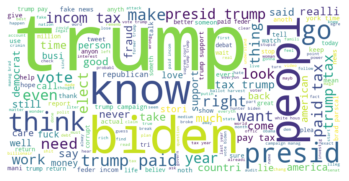

In [159]:
generate_word_cloud(mod_dt['tokens_no_stop'])

In [160]:
# importing libraries for topic modelling

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.corpora import Dictionary

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [161]:
# Build the bigram and trigram models

data = mod_dt['tokens_no_stop'].values.tolist()
bigram = gensim.models.Phrases(data, min_count=5, threshold=50) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams and Trigrams (phrases of two or three words that occur together and hence carry more meaning than a single word)
data_words_bigrams = make_bigrams(data)
#data_words_trigrams = make_trigrams(data)

# Create Dictionary
id2word = Dictionary(data_words_bigrams)
print(len(id2word))
id2word.filter_extremes(no_below=10, no_above=0.99)
print(len(id2word))

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Skip this LDA model technique
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
'''

14304
3061


"\nlda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,\n                                           id2word=id2word,\n                                           num_topics=20, \n                                           random_state=100,\n                                           update_every=1,\n                                           chunksize=100,\n                                           passes=10,\n                                           alpha='auto',\n                                           per_word_topics=True)\n"

In [162]:
# Creating topic model 
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=id2word, passes=25, workers=3) # it's essentially number of cpu cores - 1

In [165]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic : {idx} \nWords: {topic}\n")

Topic : 0 
Words: 0.155*"tax" + 0.103*"trump" + 0.090*"paid" + 0.036*"year" + 0.036*"pay" + 0.020*"incom" + 0.013*"much" + 0.011*"le" + 0.011*"feder_incom" + 0.009*"feder"

Topic : 1 
Words: 0.105*"trump" + 0.074*"year" + 0.036*"report" + 0.033*"presid" + 0.028*"news" + 0.026*"billionair" + 0.025*"fake" + 0.024*"brad_parscal" + 0.022*"former" + 0.018*"campaign_manag"

Topic : 2 
Words: 0.106*"trump" + 0.047*"fraud" + 0.028*"cheat" + 0.019*"broke" + 0.016*"go" + 0.016*"crimin" + 0.014*"jail" + 0.013*"lose" + 0.012*"famili" + 0.012*"prison"

Topic : 3 
Words: 0.076*"trump" + 0.040*"return" + 0.030*"time" + 0.019*"stori" + 0.017*"releas" + 0.012*"show" + 0.011*"presid" + 0.011*"fact" + 0.010*"true" + 0.010*"read"

Topic : 4 
Words: 0.046*"trump" + 0.035*"peopl" + 0.026*"support" + 0.024*"american" + 0.014*"vote" + 0.013*"biden" + 0.013*"think" + 0.012*"presid" + 0.012*"america" + 0.011*"even"

Topic : 5 
Words: 0.073*"trump" + 0.039*"million" + 0.031*"money" + 0.023*"fuck" + 0.014*"made" 

In [163]:
# Compute Coherence Score (a measure of the quality of the model amongst many other parameters (we will optimise better later but for now let's go off this weak value))
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35606494628311924


In [175]:
# Interactive Visualisation to play with for analysis of the topic model. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.show(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [11/Jan/2021 00:13:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Jan/2021 00:13:23] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Jan/2021 00:13:23] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Jan/2021 00:13:23] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


In [ ]:
'''
# Alternate Method using TF-IDF models (read up on this!)

from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))